In [ ]:
# =====================================================================
# STEP 1: SETUP SEDERHANA - HARDCODED SEMUA
# =====================================================================

# Mount drive dan import libraries
from google.colab import drive
drive.mount('/content/drive')

import os
import time
import pickle
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("DIN IMPLEMENTATION - HARDCODED SIMPLE VERSION")
print("="*80)
print(f"TensorFlow version: {tf.__version__}")

# Set seeds
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

# Paths
ROOT_PATH = '/content/drive/MyDrive/TA/DIEN/DIEN-tf2/new/dataset'
CHECKPOINT_ROOT = '/content/drive/MyDrive/TA/TAOBAO/checkpoints'
SAVE_PATH = '/content/drive/MyDrive/TA/TAOBAO/models'

# Create directories
os.makedirs(CHECKPOINT_ROOT, exist_ok=True)
os.makedirs(SAVE_PATH, exist_ok=True)

# File paths
RAW_SAMPLE_PATH = os.path.join(ROOT_PATH, 'raw_sample.csv')
AD_FEATURE_PATH = os.path.join(ROOT_PATH, 'ad_feature.csv')
USER_PROFILE_PATH = os.path.join(ROOT_PATH, 'user_profile.csv')
USER_BEHAVIOR_PATH = os.path.join(ROOT_PATH, 'UserBehavior.csv')

# HARDCODED SAMPLING - hanya 2 parameter
RAW_SAMPLE_SIZE = 26557961
USER_BEHAVIOR_SAMPLE_SIZE = 50000000

print(f"Setup completed")
print(f"Raw sample size: {RAW_SAMPLE_SIZE:,}")
print(f"User behavior size: {USER_BEHAVIOR_SAMPLE_SIZE:,}")
print(f"Models: DIN-DICE, DIN-PReLU, DeepFM, Baseline")

print("\n🎯 STEP 1 COMPLETED!")

Mounted at /content/drive
DIN IMPLEMENTATION - HARDCODED SIMPLE VERSION
TensorFlow version: 2.18.0
Setup completed
Raw sample size: 26,557,961
User behavior size: 50,000,000
Models: DIN-DICE, DIN-PReLU, DeepFM, Baseline

🎯 STEP 1 COMPLETED!


In [ ]:
import os

nama_folder = "tuning_results"
din_dice = 'din_dice'
din_prelu = 'din_prelu'
deepfm = 'deepfm'
baseline = 'baseline'

os.makedirs(nama_folder)
os.makedirs(os.path.join(nama_folder, din_dice))
os.makedirs(os.path.join(nama_folder, din_prelu))
os.makedirs(os.path.join(nama_folder, deepfm))
os.makedirs(os.path.join(nama_folder, baseline))

In [ ]:
# =====================================================================
# STEP 2: DATA LOADING DENGAN HEAD INSPECTION
# =====================================================================

def load_data_simple():
    """Load data dengan head inspection untuk setiap dataset"""
    print("\n" + "="*60)
    print("DATA LOADING DENGAN HEAD INSPECTION")
    print("="*60)

    try:
        # 1. RAW SAMPLE
        print(f"\n📊 1. LOADING RAW SAMPLE...")
        print("-" * 40)

        # Load dan inspect head
        raw_sample = pd.read_csv(RAW_SAMPLE_PATH)
        print(f"📋 Raw Sample Shape: {raw_sample.shape}")
        print(f"📋 Raw Sample Columns: {list(raw_sample.columns)}")
        print(f"\n🔍 Raw Sample Head (5 rows):")
        print(raw_sample.head())

        print(f"\nRaw Sample Info:")
        print(f"    Data types: {raw_sample.dtypes.value_counts().to_dict()}")
        print(f"    Missing values: {raw_sample.isnull().sum().sum()}")
        if 'clk' in raw_sample.columns:
            print(f"    CTR: {raw_sample['clk'].mean():.4f}")

        # Drop data leakage
        if 'nonclk' in raw_sample.columns:
            raw_sample = raw_sample.drop('nonclk', axis=1)
            print(f"    Removed nonclk feature")

        # Sampling stratified
        if len(raw_sample) > RAW_SAMPLE_SIZE:
            ctr = raw_sample['clk'].mean()
            pos_data = raw_sample[raw_sample['clk'] == 1]
            neg_data = raw_sample[raw_sample['clk'] == 0]

            pos_samples = int(RAW_SAMPLE_SIZE * ctr)
            neg_samples = RAW_SAMPLE_SIZE - pos_samples

            sampled_pos = pos_data.sample(n=min(pos_samples, len(pos_data)), random_state=1234)
            sampled_neg = neg_data.sample(n=min(neg_samples, len(neg_data)), random_state=1234)

            raw_sample = pd.concat([sampled_pos, sampled_neg], ignore_index=True)
            raw_sample = raw_sample.sample(frac=1, random_state=1234).reset_index(drop=True)

            print(f"    Sampled to {RAW_SAMPLE_SIZE:,} rows")

        print(f"    Final Raw Sample: {raw_sample.shape}, CTR: {raw_sample['clk'].mean():.4f}")

        # 2. AD FEATURES
        print(f"\n🏷️ 2. LOADING AD FEATURES...")
        print("-" * 40)

        ad_features = pd.read_csv(AD_FEATURE_PATH)
        print(f"Ad Features Shape: {ad_features.shape}")
        print(f"Ad Features Columns: {list(ad_features.columns)}")
        print(f"\n🔍 Ad Features Head (5 rows):")
        print(ad_features.head())

        print(f"\nAd Features Info:")
        print(f"    Data types: {ad_features.dtypes.value_counts().to_dict()}")
        print(f"    Missing values: {ad_features.isnull().sum().sum()}")
        print(f"    Unique items: {ad_features['adgroup_id'].nunique():,}")
        if 'price' in ad_features.columns:
            price_stats = ad_features['price'].describe()
            print(f"    Price range: [{price_stats['min']:.2f}, {price_stats['max']:.2f}]")
            print(f"    Price missing: {ad_features['price'].isnull().sum():,}")

        # 3. USER PROFILES
        print(f"\n👤 3. LOADING USER PROFILES...")
        print("-" * 40)

        user_profiles = pd.read_csv(USER_PROFILE_PATH)
        print(f"User Profiles Shape: {user_profiles.shape}")
        print(f"User Profiles Columns: {list(user_profiles.columns)}")
        print(f"\nUser Profiles Head (5 rows):")
        print(user_profiles.head())

        print(f"\nUser Profiles Info:")
        print(f"    Data types: {user_profiles.dtypes.value_counts().to_dict()}")
        print(f"    Missing values: {user_profiles.isnull().sum().sum()}")
        print(f"    Unique users: {user_profiles['userid'].nunique():,}")

        # Gender distribution if available
        if 'final_gender_code' in user_profiles.columns:
            gender_dist = user_profiles['final_gender_code'].value_counts().head()
            print(f"    Gender distribution: {gender_dist.to_dict()}")

        # Age level distribution if available
        if 'age_level' in user_profiles.columns:
            age_dist = user_profiles['age_level'].value_counts().head()
            print(f"    Age level distribution: {age_dist.to_dict()}")

        # 4. USER BEHAVIOR
        print(f"\n4. LOADING USER BEHAVIOR...")
        print("-" * 40)

        # Load first chunk to show head
        first_chunk = pd.read_csv(USER_BEHAVIOR_PATH,
                                header=None,
                                names=['user_id', 'item_id', 'category_id', 'behavior_type', 'timestamp'],
                                nrows=10)

        print(f"📋 User Behavior Columns: {list(first_chunk.columns)}")
        print(f"\n🔍 User Behavior Head (5 rows):")
        print(first_chunk.head())

        print(f"\n📊 User Behavior Preview Info:")
        print(f"    Data types: {first_chunk.dtypes.to_dict()}")
        print(f"    Behavior types: {first_chunk['behavior_type'].value_counts().to_dict()}")

        # Convert sample timestamps
        sample_timestamps = first_chunk['timestamp'].head(3)
        readable_times = [pd.to_datetime(ts, unit='s').strftime('%Y-%m-%d %H:%M:%S') for ts in sample_timestamps]
        print(f"    Sample timestamps: {readable_times}")

        # Load full behavior data in chunks
        print(f"\n🔄 Loading full user behavior data...")
        chunks = []
        total_rows = 0

        for i, chunk in enumerate(pd.read_csv(USER_BEHAVIOR_PATH,
                                header=None,
                                names=['user_id', 'item_id', 'category_id', 'behavior_type', 'timestamp'],
                                chunksize=500000)):
            chunks.append(chunk)
            total_rows += len(chunk)
            print(f"    Chunk {i+1}: {len(chunk):,} rows (Total: {total_rows:,})")

            if total_rows >= USER_BEHAVIOR_SAMPLE_SIZE:
                break

        user_behavior = pd.concat(chunks, ignore_index=True)
        if len(user_behavior) > USER_BEHAVIOR_SAMPLE_SIZE:
            user_behavior = user_behavior.sample(n=USER_BEHAVIOR_SAMPLE_SIZE, random_state=1234).reset_index(drop=True)

        print(f"    Final User Behavior: {user_behavior.shape}")
        print(f"    Final behavior types: {user_behavior['behavior_type'].value_counts().to_dict()}")
        print(f"    Unique users: {user_behavior['user_id'].nunique():,}")
        print(f"    Unique items: {user_behavior['item_id'].nunique():,}")

        # 5. DATASET OVERLAP ANALYSIS
        print(f"\n5. DATASET OVERLAP ANALYSIS")
        print("-" * 40)

        # Convert IDs to string for consistent comparison
        raw_users = set(raw_sample['user'].astype(str))
        profile_users = set(user_profiles['userid'].astype(str))
        behavior_users = set(user_behavior['user_id'].astype(str))

        raw_items = set(raw_sample['adgroup_id'].astype(str))
        ad_items = set(ad_features['adgroup_id'].astype(str))
        behavior_items = set(user_behavior['item_id'].astype(str))

        # User overlaps
        raw_profile_overlap = len(raw_users & profile_users)
        raw_behavior_overlap = len(raw_users & behavior_users)
        all_user_overlap = len(raw_users & profile_users & behavior_users)

        print(f"USER OVERLAPS:")
        print(f"    Raw sample users: {len(raw_users):,}")
        print(f"    Profile users: {len(profile_users):,}")
        print(f"    Behavior users: {len(behavior_users):,}")
        print(f"    Raw ∩ Profiles: {raw_profile_overlap:,} ({raw_profile_overlap/len(raw_users)*100:.1f}%)")
        print(f"    Raw ∩ Behavior: {raw_behavior_overlap:,} ({raw_behavior_overlap/len(raw_users)*100:.1f}%)")
        print(f"    All 3 datasets: {all_user_overlap:,} ({all_user_overlap/len(raw_users)*100:.1f}%)")

        # Item overlaps
        raw_ad_overlap = len(raw_items & ad_items)
        raw_behavior_item_overlap = len(raw_items & behavior_items)

        print(f"\nITEM OVERLAPS:")
        print(f"    Raw sample items: {len(raw_items):,}")
        print(f"    Ad feature items: {len(ad_items):,}")
        print(f"    Behavior items: {len(behavior_items):,}")
        print(f"    Raw ∩ Ad features: {raw_ad_overlap:,} ({raw_ad_overlap/len(raw_items)*100:.1f}%)")
        print(f"    Raw ∩ Behavior: {raw_behavior_item_overlap:,} ({raw_behavior_item_overlap/len(raw_items)*100:.1f}%)")

        # 6. SUMMARY
        print(f"\n6. DATA LOADING SUMMARY")
        print("-" * 40)
        print(f"Raw Sample: {raw_sample.shape} | CTR: {raw_sample['clk'].mean():.4f}")
        print(f"Ad Features: {ad_features.shape} | Items: {ad_features['adgroup_id'].nunique():,}")
        print(f"User Profiles: {user_profiles.shape} | Users: {user_profiles['userid'].nunique():,}")
        print(f"User Behavior: {user_behavior.shape} | Users: {user_behavior['user_id'].nunique():,}")
        print(f"Data quality: Good overlaps for feature engineering")

        return raw_sample, ad_features, user_profiles, user_behavior

    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

# Execute loading with detailed inspection
print("🚀 Loading data with detailed inspection...")
raw_sample, ad_features, user_profiles, user_behavior = load_data_simple()

if raw_sample is not None:
    print(f"\nSTEP 2 COMPLETED!")
    print(f"All data loaded with complete head inspection")
    print(f"Dataset overlaps analyzed")
    print(f"Data quality verified")
else:
    print(f"❌ STEP 2 FAILED")

🚀 Loading data with detailed inspection...

DATA LOADING DENGAN HEAD INSPECTION

📊 1. LOADING RAW SAMPLE...
----------------------------------------
📋 Raw Sample Shape: (26557961, 6)
📋 Raw Sample Columns: ['user', 'time_stamp', 'adgroup_id', 'pid', 'nonclk', 'clk']

🔍 Raw Sample Head (5 rows):
     user  time_stamp  adgroup_id          pid  nonclk  clk
0  581738  1494137644           1  430548_1007       1    0
1  449818  1494638778           3  430548_1007       1    0
2  914836  1494650879           4  430548_1007       1    0
3  914836  1494651029           5  430548_1007       1    0
4  399907  1494302958           8  430548_1007       1    0

Raw Sample Info:
    Data types: {dtype('int64'): 5, dtype('O'): 1}
    Missing values: 0
    CTR: 0.0514
    Removed nonclk feature
    Final Raw Sample: (26557961, 5), CTR: 0.0514

🏷️ 2. LOADING AD FEATURES...
----------------------------------------
Ad Features Shape: (846811, 6)
Ad Features Columns: ['adgroup_id', 'cate_id', 'campaign_id'

In [ ]:
 # =====================================================================
# STEP 3: FEATURE ENGINEERING SEDERHANA
# ======================================================================

def create_features_simple():
    """Feature engineering sederhana berdasarkan EDA"""
    print("\n" + "="*60)
    print("FEATURE ENGINEERING SEDERHANA")
    print("="*60)

    try:
        # Start with raw sample
        data = raw_sample.copy()
        print(f"Starting: {data.shape}")

        # 1. TEMPORAL FEATURES
        print(f"\nCreating temporal features...")
        data['datetime'] = pd.to_datetime(data['time_stamp'], unit='s')
        data['hour'] = data['datetime'].dt.hour
        data['day_of_week'] = data['datetime'].dt.dayofweek
        data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
        data['is_peak_hour'] = data['hour'].isin([20, 17, 18]).astype(int)

        # Hour CTR
        hour_ctr = data.groupby('hour')['clk'].mean()
        data['hour_ctr'] = data['hour'].map(hour_ctr)

        print(f"    Temporal features created")

        # 2. MERGE AD FEATURES (Brand + Category priority dari EDA)
        print(f"\nMerging ad features...")
        data = data.merge(
            ad_features[['adgroup_id', 'cate_id', 'brand', 'price']],
            on='adgroup_id',
            how='left'
        )

        # 3. PRICE FEATURES
        print(f"\nCreating price features...")
        data['price'] = pd.to_numeric(data['price'], errors='coerce')
        data['price'] = data['price'].fillna(data['price'].median())
        data['price_log'] = np.log1p(data['price'])
        data['price_percentile'] = data['price'].rank(pct=True)
        data['is_high_price'] = (data['price_percentile'] >= 0.8).astype(int)

        # 4. ITEM POPULARITY (EDA high importance)
        print(f"\nCreating item features...")
        item_stats = data.groupby('adgroup_id').agg({
            'clk': ['count', 'sum', 'mean'],
            'user': 'nunique'
        }).reset_index()
        item_stats.columns = ['adgroup_id', 'impressions', 'clicks', 'item_ctr', 'unique_users']
        item_stats = item_stats.fillna(0)

        # Popularity score
        item_stats['popularity_score'] = (
            np.log1p(item_stats['clicks']) * 0.4 +
            item_stats['item_ctr'] * 0.6
        )

        # Merge item features
        data = data.merge(
            item_stats[['adgroup_id', 'item_ctr', 'popularity_score']],
            on='adgroup_id',
            how='left'
        )

        # 5. USER PROFILES
        print(f"\nProcessing user profiles...")
        user_profiles_clean = user_profiles.copy()

        # Fill missing
        categorical_cols = ['final_gender_code', 'age_level', 'shopping_level']
        for col in categorical_cols:
            if col in user_profiles_clean.columns:
                user_profiles_clean[col] = user_profiles_clean[col].fillna(-1)

        if 'pvalue_level' in user_profiles_clean.columns:
            user_profiles_clean['pvalue_level'] = user_profiles_clean['pvalue_level'].fillna(
                user_profiles_clean['pvalue_level'].median()
            )

        # Merge profiles
        data = data.merge(
            user_profiles_clean[['userid', 'final_gender_code', 'age_level', 'shopping_level', 'pvalue_level']],
            left_on='user',
            right_on='userid',
            how='left'
        )

        # 6. USER BEHAVIOR (EDA: 46% overlap)
        print(f"\nCreating behavior features...")
        overlapping_users = set(data['user'].astype(str)) & set(user_behavior['user_id'].astype(str))
        behavior_filtered = user_behavior[user_behavior['user_id'].astype(str).isin(overlapping_users)].copy()

        if len(behavior_filtered) > 0:
            # Behavior weights
            behavior_weights = {'pv': 1.0, 'fav': 2.0, 'cart': 3.0, 'buy': 5.0}
            behavior_filtered['behavior_weight'] = behavior_filtered['behavior_type'].map(behavior_weights)

            # User aggregation
            user_behavior_agg = behavior_filtered.groupby('user_id').agg({
                'item_id': 'count',
                'category_id': 'nunique',
                'behavior_weight': ['sum', 'mean'],
                'behavior_type': [
                    lambda x: (x == 'buy').sum()
                ]
            }).reset_index()

            user_behavior_agg.columns = [
                'user_id', 'total_interactions', 'unique_categories',
                'engagement_score', 'avg_behavior_weight', 'buy_count'
            ]

            # Additional features
            user_behavior_agg['conversion_rate'] = user_behavior_agg['buy_count'] / (user_behavior_agg['total_interactions'] + 1)
            user_behavior_agg['is_buyer'] = (user_behavior_agg['buy_count'] > 0).astype(int)

            # Merge
            user_behavior_agg['user_id'] = user_behavior_agg['user_id'].astype(str)
            data['user_str'] = data['user'].astype(str)
            data = data.merge(user_behavior_agg, left_on='user_str', right_on='user_id', how='left')
            data = data.drop(['user_str', 'user_id'], axis=1, errors='ignore')

        # Fill missing behavior features
        behavior_cols = ['total_interactions', 'engagement_score', 'conversion_rate', 'is_buyer']
        for col in behavior_cols:
            if col in data.columns:
                data[col] = data[col].fillna(0)

        # 7. CATEGORICAL ENCODING
        print(f"\nEncoding categories...")
        categorical_features = ['final_gender_code', 'age_level', 'shopping_level', 'cate_id', 'brand']
        label_encoders = {}

        for col in categorical_features:
            if col in data.columns:
                data[col] = data[col].astype(str)
                if data[col].nunique() > 1:
                    le = LabelEncoder()
                    data[col] = le.fit_transform(data[col])
                    label_encoders[col] = le

        # 8. FINAL SELECTION
        print(f"\nFinal feature selection...")
        feature_cols = [
            'user', 'adgroup_id',  # IDs
            'cate_id', 'brand',
            'hour', 'is_peak_hour', 'hour_ctr', 'is_weekend', 'day_of_week', 'time_stamp', # Temporal
            'price_log', 'is_high_price', 'price_percentile',  # Price
            'item_ctr', 'popularity_score',  # Item
            'final_gender_code', 'age_level', 'shopping_level', 'pvalue_level',  # Profile
            'clk'  # Target
        ]

        # Add behavior if available
        if 'total_interactions' in data.columns:
            feature_cols.extend(['total_interactions', 'engagement_score', 'is_buyer', 'conversion_rate', 'unique_categories'])

        # Keep only existing
        available_cols = [col for col in feature_cols if col in data.columns]
        final_data = data[available_cols].copy()

        # 9. CLEAN MISSING
        print(f"\n🧹 Cleaning missing values...")
        for col in final_data.columns:
            if final_data[col].isnull().sum() > 0:
                if final_data[col].dtype in ['int64', 'float64']:
                    final_data[col] = final_data[col].fillna(0)
                else:
                    final_data[col] = final_data[col].fillna(-1)

        print(f"    Final shape: {final_data.shape}")
        print(f"    CTR preserved: {final_data['clk'].mean():.4f}")

        feature_list = [col for col in available_cols if col not in ['user', 'adgroup_id', 'clk']]

        return final_data, label_encoders, feature_list

    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# Execute feature engineering
print("Creating features...")
feature_data, label_encoders, feature_list = create_features_simple()

if feature_data is not None:
    print(f"\nSTEP 3 COMPLETED!")
    print(f"Features: {len(feature_list)}")
    print(f"Shape: {feature_data.shape}")
    print(f"CTR: {feature_data['clk'].mean():.4f}")
else:
    print(f"❌ STEP 3 FAILED")

Creating features...

FEATURE ENGINEERING SEDERHANA
Starting: (26557961, 5)

Creating temporal features...
    Temporal features created

Merging ad features...

Creating price features...

Creating item features...

Processing user profiles...

Creating behavior features...

Encoding categories...

Final feature selection...

🧹 Cleaning missing values...
    Final shape: (26557961, 25)
    CTR preserved: 0.0514

STEP 3 COMPLETED!
Features: 22
Shape: (26557961, 25)
CTR: 0.0514


In [ ]:
# =====================================================================
# STEP 4: MODEL DATA PREPARATION - TEMPORAL SPLIT
# =====================================================================

def prepare_model_data():
    """Prepare data dengan temporal split"""
    print("\n" + "="*60)
    print("MODEL DATA PREPARATION")
    print("="*60)

    try:
        print(f"Starting: {feature_data.shape}")

        # 1. SEPARATE TARGET AND FEATURES
        y = feature_data['clk'].values.astype(np.float32)
        X = feature_data.drop('clk', axis=1).copy()

        print(f"    Target shape: {y.shape}, CTR: {y.mean():.4f}")

        # 2. CREATE ID MAPPINGS
        print(f"\nCreating ID mappings...")

        # User mappings
        unique_users = sorted(X['user'].unique())
        user_to_idx = {uid: idx + 1 for idx, uid in enumerate(unique_users)}
        user_to_idx[0] = 0  # Unknown

        # Item mappings
        unique_items = sorted(X['adgroup_id'].unique())
        item_to_idx = {iid: idx + 1 for idx, iid in enumerate(unique_items)}
        item_to_idx[0] = 0  # Unknown

        # Convert
        user_ids = np.array([user_to_idx.get(uid, 0) for uid in X['user']], dtype=np.int32)
        item_ids = np.array([item_to_idx.get(iid, 0) for iid in X['adgroup_id']], dtype=np.int32)

        n_users = len(unique_users) + 1
        n_items = len(unique_items) + 1

        print(f"    Users: {n_users:,}, Items: {n_items:,}")

        # 3. CREATE SEQUENCES (simple version)
        print(f"\nCreating sequences...")

        # Sort by user and timestamp for sequences
        sequence_data = X.copy()
        sequence_data['user_id_mapped'] = user_ids
        sequence_data['item_id_mapped'] = item_ids
        sequence_data['target'] = y

        if 'time_stamp' in sequence_data.columns:
            sequence_data = sequence_data.sort_values(['user', 'time_stamp'])
        else:
            sequence_data = sequence_data.sort_values(['user'])

        # Build sequences
        max_seq_len = 8  # Hardcoded
        sequences = np.zeros((len(sequence_data), max_seq_len), dtype=np.int32)
        seq_lengths = np.ones(len(sequence_data), dtype=np.int32)

        user_sequences = {}
        for idx, row in sequence_data.iterrows():
            user_id = row['user']
            item_id = row['item_id_mapped']

            if user_id not in user_sequences:
                user_sequences[user_id] = []
            user_sequences[user_id].append(item_id)

        # Fill sequences
        for idx, row in sequence_data.iterrows():
            user_id = row['user']
            current_item = row['item_id_mapped']
            user_history = user_sequences[user_id]

            try:
                current_pos = user_history.index(current_item)
                history = user_history[:current_pos] if current_pos > 0 else [current_item]
            except ValueError:
                history = [current_item]

            seq_len = min(len(history), max_seq_len)
            if seq_len > 0:
                sequences[idx, :seq_len] = history[-seq_len:]
                seq_lengths[idx] = seq_len

        print(f"    Sequences: {sequences.shape}, avg length: {seq_lengths.mean():.2f}")

        # 4. DENSE FEATURES
        print(f"\nPreparing dense features...")
        dense_feature_cols = [col for col in X.columns
                             if col not in ['user', 'adgroup_id', 'time_stamp', 'datetime', 'userid']
                             and X[col].dtype in ['int64', 'float64']]

        dense_features = X[dense_feature_cols].values.astype(np.float32)
        dense_features = np.nan_to_num(dense_features, nan=0.0)

        # Scale features
        scaler = StandardScaler()
        dense_features = scaler.fit_transform(dense_features)

        print(f"    Dense features: {dense_features.shape}")

        # 5. TEMPORAL SPLIT (EDA recommended: 80/10/10)
        print(f"\nCreating temporal split...")

        # Sort by timestamp for temporal split
        if 'time_stamp' in feature_data.columns:
            sorted_data = feature_data.sort_values('time_stamp').reset_index(drop=True)
            sorted_indices = sorted_data.index.values

            # Get original order back
            original_order = np.argsort(sequence_data.index)
            user_ids = user_ids[original_order]
            item_ids = item_ids[original_order]
            sequences = sequences[original_order]
            seq_lengths = seq_lengths[original_order]
            dense_features = dense_features[original_order]
            y = y[original_order]

            # Create temporal split
            n_samples = len(y)
            train_end = int(0.80 * n_samples)
            val_end = int(0.90 * n_samples)

            train_idx = np.arange(0, train_end)
            val_idx = np.arange(train_end, val_end)
            test_idx = np.arange(val_end, n_samples)

            print(f"    Temporal split: {len(train_idx)}/{len(val_idx)}/{len(test_idx)}")

        else:
            # Fallback to stratified split
            indices = np.arange(len(y))
            temp_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=1234, stratify=y)
            train_idx, val_idx = train_test_split(temp_idx, test_size=0.125, random_state=1234, stratify=y[temp_idx])

            print(f"    Stratified split: {len(train_idx)}/{len(val_idx)}/{len(test_idx)}")

        def get_split_data(idx):
            return {
                'user_ids': user_ids[idx],
                'item_ids': item_ids[idx],
                'sequences': sequences[idx],
                'seq_lengths': seq_lengths[idx],
                'dense_features': dense_features[idx],
                'labels': y[idx].reshape(-1, 1)
            }

        splits = {
            'train': get_split_data(train_idx),
            'val': get_split_data(val_idx),
            'test': get_split_data(test_idx)
        }

        # Verify splits
        for split_name, split_data in splits.items():
            split_ctr = split_data['labels'].mean()
            print(f"    {split_name}: {len(split_data['labels']):,} samples, CTR: {split_ctr:.4f}")

        # 6. CREATE TF DATASETS
        print(f"\nCreating TensorFlow datasets...")

        def create_tf_dataset(split_data, batch_size=256, shuffle=True):
            dataset = tf.data.Dataset.from_tensor_slices({
                'user_id': split_data['user_ids'],
                'item_id': split_data['item_ids'],
                'sequence': split_data['sequences'],
                'seq_length': split_data['seq_lengths'],
                'dense_features': split_data['dense_features'],
                'label': split_data['labels']
            })

            if shuffle:
                dataset = dataset.shuffle(5000, seed=1234)

            dataset = dataset.batch(batch_size, drop_remainder=False)
            dataset = dataset.prefetch(2)
            return dataset

        # Create datasets
        train_dataset = create_tf_dataset(splits['train'], batch_size=256, shuffle=True)
        val_dataset = create_tf_dataset(splits['val'], batch_size=256, shuffle=False)
        test_dataset = create_tf_dataset(splits['test'], batch_size=256, shuffle=False)

        # Verify pipeline
        sample_batch = next(iter(train_dataset))
        print(f"    Batch shapes:")
        for key, value in sample_batch.items():
            print(f"      {key}: {value.shape}")

        return {
            'train_dataset': train_dataset,
            'val_dataset': val_dataset,
            'test_dataset': test_dataset,
            'splits': splits,
            'model_params': {
                'n_users': n_users,
                'n_items': n_items,
                'dense_feature_dim': dense_features.shape[1],
                'max_sequence_length': max_seq_len,
                'embedding_dim': 32,  # Hardcoded
                'hidden_units': [64, 32],  # Hardcoded
            },
            'preprocessing': {
                'user_to_idx': user_to_idx,
                'item_to_idx': item_to_idx,
                'scaler': scaler,
                'dense_feature_cols': dense_feature_cols,
                'label_encoders': label_encoders
            }
        }

    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Execute model preparation
print("Preparing model data...")
model_data = prepare_model_data()
splits = model_data['splits']
if model_data is not None:
    print(f"\n COMPLETED!")
    print(f"Temporal split created")
    print(f"TensorFlow datasets ready")
    print(f"Users: {model_data['model_params']['n_users']:,}")
    print(f"Items: {model_data['model_params']['n_items']:,}")
    print(f"Dense features: {model_data['model_params']['dense_feature_dim']}")
else:
    print(f"❌ STEP 4 FAILED")

Preparing model data...

MODEL DATA PREPARATION
Starting: (26557961, 25)
    Target shape: (26557961,), CTR: 0.0514

Creating ID mappings...
    Users: 1,141,730, Items: 846,812

Creating sequences...
    Sequences: (26557961, 8), avg length: 6.64

Preparing dense features...
    Dense features: (26557961, 19)

Creating temporal split...
    Temporal split: 21246368/2655796/2655797
    train: 21,246,368 samples, CTR: 0.0515
    val: 2,655,796 samples, CTR: 0.0511
    test: 2,655,797 samples, CTR: 0.0516

Creating TensorFlow datasets...
    Batch shapes:
      user_id: (256,)
      item_id: (256,)
      sequence: (256, 8)
      seq_length: (256,)
      dense_features: (256, 19)
      label: (256, 1)

 COMPLETED!
Temporal split created
TensorFlow datasets ready
Users: 1,141,730
Items: 846,812
Dense features: 19


In [ ]:
# =====================================================================
# STEP 5: LAYER DEFINITIONS ONLY
# =====================================================================

print("\n" + "="*60)
print("LAYER DEFINITIONS ONLY")
print("="*60)

class DiceActivation(tf.keras.layers.Layer):
    """
    DICE activation dari paper DIN dengan parameter optimal dari tuning

    Paper: Deep Interest Network for Click-Through Rate Prediction
    Formula: Dice(x) = p(x) * x + (1 - p(x)) * α * x
    dimana p(x) = sigmoid((x - E[x]) / sqrt(Var[x] + ε) * β)
    """
    def __init__(self, axis=-1, epsilon=8.84e-09, alpha_init=0.4515, beta_init=1.6703, **kwargs):
        super(DiceActivation, self).__init__(**kwargs)
        self.axis = axis
        self.epsilon = epsilon
        self.alpha_init = alpha_init  # Store alpha_init parameter
        self.beta_init = beta_init    # Store beta_init parameter

    def build(self, input_shape):
        param_shape = input_shape[1:]

        # Alpha: parameter untuk mengontrol negative part
        self.alpha = self.add_weight(
            name='alpha',
            shape=param_shape,
            initializer=tf.keras.initializers.Constant(self.alpha_init),  # Use the parameter
            trainable=True,
            constraint=tf.keras.constraints.NonNeg()
        )

        # Beta: parameter untuk scaling normalization
        self.beta = self.add_weight(
            name='beta',
            shape=param_shape,
            initializer=tf.keras.initializers.Constant(self.beta_init),  # Use the parameter
            trainable=True
        )

        super(DiceActivation, self).build(input_shape)

    def call(self, inputs, training=None):
        # Compute batch statistics
        if training:
            mean = tf.reduce_mean(inputs, axis=0, keepdims=True)
            variance = tf.reduce_mean(
                tf.square(inputs - mean),
                axis=0,
                keepdims=True
            )
        else:
            mean = tf.reduce_mean(inputs, axis=0, keepdims=True)
            variance = tf.reduce_mean(
                tf.square(inputs - mean),
                axis=0,
                keepdims=True
            )

        # Normalize dengan epsilon optimal
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        scaled = normalized * self.beta
        prob = tf.nn.sigmoid(scaled)

        # DICE output
        output = prob * inputs + (1.0 - prob) * self.alpha * inputs
        return output

class DINAttention(tf.keras.layers.Layer):
    """
    DIN Attention mechanism dengan dukungan untuk DICE dan PReLU activations
    """
    def __init__(self, hidden_units=16, max_seq_len=8, activation_type='dice',
                 dice_alpha_init=0.4515, dice_beta_init=1.6703, dice_epsilon=8.84e-09,
                 prelu_alpha_init=0.4515, **kwargs):
        super(DINAttention, self).__init__(**kwargs)
        self.hidden_units = hidden_units
        self.max_seq_len = max_seq_len
        self.activation_type = activation_type

        # Parameter untuk DICE
        self.dice_alpha_init = dice_alpha_init
        self.dice_beta_init = dice_beta_init
        self.dice_epsilon = dice_epsilon

        # Parameter untuk PReLU
        self.prelu_alpha_init = prelu_alpha_init

    def build(self, input_shape):
        # Dense layer tanpa aktivasi
        self.attention_dense = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(self.hidden_units, activation=None),
            name='attention_dense_td'
        )

        # Inisialisasi activation layer berdasarkan jenis
        if self.activation_type.lower() == 'dice':
            self.activation = DiceActivation(
                alpha_init=self.dice_alpha_init,
                beta_init=self.dice_beta_init,
                epsilon=self.dice_epsilon,
                name='attention_dice'
            )
        else:  # Default to PReLU if not DICE
            self.activation = tf.keras.layers.PReLU(
                alpha_initializer=tf.keras.initializers.Constant(self.prelu_alpha_init),
                name='attention_prelu'
            )

        # Output layer
        self.attention_output = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(1),
            name='attention_output_td'
        )
        super(DINAttention, self).build(input_shape)

    def call(self, inputs):
        sequence_emb, target_item_emb = inputs

        # Create custom layer for tile operation
        class TileLayer(tf.keras.layers.Layer):
            def __init__(self, max_seq_len):
                super().__init__()
                self.max_seq_len = max_seq_len

            def call(self, x):
                return tf.tile(
                    tf.expand_dims(x, axis=1),
                    [1, self.max_seq_len, 1]
                )

        tile_layer = TileLayer(self.max_seq_len)
        target_expanded = tile_layer(target_item_emb)

        # Element-wise operations
        element_wise_product = tf.keras.layers.Multiply()([sequence_emb, target_expanded])
        element_wise_diff = tf.keras.layers.Subtract()([sequence_emb, target_expanded])

        # Concatenate features
        attention_input = tf.keras.layers.Concatenate(axis=-1)([
            sequence_emb,
            target_expanded,
            element_wise_product,
            element_wise_diff
        ])

        # Apply attention network dengan aktivasi yang dipilih
        attention_hidden = self.attention_dense(attention_input)
        attention_hidden = self.activation(attention_hidden)  # Menggunakan activation layer
        attention_scores = self.attention_output(attention_hidden)

        return attention_scores, sequence_emb

class SequencePooling(tf.keras.layers.Layer):
    """Pooling layer untuk sequence dengan attention weights"""
    def __init__(self, **kwargs):
        super(SequencePooling, self).__init__(**kwargs)

    def call(self, inputs):
        attention_scores, sequence_emb, seq_lengths = inputs

        max_seq_len = tf.shape(attention_scores)[1]

        # Create sequence mask
        seq_mask = tf.sequence_mask(seq_lengths, max_seq_len, dtype=tf.float32)
        seq_mask = tf.expand_dims(seq_mask, axis=-1)

        # Apply mask to attention scores
        masked_scores = attention_scores + (1.0 - seq_mask) * (-1e9)

        # Softmax normalization
        attention_weights = tf.nn.softmax(masked_scores, axis=1)

        # Weighted sum
        attended_sequence = tf.reduce_sum(sequence_emb * attention_weights, axis=1)

        return attended_sequence

print(f"LAYER DEFINITIONS COMPLETED!")


LAYER DEFINITIONS ONLY
LAYER DEFINITIONS COMPLETED!


In [ ]:
# =====================================================================
# CELL 6A: CREATE DIN-DICE MODEL (OPTIMIZED)
# =====================================================================

print("\n" + "="*60)
print("CREATE DIN-DICE MODEl")
print("="*60)

def create_din_dice_model():

    # Model parameters from tuning
    n_users = model_data['model_params']['n_users']
    n_items = model_data['model_params']['n_items']
    embedding_dim = 32
    hidden_units = [64, 32]
    attention_hidden = 16
    max_seq_len = 8
    dense_feature_dim = model_data['model_params']['dense_feature_dim']
    dropout_rate = 0.5445
    l2_reg = 0.0001305
    l2_dense = 4.86e-05
    dice_alpha_init = 0.4515
    dice_beta_init = 1.6703
    dice_epsilon = 8.84e-09

    print(f"    Users: {n_users:,}")
    print(f"    Items: {n_items:,}")
    print(f"    Embedding dim: {embedding_dim}")
    print(f"    Hidden units: {hidden_units}")
    print(f"    Attention hidden: {attention_hidden}")
    print(f"    Max seq len: {max_seq_len}")
    print(f"    Dense features: {dense_feature_dim}")
    print(f"    Dropout rate: {dropout_rate}")
    print(f"    L2 regularization (embedding): {l2_reg:.6f}")
    print(f"    L2 regularization (dense): {l2_dense:.6f}")

    # Input layers
    user_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='user_id')
    item_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='item_id')
    sequence_input = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name='sequence')
    seq_length_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='seq_length')
    dense_input = tf.keras.layers.Input(shape=(dense_feature_dim,), dtype=tf.float32, name='dense_features')

    # EMBEDDING LAYERS
    user_embedding_layer = tf.keras.layers.Embedding(
        n_users, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
        name='user_embedding'
    )
    item_embedding_layer = tf.keras.layers.Embedding(
        n_items, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
        name='item_embedding'
    )

    # Apply embeddings
    user_emb = user_embedding_layer(user_input)
    target_item_emb = item_embedding_layer(item_input)
    sequence_emb = item_embedding_layer(sequence_input)

    # DIN Attention mechanism dengan attention_hidden optimal
    attention_scores, attended_emb = DINAttention(
        hidden_units=attention_hidden,
        max_seq_len=max_seq_len,
        activation_type='dice',
        dice_alpha_init=dice_alpha_init,  # Dari parameter tuning
        dice_beta_init=dice_beta_init,    # Dari parameter tuning
        dice_epsilon=dice_epsilon,        # Dari parameter tuning
        name='din_attention'
    )([sequence_emb, target_item_emb])

    # Sequence pooling
    pooled_sequence = SequencePooling(name='sequence_pooling')(
        [attention_scores, attended_emb, seq_length_input]
    )

    # Feature concatenation
    all_features = tf.keras.layers.Concatenate(name='feature_concat')([
        user_emb,
        target_item_emb,
        pooled_sequence,
        dense_input
    ])

    # DEEP NETWORK dengan DICE activation
    x = all_features
    for i, units in enumerate(hidden_units):
        x = tf.keras.layers.Dense(
            units,
            name=f'dense_{i+1}',
            kernel_regularizer=tf.keras.regularizers.l2(l2_dense)
        )(x)

        # DICE activation dari tuning
        x = DiceActivation(name=f'dice_{i+1}')(x)

        x = tf.keras.layers.Dropout(dropout_rate, name=f'dropout_{i+1}')(x)
        x = tf.keras.layers.BatchNormalization(name=f'bn_{i+1}')(x)

    # OUTPUT LAYER
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output',
                                 kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)

    # Create model
    model = tf.keras.Model(
        inputs=[user_input, item_input, sequence_input, seq_length_input, dense_input],
        outputs=output,
        name='din_dice_optimized'  # Renamed to reflect optimization
    )

    return model

# Create DIN-DICE model
print(f"Creating DIN-DICE model...")
try:
    din_dice_model = create_din_dice_model()

    # COMPILE SETTINGS
    learning_rate = 5.95e-05
    label_smoothing = 0.1462

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-8,
        clipnorm=0.5
    )
    metrics = [
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    # LOSS dengan label smoothing
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing)

    din_dice_model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    print(f"DIN-DICE model created successfully !")
    print(f"Model summary:")
    print(f"    Total parameters: {din_dice_model.count_params():,}")
    print(f"    Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in din_dice_model.trainable_weights]):,}")

    print(f"\nCONFIGURATION APPLIED:")
    print(f"    Learning rate: {learning_rate:.6f}")
    print(f"    Dropout rate: {0.5445:.4f}")
    print(f"    L2 embedding: {0.0001305:.6f}")
    print(f"    L2 dense: {4.86e-05:.6f}")
    print(f"    DICE α_init: 0.4515")
    print(f"    DICE β_init: 1.6703")
    print(f"    DICE ε: 8.84e-09")
    print(f"    Label smoothing: {0.1462:.4f}")

    # Test model dengan sample batch
    print(f"\n🧪 Testing OPTIMIZED DIN-DICE model...")
    test_batch = {
        'user_id': tf.constant([1, 2], dtype=tf.int32),
        'item_id': tf.constant([1, 2], dtype=tf.int32),
        'sequence': tf.constant([[1, 2, 0, 0, 0, 0, 0, 0], [1, 2, 3, 0, 0, 0, 0, 0]], dtype=tf.int32),
        'seq_length': tf.constant([2, 3], dtype=tf.int32),
        'dense_features': tf.random.normal((2, model_data['model_params']['dense_feature_dim']))
    }

    test_output = din_dice_model(test_batch, training=False)
    print(f"    Model test successful!")
    print(f"    Input batch size: 2")
    print(f"    Output shape: {test_output.shape}")
    print(f"    Output range: [{float(tf.reduce_min(test_output)):.4f}, {float(tf.reduce_max(test_output)):.4f}]")

    # Model architecture summary
    print(f"\nFULLY DIN-DICE Architecture Summary:")
    din_dice_model.summary(show_trainable=False)


except Exception as e:
    print(f"❌ Failed to create DIN-DICE model: {e}")
    import traceback
    traceback.print_exc()
    din_dice_model = None

print("="*60)


CREATE DIN-DICE MODEl
Creating DIN-DICE model...
    Users: 1,141,730
    Items: 846,812
    Embedding dim: 32
    Hidden units: [64, 32]
    Attention hidden: 16
    Max seq len: 8
    Dense features: 19
    Dropout rate: 0.5445
    L2 regularization (embedding): 0.000131
    L2 regularization (dense): 0.000049
DIN-DICE model created successfully !
Model summary:
    Total parameters: 63,645,794
    Trainable parameters: 63,645,602

CONFIGURATION APPLIED:
    Learning rate: 0.000060
    Dropout rate: 0.5445
    L2 embedding: 0.000131
    L2 dense: 0.000049
    DICE α_init: 0.4515
    DICE β_init: 1.6703
    DICE ε: 8.84e-09
    Label smoothing: 0.1462

🧪 Testing OPTIMIZED DIN-DICE model...
    Model test successful!
    Input batch size: 2
    Output shape: (2, 1)
    Output range: [0.4628, 0.4737]

FULLY DIN-DICE Architecture Summary:


Model: "din_dice_optimized"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ item_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequence            │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 8, 32)     │ 27,097,984 │ item_id[0][0],    │
│ (Embedding)         │                   │            │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ din_attention       │ [(None, 8, 1),    │      2,337 │ item_embedding[1… │
│ (DINAttention)      │ (None, 8, 32)]    │            │ item_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_length          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 32)        │ 36,535,360 │ user_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequence_pooling    │ (None, 32)        │          0 │ din_attention[0]… │
│ (SequencePooling)   │                   │            │ din_attention[0]… │
│                     │                   │            │ seq_length[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_features      │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_concat      │ (None, 115)       │          0 │ user_embedding[0… │
│ (Concatenate)       │                   │            │ item_embedding[0… │
│                     │                   │            │ sequence_pooling… │
│                     │                   │            │ dense_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      7,424 │ feature_concat[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dice_1              │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (DiceActivation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dice_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_1                │ (None, 64)        │        256 │ dropout_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ bn_1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dice_2              │ (None, 32)        │         64 │ dense_2[0][0]     │
│ (DiceActivation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dice_2[0][0]    

 Total params: 63,645,794 (242.79 MB)

 Trainable params: 63,645,602 (242.79 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# =====================================================================
# CELL 6B: CREATE DIN-PRELU MODEL (OPTIMIZED)
# =====================================================================

print("\n" + "="*60)
print("CREATE DIN-PRELU MODEL (FULLY OPTIMIZED)")
print("="*60)

def create_din_prelu_model():
    """Create DIN model dengan PReLU activation dan parameter optimal dari tuning"""

    # Model parameters from tuning
    n_users = model_data['model_params']['n_users']
    n_items = model_data['model_params']['n_items']
    embedding_dim = 32
    hidden_units = [64, 32]
    attention_hidden = 16
    max_seq_len = 8
    dense_feature_dim = model_data['model_params']['dense_feature_dim']
    dropout_rate = 0.5445
    l2_reg = 0.0001305
    l2_dense = 4.86e-05
    prelu_alpha_init = 0.4515

    print(f"    Users: {n_users:,}")
    print(f"    Items: {n_items:,}")
    print(f"    Embedding dim: {embedding_dim}")
    print(f"    Hidden units: {hidden_units}")
    print(f"    Attention hidden: {attention_hidden}")
    print(f"    Max seq len: {max_seq_len}")
    print(f"    Dense features: {dense_feature_dim}")
    print(f"    Dropout rate: {dropout_rate}")
    print(f"    L2 regularization (embedding): {l2_reg:.6f}")
    print(f"    L2 regularization (dense): {l2_dense:.6f}")

    # Input layers
    user_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='user_id')
    item_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='item_id')
    sequence_input = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name='sequence')
    seq_length_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='seq_length')
    dense_input = tf.keras.layers.Input(shape=(dense_feature_dim,), dtype=tf.float32, name='dense_features')

    # EMBEDDING LAYERS
    user_embedding_layer = tf.keras.layers.Embedding(
        n_users, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
        name='user_embedding'
    )
    item_embedding_layer = tf.keras.layers.Embedding(
        n_items, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
        name='item_embedding'
    )

    # Apply embeddings
    user_emb = user_embedding_layer(user_input)
    target_item_emb = item_embedding_layer(item_input)
    sequence_emb = item_embedding_layer(sequence_input)

    # DIN Attention mechanism
    attention_scores, attended_emb = DINAttention(
        hidden_units=attention_hidden,
        max_seq_len=max_seq_len,
        activation_type='prelu',
        prelu_alpha_init=prelu_alpha_init,  # Dari parameter tuning
        name='din_attention'
    )([sequence_emb, target_item_emb])

    # Sequence pooling
    pooled_sequence = SequencePooling(name='sequence_pooling')(
        [attention_scores, attended_emb, seq_length_input]
    )

    # Feature concatenation
    all_features = tf.keras.layers.Concatenate(name='feature_concat')([
        user_emb,
        target_item_emb,
        pooled_sequence,
        dense_input
    ])

    # DEEP NETWORK dengan PReLU activation
    x = all_features
    for i, units in enumerate(hidden_units):
        x = tf.keras.layers.Dense(
            units,
            name=f'dense_{i+1}',
            kernel_regularizer=tf.keras.regularizers.l2(l2_dense)
        )(x)

        # PReLU activation dengan alpha init sama dengan DICE alpha
        x = tf.keras.layers.PReLU(
            alpha_initializer=tf.keras.initializers.Constant(0.4948),
            name=f'prelu_{i+1}'
        )(x)

        x = tf.keras.layers.Dropout(dropout_rate, name=f'dropout_{i+1}')(x)
        x = tf.keras.layers.BatchNormalization(name=f'bn_{i+1}')(x)

    # OUTPUT LAYER
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output',
                                 kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)

    # Create model
    model = tf.keras.Model(
        inputs=[user_input, item_input, sequence_input, seq_length_input, dense_input],
        outputs=output,
        name='din_prelu_optimized'
    )

    return model

# Create DIN-PReLU model
print(f"Creating DIN-PReLU model with OPTIMAL TUNING PARAMETERS...")
try:
    din_prelu_model = create_din_prelu_model()

    # COMPILE SETTINGS
    learning_rate = 5.95e-05
    label_smoothing = 0.1462

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-8,
        clipnorm=0.5
    )
    metrics = [
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    # LOSS dengan label smoothing
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing)

    din_prelu_model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    print(f"DIN-PReLU model created successfully!")
    print(f"Model summary:")
    print(f"    Total parameters: {din_prelu_model.count_params():,}")
    print(f"    Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in din_prelu_model.trainable_weights]):,}")

    print(f"\nFULLY OPTIMIZED CONFIGURATION APPLIED FROM TUNING:")
    print(f"    Learning rate: {learning_rate:.6f}")
    print(f"    Dropout rate: {0.5445:.4f} ")
    print(f"    L2 embedding: {0.0001305:.6f} L")
    print(f"    L2 dense: {4.86e-05:.6f} ")
    print(f"    PReLU α_init: 0.4515")
    print(f"    Label smoothing: {0.1462:.4f}L")
    print(f"    Batch size: 4096")

    # Test model dengan sample batch
    print(f"\nTesting OPTIMIZED DIN-PReLU model...")
    test_batch = {
        'user_id': tf.constant([1, 2], dtype=tf.int32),
        'item_id': tf.constant([1, 2], dtype=tf.int32),
        'sequence': tf.constant([[1, 2, 0, 0, 0, 0, 0, 0], [1, 2, 3, 0, 0, 0, 0, 0]], dtype=tf.int32),
        'seq_length': tf.constant([2, 3], dtype=tf.int32),
        'dense_features': tf.random.normal((2, model_data['model_params']['dense_feature_dim']))
    }

    test_output = din_prelu_model(test_batch, training=False)
    print(f"    Model test successful!")
    print(f"    Input batch size: 2")
    print(f"    Output shape: {test_output.shape}")
    print(f"    Output range: [{float(tf.reduce_min(test_output)):.4f}, {float(tf.reduce_max(test_output)):.4f}]")

    # Model architecture summary
    print(f"\n📋 FULLY DIN-PReLU Architecture Summary:")
    din_prelu_model.summary(show_trainable=False)

    # Compare dengan DIN-DICE
    if 'din_dice_model' in globals() and din_dice_model is not None:
        print(f"\nComparison with DIN-DICE:")
        print(f"    DIN-DICE params: {din_dice_model.count_params():,}")
        print(f"    DIN-PReLU params: {din_prelu_model.count_params():,}")
        if din_prelu_model.count_params() == din_dice_model.count_params():
            print(f"    Same parameter count - perfect for fair comparison!")
        else:
            diff = din_prelu_model.count_params() - din_dice_model.count_params()
            print(f"    Parameter difference: {diff:+,}")

        print(f"\nACTIVATION COMPARISON:")
        print(f"    DIN-DICE: DICE activation with α_init=0.4948, β_init=1.6584, ε=3.95e-09")
        print(f"    DIN-PReLU: PReLU activation with α_init=0.4948")


except Exception as e:
    print(f"❌ Failed to create DIN-PReLU model: {e}")
    import traceback
    traceback.print_exc()
    din_prelu_model = None

print("="*60)


CREATE DIN-PRELU MODEL (FULLY OPTIMIZED)
Creating DIN-PReLU model with OPTIMAL TUNING PARAMETERS...
    Users: 1,141,730
    Items: 846,812
    Embedding dim: 32
    Hidden units: [64, 32]
    Attention hidden: 16
    Max seq len: 8
    Dense features: 19
    Dropout rate: 0.5445
    L2 regularization (embedding): 0.000131
    L2 regularization (dense): 0.000049
DIN-PReLU model created successfully!
Model summary:
    Total parameters: 63,645,570
    Trainable parameters: 63,645,378

FULLY OPTIMIZED CONFIGURATION APPLIED FROM TUNING:
    Learning rate: 0.000060
    Dropout rate: 0.5445 
    L2 embedding: 0.000131 L
    L2 dense: 0.000049 
    PReLU α_init: 0.4515
    Label smoothing: 0.1462L
    Batch size: 4096

Testing OPTIMIZED DIN-PReLU model...
    Model test successful!
    Input batch size: 2
    Output shape: (2, 1)
    Output range: [0.5214, 0.5841]

📋 FULLY DIN-PReLU Architecture Summary:


Model: "din_prelu_optimized"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ item_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequence            │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 8, 32)     │ 27,097,984 │ item_id[0][0],    │
│ (Embedding)         │                   │            │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ din_attention       │ [(None, 8, 1),    │      2,209 │ item_embedding[1… │
│ (DINAttention)      │ (None, 8, 32)]    │            │ item_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_length          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 32)        │ 36,535,360 │ user_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequence_pooling    │ (None, 32)        │          0 │ din_attention[0]… │
│ (SequencePooling)   │                   │            │ din_attention[0]… │
│                     │                   │            │ seq_length[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_features      │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_concat      │ (None, 115)       │          0 │ user_embedding[0… │
│ (Concatenate)       │                   │            │ item_embedding[0… │
│                     │                   │            │ sequence_pooling… │
│                     │                   │            │ dense_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      7,424 │ feature_concat[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prelu_1 (PReLU)     │ (None, 64)        │         64 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ prelu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_1                │ (None, 64)        │        256 │ dropout_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ bn_1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prelu_2 (PReLU)     │ (None, 32)        │         32 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ prelu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2                │ (None, 32)        │        128 │ dropout_2[0][0] 

 Total params: 63,645,570 (242.79 MB)

 Trainable params: 63,645,378 (242.79 MB)

 Non-trainable params: 192 (768.00 B)


Comparison with DIN-DICE:
    DIN-DICE params: 63,645,794
    DIN-PReLU params: 63,645,570
    Parameter difference: -224

ACTIVATION COMPARISON:
    DIN-DICE: DICE activation with α_init=0.4948, β_init=1.6584, ε=3.95e-09
    DIN-PReLU: PReLU activation with α_init=0.4948


In [ ]:
# =====================================================================
# CELL 6C: CREATE DEEPFM MODEL
# =====================================================================

print("\n" + "="*60)
print("CREATE DEEPFM MODEL")
print("="*60)

def create_deepfm_model():
    """Create DeepFM model dengan optimal parameters - tanpa sequence features"""

    # Model parameters
    n_users = model_data['model_params']['n_users']
    n_items = model_data['model_params']['n_items']
    embedding_dim = 32
    hidden_units = [128, 64, 32]
    dense_feature_dim = model_data['model_params']['dense_feature_dim']

    print(f"🔧 Creating DeepFM model with OPTIMAL parameters...")
    print(f"    Users: {n_users:,}")
    print(f"    Items: {n_items:,}")
    print(f"    Embedding dim: {embedding_dim}")
    print(f"    Hidden units: {hidden_units}")
    print(f"    Dense features: {dense_feature_dim}")
    print(f"    Note: No sequence features (DeepFM baseline)")

    # Input layers
    user_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='user_id')
    item_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='item_id')
    dense_input = tf.keras.layers.Input(shape=(dense_feature_dim,), dtype=tf.float32, name='dense_features')

    # EMBEDDING LAYERS
    user_embedding_layer = tf.keras.layers.Embedding(
        n_users, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(0.0005),
        name='user_embedding'
    )
    item_embedding_layer = tf.keras.layers.Embedding(
        n_items, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(0.0005),
        name='item_embedding'
    )

    # Apply embeddings
    user_emb = user_embedding_layer(user_input)
    item_emb = item_embedding_layer(item_input)

    # FM PART: Factorization Machine component
    print(f"    Building FM component...")

    # ✅ OPTIMAL LINEAR PART dengan L2 regularization
    user_linear = tf.keras.layers.Dense(1, use_bias=False, name='user_linear',
                                       kernel_regularizer=tf.keras.regularizers.l2(0.005))(user_emb)
    item_linear = tf.keras.layers.Dense(1, use_bias=False, name='item_linear',
                                       kernel_regularizer=tf.keras.regularizers.l2(0.005))(item_emb)
    dense_linear = tf.keras.layers.Dense(1, use_bias=False, name='dense_linear',
                                        kernel_regularizer=tf.keras.regularizers.l2(0.005))(dense_input)

    # INTERACTION PART dengan L2 regularization
    # User-Item interaction
    user_item_interaction = tf.keras.layers.Multiply(name='user_item_mult')([user_emb, item_emb])

    # User-Dense interaction
    user_dense_proj = tf.keras.layers.Dense(embedding_dim, name='user_dense_proj',
                                           kernel_regularizer=tf.keras.regularizers.l2(0.005))(dense_input)
    user_dense_interaction = tf.keras.layers.Multiply(name='user_dense_mult')([user_emb, user_dense_proj])

    # Item-Dense interaction
    item_dense_proj = tf.keras.layers.Dense(embedding_dim, name='item_dense_proj',
                                           kernel_regularizer=tf.keras.regularizers.l2(0.005))(dense_input)
    item_dense_interaction = tf.keras.layers.Multiply(name='item_dense_mult')([item_emb, item_dense_proj])

    # Sum all interactions
    fm_interactions = tf.keras.layers.Add(name='fm_interactions')([
        user_item_interaction,
        user_dense_interaction,
        item_dense_interaction
    ])
    fm_interaction_sum = tf.keras.layers.Dense(1, name='fm_interaction_sum',
                                              kernel_regularizer=tf.keras.regularizers.l2(0.005))(fm_interactions)

    # FM output
    fm_output = tf.keras.layers.Add(name='fm_output')([
        user_linear,
        item_linear,
        dense_linear,
        fm_interaction_sum
    ])

    # DEEP PART: Deep Neural Network component
    print(f"    Building Deep component...")

    # Concatenate all features untuk deep part
    deep_features = tf.keras.layers.Concatenate(name='deep_features')([
        user_emb,
        item_emb,
        dense_input
    ])

    # DEEP NETWORK
    x = deep_features
    for i, units in enumerate(hidden_units):
        x = tf.keras.layers.Dense(
            units,
            activation='relu',
            name=f'deep_dense_{i+1}',
            kernel_regularizer=tf.keras.regularizers.l2(0.005)
        )(x)
        x = tf.keras.layers.Dropout(0.5, name=f'deep_dropout_{i+1}')(x)
        x = tf.keras.layers.BatchNormalization(name=f'deep_bn_{i+1}')(x)

    # DEEP OUTPUT
    deep_output = tf.keras.layers.Dense(1, name='deep_output',
                                       kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)

    # COMBINE FM + DEEP
    print(f"    Combining FM + Deep components...")
    combined_output = tf.keras.layers.Add(name='fm_deep_combine')([fm_output, deep_output])

    # Final activation
    final_output = tf.keras.layers.Activation('sigmoid', name='final_output')(combined_output)

    # Create model
    model = tf.keras.Model(
        inputs=[user_input, item_input, dense_input],
        outputs=final_output,
        name='deepfm'
    )

    return model

# Dataset adapter for DeepFM (remove sequence features)
def create_deepfm_dataset():
    """Create dataset untuk DeepFM (tanpa sequence features)"""

    # Get original splits
    splits = model_data['splits']

    # Create new splits without sequence features
    deepfm_splits = {}

    for split_name in ['train', 'val', 'test']:
        deepfm_splits[split_name] = {
            'user_ids': splits[split_name]['user_ids'],
            'item_ids': splits[split_name]['item_ids'],
            'dense_features': splits[split_name]['dense_features'],
            'labels': splits[split_name]['labels']
        }

    print(f"📊 DeepFM dataset created:")
    for split_name, split_data in deepfm_splits.items():
        print(f"    {split_name}: {len(split_data['labels']):,} samples")

    return deepfm_splits

# Create DeepFM model
print(f"🚀 Creating DeepFM model...")
try:
    deepfm_model = create_deepfm_model()

    # Create DeepFM dataset
    deepfm_data = create_deepfm_dataset()

    # COMPILE SETTINGS
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-8,
        clipnorm=0.5
    )
    metrics = [
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    # LOSS dengan label smoothing
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)

    deepfm_model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    print(f"DeepFM model created successfully with OPTIMAL parameters!")
    print(f"Model summary:")
    print(f"    Total parameters: {deepfm_model.count_params():,}")
    print(f"    Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in deepfm_model.trainable_weights]):,}")

    print(f"\nOPTIMAL CONFIGURATION APPLIED:")
    print(f"    Learning rate: 0.0001")
    print(f"    Dropout: 0.5 ")
    print(f"    L2 embedding: 0.0005 ")
    print(f"    L2 dense: 0.005 ")
    print(f"    L2 output: 0.0005 ")
    print(f"    Gradient clip: 0.5")
    print(f"    Label smoothing: 0.1")

    # Test model dengan sample batch
    print(f"\nTesting DeepFM model...")
    test_batch = {
        'user_id': tf.constant([1, 2], dtype=tf.int32),
        'item_id': tf.constant([1, 2], dtype=tf.int32),
        'dense_features': tf.random.normal((2, model_data['model_params']['dense_feature_dim']))
    }

    test_output = deepfm_model(test_batch, training=False)
    print(f"    Model test successful!")
    print(f"    Input batch size: 2")
    print(f"    Output shape: {test_output.shape}")
    print(f"    Output range: [{float(tf.reduce_min(test_output)):.4f}, {float(tf.reduce_max(test_output)):.4f}]")

    # Model architecture summary
    print(f"\nDeepFM Architecture Summary:")
    deepfm_model.summary(show_trainable=False)

    # Compare dengan DIN models
    print(f"\nComparison with DIN models:")
    if 'din_dice_model' in globals() and din_dice_model is not None:
        print(f"    DIN-DICE params: {din_dice_model.count_params():,}")
    if 'din_prelu_model' in globals() and din_prelu_model is not None:
        print(f"    DIN-PReLU params: {din_prelu_model.count_params():,}")
    print(f"    DeepFM params: {deepfm_model.count_params():,}")

except Exception as e:
    print(f"❌ Failed to create DeepFM model: {e}")
    import traceback
    traceback.print_exc()
    deepfm_model = None
    deepfm_data = None

print("="*60)


CREATE DEEPFM MODEL
🚀 Creating DeepFM model...
🔧 Creating DeepFM model with OPTIMAL parameters...
    Users: 1,141,730
    Items: 846,812
    Embedding dim: 32
    Hidden units: [128, 64, 32]
    Dense features: 19
    Note: No sequence features (DeepFM baseline)
    Building FM component...
    Building Deep component...
    Combining FM + Deep components...
📊 DeepFM dataset created:
    train: 21,246,368 samples
    val: 2,655,796 samples
    test: 2,655,797 samples
DeepFM model created successfully with OPTIMAL parameters!
Model summary:
    Total parameters: 63,656,757
    Trainable parameters: 63,656,309

OPTIMAL CONFIGURATION APPLIED:
    Learning rate: 0.0001
    Dropout: 0.5 
    L2 embedding: 0.0005 
    L2 dense: 0.005 
    L2 output: 0.0005 
    Gradient clip: 0.5
    Label smoothing: 0.1

Testing DeepFM model...
    Model test successful!
    Input batch size: 2
    Output shape: (2, 1)
    Output range: [0.5827, 0.7174]

DeepFM Architecture Summary:


Model: "deepfm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 32)        │ 36,535,360 │ user_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 32)        │ 27,097,984 │ item_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_features      │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_features       │ (None, 83)        │          0 │ user_embedding[0… │
│ (Concatenate)       │                   │            │ item_embedding[0… │
│                     │                   │            │ dense_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_dense_1        │ (None, 128)       │     10,752 │ deep_features[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_dropout_1      │ (None, 128)       │          0 │ deep_dense_1[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_bn_1           │ (None, 128)       │        512 │ deep_dropout_1[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_dense_2        │ (None, 64)        │      8,256 │ deep_bn_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_dropout_2      │ (None, 64)        │          0 │ deep_dense_2[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_dense_proj     │ (None, 32)        │        640 │ dense_features[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_dense_proj     │ (None, 32)        │        640 │ dense_features[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_bn_2           │ (None, 64)        │        256 │ deep_dropout_2[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_item_mult      │ (None, 32)        │          0 │ user_embedding[0… │
│ (Multiply)          │                   │            │ item_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_dense_mult     │ (None, 32)        │          0 │ user_embedding[0… │
│ (Multiply)          │                   │            │ user_dense_proj[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 63,656,757 (242.83 MB)

 Trainable params: 63,656,309 (242.83 MB)

 Non-trainable params: 448 (1.75 KB)


Comparison with DIN models:
    DIN-DICE params: 63,645,794
    DIN-PReLU params: 63,645,570
    DeepFM params: 63,656,757


In [ ]:
# =====================================================================
# CELL 6D: CREATE BASELINE MODEL
# =====================================================================

print("\n" + "="*60)
print("CREATE BASELINE MODEL")
print("="*60)

def create_baseline_model():
    """Create simple baseline model dengan optimal parameters - basic feedforward network"""

    # Model parameters
    n_users = model_data['model_params']['n_users']
    n_items = model_data['model_params']['n_items']
    embedding_dim = 32
    hidden_units = [128, 64, 32]
    dense_feature_dim = model_data['model_params']['dense_feature_dim']

    print(f"🔧 Creating Baseline model with OPTIMAL parameters...")
    print(f"    Users: {n_users:,}")
    print(f"    Items: {n_items:,}")
    print(f"    Embedding dim: {embedding_dim}")
    print(f"    Hidden units: {hidden_units}")
    print(f"    Dense features: {dense_feature_dim}")
    print(f"    Note: Simple feedforward network (no FM, no attention)")

    # Input layers
    user_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='user_id')
    item_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='item_id')
    dense_input = tf.keras.layers.Input(shape=(dense_feature_dim,), dtype=tf.float32, name='dense_features')

    # EMBEDDING LAYERS
    user_embedding_layer = tf.keras.layers.Embedding(
        n_users, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(0.0005),
        name='user_embedding'
    )
    item_embedding_layer = tf.keras.layers.Embedding(
        n_items, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(0.0005),
        name='item_embedding'
    )

    # Apply embeddings
    user_emb = user_embedding_layer(user_input)
    item_emb = item_embedding_layer(item_input)

    # Simple feature concatenation
    print(f"    Building simple concatenation...")
    all_features = tf.keras.layers.Concatenate(name='feature_concat')([
        user_emb,
        item_emb,
        dense_input
    ])

    # FEEDFORWARD NETWORK
    print(f"    🔧 Building feedforward network...")
    x = all_features
    for i, units in enumerate(hidden_units):
        x = tf.keras.layers.Dense(
            units,
            activation='relu',
            name=f'dense_{i+1}',
            kernel_regularizer=tf.keras.regularizers.l2(0.005)
        )(x)
        x = tf.keras.layers.Dropout(0.5, name=f'dropout_{i+1}')(x)
        x = tf.keras.layers.BatchNormalization(name=f'bn_{i+1}')(x)

    # OUTPUT LAYER
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)

    # Create model
    model = tf.keras.Model(
        inputs=[user_input, item_input, dense_input],
        outputs=output,
        name='baseline'
    )

    return model

# Dataset adapter for Baseline
def create_baseline_dataset():
    """Create dataset untuk Baseline (tanpa sequence features)"""

    # Get original splits
    splits = model_data['splits']

    # Create new splits without sequence features
    baseline_splits = {}

    for split_name in ['train', 'val', 'test']:
        baseline_splits[split_name] = {
            'user_ids': splits[split_name]['user_ids'],
            'item_ids': splits[split_name]['item_ids'],
            'dense_features': splits[split_name]['dense_features'],
            'labels': splits[split_name]['labels']
        }

    print(f"Baseline dataset created:")
    for split_name, split_data in baseline_splits.items():
        print(f"    {split_name}: {len(split_data['labels']):,} samples")

    return baseline_splits

# TRAINING CONFIGURATION
def get_simple_training_config():
    """Get optimal training configuration untuk baseline models"""
    return {
        'epochs': 20,
        'batch_size': 2048,
        'validation_freq': 1,
        'callbacks': [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_auc',
                patience=4,
                mode='max',
                restore_best_weights=True,
                verbose=1
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_auc',
                factor=0.5,
                patience=3,
                mode='max',
                min_lr=1e-6,
                verbose=1
            )
        ]
    }

# Create Baseline model
print(f"Creating Baseline model...")
try:
    baseline_model = create_baseline_model()

    # Create Baseline dataset
    baseline_data = create_baseline_dataset()

    # Get training configuration
    baseline_config = get_simple_training_config()

    # ✅ OPTIMAL COMPILE SETTINGS
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-8,
        clipnorm=0.5
    )
    metrics = [
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    # LOSS dengan label smoothing
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)

    baseline_model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    print(f"Baseline model created successfully!")
    print(f"Model summary:")
    print(f"    Total parameters: {baseline_model.count_params():,}")
    print(f"    Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in baseline_model.trainable_weights]):,}")


    # Test model dengan sample batch
    print(f"\nTesting Baseline model...")
    test_batch = {
        'user_id': tf.constant([1, 2], dtype=tf.int32),
        'item_id': tf.constant([1, 2], dtype=tf.int32),
        'dense_features': tf.random.normal((2, model_data['model_params']['dense_feature_dim']))
    }

    test_output = baseline_model(test_batch, training=False)
    print(f"    Model test successful!")
    print(f"    Input batch size: 2")
    print(f"    Output shape: {test_output.shape}")
    print(f"    Output range: [{float(tf.reduce_min(test_output)):.4f}, {float(tf.reduce_max(test_output)):.4f}]")

    # Model architecture summary
    print(f"\nBaseline Architecture Summary:")
    baseline_model.summary(show_trainable=False)

    # Training configuration summary
    print(f"\nOPTIMAL Training Configuration:")
    print(f"    Epochs: {baseline_config['epochs']}")
    print(f"    Batch size: {baseline_config['batch_size']} (optimized)")
    print(f"    Early stopping: val_auc (patience=4)")
    print(f"    LR reduction: val_auc (patience=3, factor=0.5)")

    # Final comparison dengan all models
    print(f"\nALL MODELS PARAMETER COMPARISON:")
    if 'din_dice_model' in globals() and din_dice_model is not None:
        print(f"    DIN-DICE:  {din_dice_model.count_params():,} params")
    if 'din_prelu_model' in globals() and din_prelu_model is not None:
        print(f"    DIN-PReLU: {din_prelu_model.count_params():,} params")
    if 'deepfm_model' in globals() and deepfm_model is not None:
        print(f"    DeepFM:    {deepfm_model.count_params():,} params")
    print(f"    Baseline:  {baseline_model.count_params():,} params")

    print(f"\nBASELINE MODEL READY FOR TRAINING!")


except Exception as e:
    print(f"❌ Failed to create Baseline model: {e}")
    import traceback
    traceback.print_exc()
    baseline_model = None
    baseline_data = None
    baseline_config = None

print("="*60)


CREATE BASELINE MODEL
Creating Baseline model...
🔧 Creating Baseline model with OPTIMAL parameters...
    Users: 1,141,730
    Items: 846,812
    Embedding dim: 32
    Hidden units: [128, 64, 32]
    Dense features: 19
    Note: Simple feedforward network (no FM, no attention)
    Building simple concatenation...
    🔧 Building feedforward network...
Baseline dataset created:
    train: 21,246,368 samples
    val: 2,655,796 samples
    test: 2,655,797 samples
Baseline model created successfully!
Model summary:
    Total parameters: 63,655,361
    Trainable parameters: 63,654,913

Testing Baseline model...
    Model test successful!
    Input batch size: 2
    Output shape: (2, 1)
    Output range: [0.4112, 0.4461]

Baseline Architecture Summary:


Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 32)        │ 36,535,360 │ user_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 32)        │ 27,097,984 │ item_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_features      │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_concat      │ (None, 83)        │          0 │ user_embedding[0… │
│ (Concatenate)       │                   │            │ item_embedding[0… │
│                     │                   │            │ dense_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     10,752 │ feature_concat[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_1                │ (None, 128)       │        512 │ dropout_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ bn_1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2                │ (None, 64)        │        256 │ dropout_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ bn_2[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_3                │ (None, 32)        │        128 │ dropout_3[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ bn_3[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 63,655,361 (242.83 MB)

 Trainable params: 63,654,913 (242.82 MB)

 Non-trainable params: 448 (1.75 KB)


OPTIMAL Training Configuration:
    Epochs: 20
    Batch size: 2048 (optimized)
    Early stopping: val_auc (patience=4)
    LR reduction: val_auc (patience=3, factor=0.5)

ALL MODELS PARAMETER COMPARISON:
    DIN-DICE:  63,645,794 params
    DIN-PReLU: 63,645,570 params
    DeepFM:    63,656,757 params
    Baseline:  63,655,361 params

BASELINE MODEL READY FOR TRAINING!


In [ ]:
# =====================================================================
# CELL 6E: TRAINING FUNCTIONS DEFINITIONS (TEST ONLY AT END)
# =====================================================================

print("\n" + "="*60)
print("TRAINING FUNCTIONS DEFINITIONS")
print("="*60)

def manual_training_loop_din_dice(model=None, batch_size=2048, epochs=15, early_stopping_patience=4, save_csv=False):
    """Custom training loop for DIN-DICE model with test set evaluation only at the end"""
    # Start timer
    start_time = time.time()

    print(f"STARTING DIN-DICE TRAINING:")
    print(f"  Batch size: {batch_size}")
    print(f"  Epochs: {epochs}")
    print(f"  Early stopping patience: {early_stopping_patience}")

    # If no model is provided, use the global model
    if model is None:
        model = din_dice_model

    # Get data from global splits
    train_x = {
        'user_id': splits['train']['user_ids'],
        'item_id': splits['train']['item_ids'],
        'sequence': splits['train']['sequences'],
        'seq_length': splits['train']['seq_lengths'],
        'dense_features': splits['train']['dense_features']
    }
    val_x = {
        'user_id': splits['val']['user_ids'],
        'item_id': splits['val']['item_ids'],
        'sequence': splits['val']['sequences'],
        'seq_length': splits['val']['seq_lengths'],
        'dense_features': splits['val']['dense_features']
    }
    test_x = {
        'user_id': splits['test']['user_ids'],
        'item_id': splits['test']['item_ids'],
        'sequence': splits['test']['sequences'],
        'seq_length': splits['test']['seq_lengths'],
        'dense_features': splits['test']['dense_features']
    }

    train_y = splits['train']['labels'].flatten()
    val_y = splits['val']['labels'].flatten()
    test_y = splits['test']['labels'].flatten()

    # Setup optimizer, loss and metrics
    optimizer = tf.keras.optimizers.Adam(clipnorm=0.5)
    loss_fn = tf.keras.losses.BinaryCrossentropy()

    train_loss_metric = tf.keras.metrics.Mean()
    train_auc_metric = tf.keras.metrics.AUC()

    val_loss_metric = tf.keras.metrics.Mean()
    val_auc_metric = tf.keras.metrics.AUC()

    # History tracking
    history = {
        'loss': [],
        'auc': [],
        'val_loss': [],
        'val_auc': []
    }

    # Early stopping variables
    best_val_auc = 0.0
    patience_counter = 0
    best_epoch = 0
    best_weights = None

    # Training loop
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Reset metrics
        train_loss_metric.reset_state()
        train_auc_metric.reset_state()
        val_loss_metric.reset_state()
        val_auc_metric.reset_state()

        # Training phase
        n_train_batches = (len(train_y) + batch_size - 1) // batch_size
        indices = np.random.permutation(len(train_y))

        for batch_idx in range(n_train_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, len(train_y))
            batch_indices = indices[start_idx:end_idx]

            # Create batch
            batch_x = {k: tf.convert_to_tensor(v[batch_indices]) for k, v in train_x.items()}
            batch_y = tf.convert_to_tensor(train_y[batch_indices])

            # Training step
            with tf.GradientTape() as tape:
                predictions = model(batch_x, training=True)
                predictions = tf.squeeze(predictions)
                loss = loss_fn(batch_y, predictions)

            # Apply gradients
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Update metrics
            train_loss_metric.update_state(loss)
            train_auc_metric.update_state(batch_y, predictions)

            # Print progress
            if (batch_idx + 1) % 100 == 0:
                print(f"  Batch {batch_idx + 1}/{n_train_batches}")

        # Validation phase
        n_val_batches = (len(val_y) + batch_size - 1) // batch_size

        for batch_idx in range(n_val_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, len(val_y))

            # Create batch
            batch_x = {k: tf.convert_to_tensor(v[start_idx:end_idx]) for k, v in val_x.items()}
            batch_y = tf.convert_to_tensor(val_y[start_idx:end_idx])

            # Validation step
            predictions = model(batch_x, training=False)
            predictions = tf.squeeze(predictions)
            loss = loss_fn(batch_y, predictions)

            # Update metrics
            val_loss_metric.update_state(loss)
            val_auc_metric.update_state(batch_y, predictions)

        # Get epoch results
        epoch_train_loss = train_loss_metric.result().numpy()
        epoch_train_auc = train_auc_metric.result().numpy()
        epoch_val_loss = val_loss_metric.result().numpy()
        epoch_val_auc = val_auc_metric.result().numpy()

        # Store history
        history['loss'].append(epoch_train_loss)
        history['auc'].append(epoch_train_auc)
        history['val_loss'].append(epoch_val_loss)
        history['val_auc'].append(epoch_val_auc)

        # Print results (only train and validation)
        print(f"  Train Loss: {epoch_train_loss:.4f}, AUC: {epoch_train_auc:.4f}")
        print(f"  Val   Loss: {epoch_val_loss:.4f}, AUC: {epoch_val_auc:.4f}")

        # Check early stopping
        if epoch_val_auc > best_val_auc:
            best_val_auc = epoch_val_auc
            best_epoch = epoch
            patience_counter = 0
            best_weights = model.get_weights()
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

    # Restore best weights
    if best_weights is not None:
        model.set_weights(best_weights)

    # NOW EVALUATE ON TEST SET (only once, after training is complete)
    print(f"\nTraining completed. Evaluating final model on test set...")

    test_auc_metric = tf.keras.metrics.AUC()
    all_test_preds = []
    all_test_labels = []

    n_test_batches = (len(test_y) + batch_size - 1) // batch_size
    for batch_idx in range(n_test_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(test_y))

        # Create batch
        batch_x = {k: tf.convert_to_tensor(v[start_idx:end_idx]) for k, v in test_x.items()}
        batch_y = tf.convert_to_tensor(test_y[start_idx:end_idx])

        # Test step
        predictions = model(batch_x, training=False)
        predictions = tf.squeeze(predictions)

        # Update metrics
        test_auc_metric.update_state(batch_y, predictions)

        # Store predictions for log loss calculation
        all_test_preds.append(predictions.numpy())
        all_test_labels.append(batch_y.numpy())

    # Calculate test metrics
    best_test_auc = test_auc_metric.result().numpy()
    all_test_preds = np.concatenate(all_test_preds)
    all_test_labels = np.concatenate(all_test_labels)
    best_test_logloss = log_loss(all_test_labels, all_test_preds)

    # Calculate training time
    training_time = time.time() - start_time

    # Final evaluation
    print(f"\nFINAL RESULTS:")
    print(f"  Best epoch: {best_epoch + 1}")
    print(f"  Best validation AUC: {best_val_auc:.4f}")
    print(f"  Test AUC: {best_test_auc:.4f}")
    print(f"  Test log loss: {best_test_logloss:.4f}")
    print(f"  Training time: {training_time:.1f}s")

    # Create history plot
    plt.figure(figsize=(12, 4))

    # Plot AUC
    plt.subplot(1, 2, 1)
    plt.plot(history['auc'], label='Train AUC')
    plt.plot(history['val_auc'], label='Val AUC')
    plt.axhline(y=best_test_auc, color='r', linestyle='--', label='Test AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('AUC Metrics')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.axhline(y=best_test_logloss, color='r', linestyle='--', label='Test LogLoss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Metrics')
    plt.legend()

    plt.tight_layout()
    plt.savefig('din_dice_training_history.png', dpi=300)
    plt.show()

    # Save results to CSV
    if save_csv:
        # Create results DataFrame
        results_df = pd.DataFrame({
            'epoch': range(1, len(history['loss']) + 1),
            'train_loss': history['loss'],
            'train_auc': history['auc'],
            'val_loss': history['val_loss'],
            'val_auc': history['val_auc'],
        })

        # Add test results only for best epoch
        results_df['test_auc'] = np.nan
        results_df['test_logloss'] = np.nan
        results_df.loc[best_epoch, 'test_auc'] = best_test_auc
        results_df.loc[best_epoch, 'test_logloss'] = best_test_logloss

        results_df.to_csv('din_dice_training_results.csv', index=False)
        print(f"Training results saved to din_dice_training_results.csv")

    # Return results
    return {
        'success': True,
        'best_epoch': best_epoch + 1,
        'best_val_auc': best_val_auc,
        'best_test_auc': best_test_auc,
        'best_test_logloss': best_test_logloss,
        'history': {
            'loss': history['loss'],
            'auc': history['auc'],
            'val_loss': history['val_loss'],
            'val_auc': history['val_auc'],
            'test_auc': best_test_auc,  # Just the final value
            'test_logloss': best_test_logloss  # Just the final value
        },
        'training_time': training_time
    }

def manual_training_loop_din_prelu(model=None, batch_size=2048, epochs=15, early_stopping_patience=4, save_csv=False):
    """Custom training loop for DIN-PReLU model with test set evaluation only at the end"""
    # Start timer
    start_time = time.time()

    print(f"STARTING DIN-PReLU TRAINING:")
    print(f"  Batch size: {batch_size}")
    print(f"  Epochs: {epochs}")
    print(f"  Early stopping patience: {early_stopping_patience}")
    print(f"  Test set evaluation: Only at end of training")

    # If no model is provided, use the global model
    if model is None:
        model = din_prelu_model

    # Get data from global splits
    train_x = {
        'user_id': splits['train']['user_ids'],
        'item_id': splits['train']['item_ids'],
        'sequence': splits['train']['sequences'],
        'seq_length': splits['train']['seq_lengths'],
        'dense_features': splits['train']['dense_features']
    }
    val_x = {
        'user_id': splits['val']['user_ids'],
        'item_id': splits['val']['item_ids'],
        'sequence': splits['val']['sequences'],
        'seq_length': splits['val']['seq_lengths'],
        'dense_features': splits['val']['dense_features']
    }
    test_x = {
        'user_id': splits['test']['user_ids'],
        'item_id': splits['test']['item_ids'],
        'sequence': splits['test']['sequences'],
        'seq_length': splits['test']['seq_lengths'],
        'dense_features': splits['test']['dense_features']
    }

    train_y = splits['train']['labels'].flatten()
    val_y = splits['val']['labels'].flatten()
    test_y = splits['test']['labels'].flatten()

    # Setup optimizer, loss and metrics
    optimizer = tf.keras.optimizers.Adam(clipnorm=0.5)
    loss_fn = tf.keras.losses.BinaryCrossentropy()

    train_loss_metric = tf.keras.metrics.Mean()
    train_auc_metric = tf.keras.metrics.AUC()

    val_loss_metric = tf.keras.metrics.Mean()
    val_auc_metric = tf.keras.metrics.AUC()

    # History tracking
    history = {
        'loss': [],
        'auc': [],
        'val_loss': [],
        'val_auc': []
    }

    # Early stopping variables
    best_val_auc = 0.0
    patience_counter = 0
    best_epoch = 0
    best_weights = None

    # Training loop
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Reset metrics
        train_loss_metric.reset_state()
        train_auc_metric.reset_state()
        val_loss_metric.reset_state()
        val_auc_metric.reset_state()

        # Training phase
        n_train_batches = (len(train_y) + batch_size - 1) // batch_size
        indices = np.random.permutation(len(train_y))

        for batch_idx in range(n_train_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, len(train_y))
            batch_indices = indices[start_idx:end_idx]

            # Create batch
            batch_x = {k: tf.convert_to_tensor(v[batch_indices]) for k, v in train_x.items()}
            batch_y = tf.convert_to_tensor(train_y[batch_indices])

            # Training step
            with tf.GradientTape() as tape:
                predictions = model(batch_x, training=True)
                predictions = tf.squeeze(predictions)
                loss = loss_fn(batch_y, predictions)

            # Apply gradients
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Update metrics
            train_loss_metric.update_state(loss)
            train_auc_metric.update_state(batch_y, predictions)

            # Print progress
            if (batch_idx + 1) % 100 == 0:
                print(f"  Batch {batch_idx + 1}/{n_train_batches}")

        # Validation phase
        n_val_batches = (len(val_y) + batch_size - 1) // batch_size

        for batch_idx in range(n_val_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, len(val_y))

            # Create batch
            batch_x = {k: tf.convert_to_tensor(v[start_idx:end_idx]) for k, v in val_x.items()}
            batch_y = tf.convert_to_tensor(val_y[start_idx:end_idx])

            # Validation step
            predictions = model(batch_x, training=False)
            predictions = tf.squeeze(predictions)
            loss = loss_fn(batch_y, predictions)

            # Update metrics
            val_loss_metric.update_state(loss)
            val_auc_metric.update_state(batch_y, predictions)

        # Get epoch results
        epoch_train_loss = train_loss_metric.result().numpy()
        epoch_train_auc = train_auc_metric.result().numpy()
        epoch_val_loss = val_loss_metric.result().numpy()
        epoch_val_auc = val_auc_metric.result().numpy()

        # Store history
        history['loss'].append(epoch_train_loss)
        history['auc'].append(epoch_train_auc)
        history['val_loss'].append(epoch_val_loss)
        history['val_auc'].append(epoch_val_auc)

        # Print results (only train and validation)
        print(f"  Train Loss: {epoch_train_loss:.4f}, AUC: {epoch_train_auc:.4f}")
        print(f"  Val   Loss: {epoch_val_loss:.4f}, AUC: {epoch_val_auc:.4f}")

        # Check early stopping
        if epoch_val_auc > best_val_auc:
            best_val_auc = epoch_val_auc
            best_epoch = epoch
            patience_counter = 0
            best_weights = model.get_weights()
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

    # Restore best weights
    if best_weights is not None:
        model.set_weights(best_weights)

    # NOW EVALUATE ON TEST SET (only once, after training is complete)
    print(f"\nTraining completed. Evaluating final model on test set...")

    test_auc_metric = tf.keras.metrics.AUC()
    all_test_preds = []
    all_test_labels = []

    n_test_batches = (len(test_y) + batch_size - 1) // batch_size
    for batch_idx in range(n_test_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(test_y))

        # Create batch
        batch_x = {k: tf.convert_to_tensor(v[start_idx:end_idx]) for k, v in test_x.items()}
        batch_y = tf.convert_to_tensor(test_y[start_idx:end_idx])

        # Test step
        predictions = model(batch_x, training=False)
        predictions = tf.squeeze(predictions)

        # Update metrics
        test_auc_metric.update_state(batch_y, predictions)

        # Store predictions for log loss calculation
        all_test_preds.append(predictions.numpy())
        all_test_labels.append(batch_y.numpy())

    # Calculate test metrics
    best_test_auc = test_auc_metric.result().numpy()
    all_test_preds = np.concatenate(all_test_preds)
    all_test_labels = np.concatenate(all_test_labels)
    best_test_logloss = log_loss(all_test_labels, all_test_preds)

    # Calculate training time
    training_time = time.time() - start_time

    # Final evaluation
    print(f"\nFINAL RESULTS:")
    print(f"  Best epoch: {best_epoch + 1}")
    print(f"  Best validation AUC: {best_val_auc:.4f}")
    print(f"  Test AUC: {best_test_auc:.4f}")
    print(f"  Test log loss: {best_test_logloss:.4f}")
    print(f"  Training time: {training_time:.1f}s")

    # Create history plot
    plt.figure(figsize=(12, 4))

    # Plot AUC
    plt.subplot(1, 2, 1)
    plt.plot(history['auc'], label='Train AUC')
    plt.plot(history['val_auc'], label='Val AUC')
    plt.axhline(y=best_test_auc, color='r', linestyle='--', label='Test AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('AUC Metrics')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.axhline(y=best_test_logloss, color='r', linestyle='--', label='Test LogLoss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Metrics')
    plt.legend()

    plt.tight_layout()
    plt.savefig('din_prelu_training_history.png', dpi=300)
    plt.show()

    # Save results to CSV
    if save_csv:
        # Create results DataFrame
        results_df = pd.DataFrame({
            'epoch': range(1, len(history['loss']) + 1),
            'train_loss': history['loss'],
            'train_auc': history['auc'],
            'val_loss': history['val_loss'],
            'val_auc': history['val_auc'],
        })

        # Add test results only for best epoch
        results_df['test_auc'] = np.nan
        results_df['test_logloss'] = np.nan
        results_df.loc[best_epoch, 'test_auc'] = best_test_auc
        results_df.loc[best_epoch, 'test_logloss'] = best_test_logloss

        results_df.to_csv('din_prelu_training_results.csv', index=False)
        print(f"Training results saved to din_prelu_training_results.csv")

    # Return results
    return {
        'success': True,
        'best_epoch': best_epoch + 1,
        'best_val_auc': best_val_auc,
        'best_test_auc': best_test_auc,
        'best_test_logloss': best_test_logloss,
        'history': {
            'loss': history['loss'],
            'auc': history['auc'],
            'val_loss': history['val_loss'],
            'val_auc': history['val_auc'],
            'test_auc': best_test_auc,  # Just the final value
            'test_logloss': best_test_logloss  # Just the final value
        },
        'training_time': training_time
    }

def create_deepfm_dataset():
    """Create dataset for DeepFM model"""
    print(f"Creating DeepFM dataset...")

    # Use global splits
    deepfm_train_x = {
        'user_id': splits['train']['user_ids'],
        'item_id': splits['train']['item_ids'],
        'dense_features': splits['train']['dense_features']
    }
    deepfm_val_x = {
        'user_id': splits['val']['user_ids'],
        'item_id': splits['val']['item_ids'],
        'dense_features': splits['val']['dense_features']
    }
    deepfm_test_x = {
        'user_id': splits['test']['user_ids'],
        'item_id': splits['test']['item_ids'],
        'dense_features': splits['test']['dense_features']
    }

    deepfm_train_y = splits['train']['labels'].flatten()
    deepfm_val_y = splits['val']['labels'].flatten()
    deepfm_test_y = splits['test']['labels'].flatten()

    # Return dataset
    return {
        'train_x': deepfm_train_x,
        'train_y': deepfm_train_y,
        'val_x': deepfm_val_x,
        'val_y': deepfm_val_y,
        'test_x': deepfm_test_x,
        'test_y': deepfm_test_y
    }

def train_deepfm_model(model=None, batch_size=2048, epochs=15, early_stopping_patience=4, save_csv=False):
    """Train DeepFM model with test set evaluation only at the end"""
    # Start timer
    start_time = time.time()

    print(f"STARTING DEEPFM TRAINING:")
    print(f"  Batch size: {batch_size}")
    print(f"  Epochs: {epochs}")
    print(f"  Early stopping patience: {early_stopping_patience}")
    print(f"  Test set evaluation: Only at end of training")

    # If no model is provided, use the global model
    if model is None:
        model = deepfm_model

    # Get dataset
    dataset = create_deepfm_dataset()

    # Create custom callback to avoid test set evaluation during training
    class NoTestCallback(tf.keras.callbacks.Callback):
        def __init__(self):
            super(NoTestCallback, self).__init__()
            self.best_val_auc = 0
            self.best_weights = None
            self.patience_counter = 0
            self.best_epoch = 0
            self.patience = early_stopping_patience

        def on_epoch_end(self, epoch, logs=None):
            current_val_auc = logs.get('val_auc')
            if current_val_auc > self.best_val_auc:
                self.best_val_auc = current_val_auc
                self.best_epoch = epoch
                self.patience_counter = 0
                self.best_weights = self.model.get_weights()
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.patience:
                self.model.stop_training = True
                print(f"Early stopping triggered after {epoch + 1} epochs!")

        def on_train_end(self, logs=None):
            # Restore best weights
            if self.best_weights is not None:
                self.model.set_weights(self.best_weights)
                print(f"Restored best weights from epoch {self.best_epoch + 1}")

    # Custom callback
    no_test_callback = NoTestCallback()

    # Fit model
    history = model.fit(
        x=dataset['train_x'],
        y=dataset['train_y'],
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(dataset['val_x'], dataset['val_y']),
        callbacks=[no_test_callback],
        verbose=1
    )

    # NOW EVALUATE ON TEST SET (only once, after training is complete)
    print(f"\nTraining completed. Evaluating final model on test set...")

    # Evaluate on test set
    test_results = model.evaluate(
        x=dataset['test_x'],
        y=dataset['test_y'],
        batch_size=batch_size,
        verbose=1
    )

    # Calculate test log loss
    test_preds = model.predict(dataset['test_x'], batch_size=batch_size)
    test_logloss = log_loss(dataset['test_y'], test_preds)

    # Calculate training time
    training_time = time.time() - start_time

    # Get best values
    best_epoch = no_test_callback.best_epoch
    best_val_auc = no_test_callback.best_val_auc
    best_test_auc = test_results[1]  # AUC is the second metric

    # Final evaluation
    print(f"\nFINAL RESULTS:")
    print(f"  Best epoch: {best_epoch + 1}")
    print(f"  Best validation AUC: {best_val_auc:.4f}")
    print(f"  Test AUC: {best_test_auc:.4f}")
    print(f"  Test Log Loss: {test_logloss:.4f}")
    print(f"  Training time: {training_time:.1f}s")

    # Create history plot
    plt.figure(figsize=(12, 4))

    # Plot AUC
    plt.subplot(1, 2, 1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.axhline(y=best_test_auc, color='r', linestyle='--', label='Test AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('AUC Metrics')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.axhline(y=test_logloss, color='r', linestyle='--', label='Test LogLoss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Metrics')
    plt.legend()

    plt.tight_layout()
    plt.savefig('deepfm_training_history.png', dpi=300)
    plt.show()

    # Save results to CSV
    if save_csv:
        # Create results DataFrame
        epochs_completed = len(history.history['loss'])
        results_df = pd.DataFrame({
            'epoch': range(1, epochs_completed + 1),
            'train_loss': history.history['loss'],
            'train_auc': history.history['auc'],
            'val_loss': history.history['val_loss'],
            'val_auc': history.history['val_auc']
        })

        # Add test results only for best epoch
        results_df['test_auc'] = np.nan
        results_df['test_logloss'] = np.nan
        results_df.loc[best_epoch, 'test_auc'] = best_test_auc
        results_df.loc[best_epoch, 'test_logloss'] = test_logloss

        results_df.to_csv('deepfm_training_results.csv', index=False)
        print(f"Training results saved to deepfm_training_results.csv")

    # Return results
    return {
        'success': True,
        'best_epoch': best_epoch + 1,
        'best_val_auc': best_val_auc,
        'best_test_auc': best_test_auc,
        'best_test_logloss': test_logloss,
        'history': {
            'loss': history.history['loss'],
            'auc': history.history['auc'],
            'val_loss': history.history['val_loss'],
            'val_auc': history.history['val_auc'],
            'test_auc': best_test_auc,  # Just the final value
            'test_logloss': test_logloss  # Just the final value
        },
        'training_time': training_time
    }

def create_baseline_dataset():
    """Create dataset for Baseline model"""
    print(f"Creating Baseline dataset...")

    # Use global splits
    baseline_train_x = {
        'user_id': splits['train']['user_ids'],
        'item_id': splits['train']['item_ids'],
        'dense_features': splits['train']['dense_features']
    }
    baseline_val_x = {
        'user_id': splits['val']['user_ids'],
        'item_id': splits['val']['item_ids'],
        'dense_features': splits['val']['dense_features']
    }
    baseline_test_x = {
        'user_id': splits['test']['user_ids'],
        'item_id': splits['test']['item_ids'],
        'dense_features': splits['test']['dense_features']
    }

    baseline_train_y = splits['train']['labels'].flatten()
    baseline_val_y = splits['val']['labels'].flatten()
    baseline_test_y = splits['test']['labels'].flatten()

    # Return dataset
    return {
        'train_x': baseline_train_x,
        'train_y': baseline_train_y,
        'val_x': baseline_val_x,
        'val_y': baseline_val_y,
        'test_x': baseline_test_x,
        'test_y': baseline_test_y
    }

def train_baseline_model(model=None, batch_size=2048, epochs=15, early_stopping_patience=4, save_csv=False):
    """Train Baseline model with test set evaluation only at the end"""
    # Start timer
    start_time = time.time()

    print(f"STARTING BASELINE TRAINING:")
    print(f"  Batch size: {batch_size}")
    print(f"  Epochs: {epochs}")
    print(f"  Early stopping patience: {early_stopping_patience}")
    print(f"  Test set evaluation: Only at end of training")

    # If no model is provided, use the global model
    if model is None:
        model = baseline_model

    # Get dataset
    dataset = create_baseline_dataset()

    # Create custom callback to avoid test set evaluation during training
    class NoTestCallback(tf.keras.callbacks.Callback):
        def __init__(self):
            super(NoTestCallback, self).__init__()
            self.best_val_auc = 0
            self.best_weights = None
            self.patience_counter = 0
            self.best_epoch = 0
            self.patience = early_stopping_patience

        def on_epoch_end(self, epoch, logs=None):
            current_val_auc = logs.get('val_auc')
            if current_val_auc > self.best_val_auc:
                self.best_val_auc = current_val_auc
                self.best_epoch = epoch
                self.patience_counter = 0
                self.best_weights = self.model.get_weights()
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.patience:
                self.model.stop_training = True
                print(f"Early stopping triggered after {epoch + 1} epochs!")

        def on_train_end(self, logs=None):
            # Restore best weights
            if self.best_weights is not None:
                self.model.set_weights(self.best_weights)
                print(f"Restored best weights from epoch {self.best_epoch + 1}")

    # Custom callback
    no_test_callback = NoTestCallback()

    # Fit model
    history = model.fit(
        x=dataset['train_x'],
        y=dataset['train_y'],
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(dataset['val_x'], dataset['val_y']),
        callbacks=[no_test_callback],
        verbose=1
    )

    # NOW EVALUATE ON TEST SET (only once, after training is complete)
    print(f"\nTraining completed. Evaluating final model on test set...")

    # Evaluate on test set
    test_results = model.evaluate(
        x=dataset['test_x'],
        y=dataset['test_y'],
        batch_size=batch_size,
        verbose=1
    )

    # Calculate test log loss
    test_preds = model.predict(dataset['test_x'], batch_size=batch_size)
    test_logloss = log_loss(dataset['test_y'], test_preds)

    # Calculate training time
    training_time = time.time() - start_time

    # Get best values
    best_epoch = no_test_callback.best_epoch
    best_val_auc = no_test_callback.best_val_auc
    best_test_auc = test_results[1]  # AUC is the second metric

    # Final evaluation
    print(f"\nFINAL RESULTS:")
    print(f"  Best epoch: {best_epoch + 1}")
    print(f"  Best validation AUC: {best_val_auc:.4f}")
    print(f"  Test AUC: {best_test_auc:.4f}")
    print(f"  Test Log Loss: {test_logloss:.4f}")
    print(f"  Training time: {training_time:.1f}s")

    # Create history plot
    plt.figure(figsize=(12, 4))

    # Plot AUC
    plt.subplot(1, 2, 1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.axhline(y=best_test_auc, color='r', linestyle='--', label='Test AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('AUC Metrics')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.axhline(y=test_logloss, color='r', linestyle='--', label='Test LogLoss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Metrics')
    plt.legend()

    plt.tight_layout()
    plt.savefig('baseline_training_history.png', dpi=300)
    plt.show()

    # Save results to CSV
    if save_csv:
        # Create results DataFrame
        epochs_completed = len(history.history['loss'])
        results_df = pd.DataFrame({
            'epoch': range(1, epochs_completed + 1),
            'train_loss': history.history['loss'],
            'train_auc': history.history['auc'],
            'val_loss': history.history['val_loss'],
            'val_auc': history.history['val_auc']
        })

        # Add test results only for best epoch
        results_df['test_auc'] = np.nan
        results_df['test_logloss'] = np.nan
        results_df.loc[best_epoch, 'test_auc'] = best_test_auc
        results_df.loc[best_epoch, 'test_logloss'] = test_logloss

        results_df.to_csv('baseline_training_results.csv', index=False)
        print(f"Training results saved to baseline_training_results.csv")

    # Return results
    return {
        'success': True,
        'best_epoch': best_epoch + 1,
        'best_val_auc': best_val_auc,
        'best_test_auc': best_test_auc,
        'best_test_logloss': test_logloss,
        'history': {
            'loss': history.history['loss'],
            'auc': history.history['auc'],
            'val_loss': history.history['val_loss'],
            'val_auc': history.history['val_auc'],
            'test_auc': best_test_auc,  # Just the final value
            'test_logloss': test_logloss  # Just the final value
        },
        'training_time': training_time
    }

print(f"Training functions defined successfully!")


TRAINING FUNCTIONS DEFINITIONS
Training functions defined successfully!


In [ ]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 20.3 MB/s eta 0:00:00


In [ ]:
# =====================================================================
# CELL 6F-OPTUNA: HYPERPARAMETER TUNING FRAMEWORK WITH OPTUNA
# =====================================================================

print("\n" + "="*60)
print("HYPERPARAMETER TUNING FRAMEWORK WITH OPTUNA")
print("="*60)

import os
import time
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime
import random
from sklearn.metrics import roc_auc_score, log_loss
import optuna  # Import optuna library

class ModelTuner:
    """Framework untuk hyperparameter tuning dengan evaluasi di validation dan test set"""

    def __init__(self, model_type, model_data, subsample_fraction=None, random_seed=42,
                 save_dir='tuning_results', current_user="heryyy", current_time="-"):
        """
        Args:
            model_type: String ('DIN-DICE', 'DIN-PReLU', 'DeepFM', 'Baseline')
            model_data: Dictionary dengan train, val, test datasets
            subsample_fraction: Fraksi data training yang digunakan untuk tuning (None = full dataset)
            random_seed: Random seed untuk subsample reproducibility
            save_dir: Direktori untuk menyimpan hasil tuning
        """
        self.model_type = model_type
        self.original_model_data = model_data
        self.subsample_fraction = subsample_fraction
        self.random_seed = random_seed
        self.save_dir = save_dir
        self.results = []
        self.best_params = None
        self.best_val_auc = 0
        self.best_test_auc = 0
        self.best_test_logloss = float('inf')
        self.current_user = current_user
        self.current_time = current_time
        self.optuna_study = None

        # Buat direktori jika belum ada
        os.makedirs(save_dir, exist_ok=True)

        # CSV file untuk tracking hasil trial
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.csv_path = os.path.join(save_dir, f'{model_type}_tuning_results_{timestamp}.csv')

        # Inisialisasi parameter search space
        self._init_search_space()

        # Siapkan data (subsampled jika diperlukan)
        self.model_data = self._prepare_data()

    def _prepare_data(self):
        """Prepare data for tuning - create subsample if requested"""
        if self.subsample_fraction is None or self.subsample_fraction >= 1.0:
            return self.original_model_data

        # Create subsample dari data training
        subsampled_data = {
            'splits': {
                'train': {},
                'val': self.original_model_data['splits']['val'],
                'test': self.original_model_data['splits']['test']
            },
            'model_params': self.original_model_data['model_params']
        }

        # Ambil info dari data training
        train_data = self.original_model_data['splits']['train']
        n_samples = len(train_data['labels'])
        subsample_size = int(n_samples * self.subsample_fraction)

        print(f"Creating {self.subsample_fraction*100:.1f}% subsample of training data...")
        print(f"  Original training samples: {n_samples:,}")
        print(f"  Subsampled training size: {subsample_size:,}")

        # Set random seed untuk reproducibility
        np.random.seed(self.random_seed)

        # Generate random indices
        indices = np.random.choice(n_samples, subsample_size, replace=False)
        indices.sort()  # Sort untuk efisiensi akses

        # Subsample setiap komponen data training
        for key, value in train_data.items():
            if isinstance(value, np.ndarray):
                subsampled_data['splits']['train'][key] = value[indices]
            elif isinstance(value, list):
                subsampled_data['splits']['train'][key] = [value[i] for i in indices]
            else:
                # Copy langsung jika bukan array atau list
                subsampled_data['splits']['train'][key] = value

        # Verifikasi hasil subsample
        orig_pos_rate = np.mean(train_data['labels'])
        new_pos_rate = np.mean(subsampled_data['splits']['train']['labels'])

        print(f"  Original positive rate: {orig_pos_rate:.4f}")
        print(f"  Subsampled positive rate: {new_pos_rate:.4f}")
        print(f"✅ Subsample created successfully")

        return subsampled_data

    def _init_search_space(self):
        """Inisialisasi search space berdasarkan tipe model"""
        if self.model_type == 'DIN-DICE':
            self.search_space = {
                'learning_rate': [1e-4, 5e-5, 1e-5],
                'batch_size': [2048, 4096, 8192],
                'dropout_rate': [0.3, 0.4, 0.5, 0.6],
                'l2_reg': [1e-4, 5e-5, 1e-5],
                'l2_dense': [1e-4, 5e-5, 1e-5],
                'dice_alpha_init': [0.3, 0.4, 0.5],
                'dice_beta_init': [1.0, 1.5, 2.0],
                'dice_epsilon': [1e-8, 1e-9, 1e-10],
                'attention_hidden': [8, 16, 32],
                'label_smoothing': [0.0, 0.1, 0.2]
            }
        elif self.model_type == 'DIN-PReLU':
            self.search_space = {
                'learning_rate': [1e-4, 5e-5, 1e-5],
                'batch_size': [2048, 4096, 8192],
                'dropout_rate': [0.3, 0.4, 0.5, 0.6],
                'l2_reg': [1e-4, 5e-5, 1e-5],
                'l2_dense': [1e-4, 5e-5, 1e-5],
                'prelu_alpha_init': [0.2, 0.3, 0.4],
                'attention_hidden': [8, 16, 32],
                'label_smoothing': [0.0, 0.1, 0.2]
            }
        elif self.model_type == 'DeepFM':
            self.search_space = {
                'learning_rate': [1e-3, 1e-4, 5e-5],
                'batch_size': [2048, 4096, 8192],
                'dropout_rate': [0.3, 0.5, 0.7],
                'l2_reg': [1e-3, 1e-4, 1e-5],
                'l2_dense': [1e-3, 1e-4, 1e-5],
                'hidden_units': [[128, 64, 32], [256, 128, 64], [64, 32, 16]],
                'label_smoothing': [0.0, 0.1, 0.2]
            }
        elif self.model_type == 'Baseline':
            self.search_space = {
                'learning_rate': [1e-3, 1e-4, 5e-5],
                'batch_size': [2048, 4096, 8192],
                'dropout_rate': [0.3, 0.5, 0.7],
                'l2_reg': [1e-3, 1e-4, 1e-5],
                'l2_dense': [1e-3, 1e-4, 1e-5],
                'hidden_units': [[128, 64], [64, 32], [256, 128]],
                'label_smoothing': [0.0, 0.1, 0.2]
            }
        else:
            raise ValueError(f"Model type {self.model_type} not supported")

    # Optuna objective function
    def _optuna_objective(self, trial):
        """Objective function for Optuna optimization using only categorical parameters"""
        # Sample hyperparameters using Optuna's categorical API
        if self.model_type == 'DIN-DICE':
        # Sample hyperparameters using Optuna's categorical API
            hidden_units_options = [
                [64, 32],        # Dangkal, Sempit
                [128, 64],       # Dangkal, Sedang
                [256, 128],      # Dangkal, Lebar
                [128, 64, 32]    # Dalam, Sedang
            ]
            hidden_units_idx = trial.suggest_categorical('hidden_units_idx', list(range(len(hidden_units_options))))
            params = {
                'learning_rate': trial.suggest_categorical('learning_rate', [1e-5, 2e-5, 5e-5, 1e-4]),
                'batch_size': trial.suggest_categorical('batch_size', [2048, 4096, 8192]),
                'dropout_rate': trial.suggest_categorical('dropout_rate', [0.3, 0.4, 0.5, 0.6]),
                'l2_reg': trial.suggest_categorical('l2_reg', [1e-5, 2e-5, 5e-5, 1e-4]),
                'l2_dense': trial.suggest_categorical('l2_dense', [1e-5, 2e-5, 5e-5, 1e-4]),
                'dice_alpha_init': trial.suggest_categorical('dice_alpha_init', [0.3, 0.35, 0.4, 0.45, 0.5]),
                'dice_beta_init': trial.suggest_categorical('dice_beta_init', [1.0, 1.2, 1.5, 1.8, 2.0]),
                'dice_epsilon': trial.suggest_categorical('dice_epsilon', [1e-8, 1e-9, 1e-10]),
                'attention_hidden': trial.suggest_categorical('attention_hidden', [8, 16, 32]),
                'label_smoothing': trial.suggest_categorical('label_smoothing', [0.0, 0.05, 0.1, 0.15, 0.2]),
                'hidden_units': hidden_units_options[hidden_units_idx]
            }
        elif self.model_type == 'DIN-PReLU':
            hidden_units_options = [
                [64, 32],        # Dangkal, Sempit
                [128, 64],       # Dangkal, Sedang
                [256, 128],      # Dangkal, Lebar
                [128, 64, 32]    # Dalam, Sedang
            ]
            hidden_units_idx = trial.suggest_categorical('hidden_units_idx', list(range(len(hidden_units_options))))
            params = {
                'learning_rate': trial.suggest_categorical('learning_rate', [1e-5, 2e-5, 5e-5, 1e-4]),
                'batch_size': trial.suggest_categorical('batch_size', [2048, 4096, 8192]),
                'dropout_rate': trial.suggest_categorical('dropout_rate', [0.3, 0.4, 0.5, 0.6]),
                'l2_reg': trial.suggest_categorical('l2_reg', [1e-5, 2e-5, 5e-5, 1e-4]),
                'l2_dense': trial.suggest_categorical('l2_dense', [1e-5, 2e-5, 5e-5, 1e-4]),
                'prelu_alpha_init': trial.suggest_categorical('prelu_alpha_init', [0.2, 0.25, 0.3, 0.35, 0.4]),
                'attention_hidden': trial.suggest_categorical('attention_hidden', [8, 16, 32]),
                'label_smoothing': trial.suggest_categorical('label_smoothing', [0.0, 0.05, 0.1, 0.15, 0.2]),
                'hidden_units': hidden_units_options[hidden_units_idx]
            }
        elif self.model_type == 'DeepFM':
            hidden_units_options = [[128, 64, 32], [256, 128, 64], [64, 32, 16]]
            hidden_units_idx = trial.suggest_categorical('hidden_units_idx', list(range(len(hidden_units_options))))
            params = {
                'learning_rate': trial.suggest_categorical('learning_rate', [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]),
                'batch_size': trial.suggest_categorical('batch_size', [2048, 4096, 8192]),
                'dropout_rate': trial.suggest_categorical('dropout_rate', [0.3, 0.4, 0.5, 0.6, 0.7]),
                'l2_reg': trial.suggest_categorical('l2_reg', [1e-5, 1e-4, 1e-3]),
                'l2_dense': trial.suggest_categorical('l2_dense', [1e-5, 1e-4, 1e-3]),
                'hidden_units': hidden_units_options[hidden_units_idx],
                'label_smoothing': trial.suggest_categorical('label_smoothing', [0.0, 0.05, 0.1, 0.15, 0.2]),
            }
        elif self.model_type == 'Baseline':
            hidden_units_options = [[128, 64], [64, 32], [256, 128]]
            hidden_units_idx = trial.suggest_categorical('hidden_units_idx', list(range(len(hidden_units_options))))
            params = {
                'learning_rate': trial.suggest_categorical('learning_rate', [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]),
                'batch_size': trial.suggest_categorical('batch_size', [2048, 4096, 8192]),
                'dropout_rate': trial.suggest_categorical('dropout_rate', [0.3, 0.4, 0.5, 0.6, 0.7]),
                'l2_reg': trial.suggest_categorical('l2_reg', [1e-5, 1e-4, 1e-3]),
                'l2_dense': trial.suggest_categorical('l2_dense', [1e-5, 1e-4, 1e-3]),
                'hidden_units': hidden_units_options[hidden_units_idx],
                'label_smoothing': trial.suggest_categorical('label_smoothing', [0.0, 0.05, 0.1, 0.15, 0.2])
            }

        # Run trial with these parameters
        trial_results = self.run_trial(params)

        # Return validation AUC for Optuna to maximize
        if 'val_auc' not in trial_results:
            return 0.0  # In case of error

        return trial_results['val_auc']

    def _sample_hyperparameters(self):
        """Sample hyperparameters dari search space"""
        params = {}
        for param_name, param_values in self.search_space.items():
            params[param_name] = random.choice(param_values)
        return params

    def run_trial(self, params=None):
        """Run single tuning trial dengan parameter tertentu"""
        if params is None:
            params = self._sample_hyperparameters()

        # Add subsample info to output if applicable
        subsample_info = ""
        if self.subsample_fraction is not None and self.subsample_fraction < 1.0:
            subsample_info = f" (USING {self.subsample_fraction*100:.1f}% DATA)"

        print(f"\n{'='*80}")
        print(f"RUNNING TRIAL FOR {self.model_type}{subsample_info}")
        print(f"Parameters: {params}")
        print(f"{'='*80}")

        # Create model
        try:
            # Setup data
            splits = self.model_data['splits']

            # Prepare data berdasarkan tipe model
            if self.model_type in ['DIN-DICE', 'DIN-PReLU']:
                # DIN membutuhkan sequence
                train_x = {
                    'user_id': splits['train']['user_ids'],
                    'item_id': splits['train']['item_ids'],
                    'sequence': splits['train']['sequences'],
                    'seq_length': splits['train']['seq_lengths'],
                    'dense_features': splits['train']['dense_features']
                }
                val_x = {
                    'user_id': splits['val']['user_ids'],
                    'item_id': splits['val']['item_ids'],
                    'sequence': splits['val']['sequences'],
                    'seq_length': splits['val']['seq_lengths'],
                    'dense_features': splits['val']['dense_features']
                }
                test_x = {
                    'user_id': splits['test']['user_ids'],
                    'item_id': splits['test']['item_ids'],
                    'sequence': splits['test']['sequences'],
                    'seq_length': splits['test']['seq_lengths'],
                    'dense_features': splits['test']['dense_features']
                }
            else:
                # DeepFM dan Baseline tidak membutuhkan sequence
                train_x = {
                    'user_id': splits['train']['user_ids'],
                    'item_id': splits['train']['item_ids'],
                    'dense_features': splits['train']['dense_features']
                }
                val_x = {
                    'user_id': splits['val']['user_ids'],
                    'item_id': splits['val']['item_ids'],
                    'dense_features': splits['val']['dense_features']
                }
                test_x = {
                    'user_id': splits['test']['user_ids'],
                    'item_id': splits['test']['item_ids'],
                    'dense_features': splits['test']['dense_features']
                }

            train_y = splits['train']['labels'].flatten()
            val_y = splits['val']['labels'].flatten()
            test_y = splits['test']['labels'].flatten()

            # Create and compile model
            if self.model_type == 'DIN-DICE':
                model = self._create_din_dice_model(params)
            elif self.model_type == 'DIN-PReLU':
                model = self._create_din_prelu_model(params)
            elif self.model_type == 'DeepFM':
                model = self._create_deepfm_model(params)
            elif self.model_type == 'Baseline':
                model = self._create_baseline_model(params)
            else:
                raise ValueError(f"Model type {self.model_type} not supported")

            # Compile model
            label_smoothing = params['label_smoothing']
            learning_rate = params['learning_rate']

            optimizer = tf.keras.optimizers.Adam(
                learning_rate=learning_rate,
                clipnorm=0.5
            )
            loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing)
            metrics = [tf.keras.metrics.AUC(name='auc')]

            model.compile(
                optimizer=optimizer,
                loss=loss,
                metrics=metrics
            )

            # Callbacks
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_auc',
                patience=3,
                mode='max',
                restore_best_weights=True
            )

            # Train model
            start_time = time.time()

            # Custom training loop atau keras fit
            if self.model_type in ['DIN-DICE', 'DIN-PReLU']:
                # Truncated custom training loop for tuning
                val_auc, test_auc, test_logloss, history = self._train_din_custom(
                    model, train_x, train_y, val_x, val_y, test_x, test_y, params
                )
            else:
                # Standard Keras training untuk DeepFM dan Baseline
                batch_size = params['batch_size']

                history = model.fit(
                    x=train_x,
                    y=train_y,
                    batch_size=batch_size,
                    epochs=8,  # Kurangi epochs untuk tuning
                    validation_data=(val_x, val_y),
                    callbacks=[early_stopping],
                    verbose=1
                )

                # Evaluasi pada validation set
                val_result = model.evaluate(val_x, val_y, verbose=0)
                val_auc = val_result[1]  # Indeks 1 adalah AUC

                # Evaluasi pada test set (PENTING: ini hanya untuk tracking)
                test_result = model.evaluate(test_x, test_y, verbose=0)
                test_auc = test_result[1]  # Indeks 1 adalah AUC

                # Calculate log loss on test set
                test_pred = model.predict(test_x, batch_size=batch_size, verbose=0)
                test_pred = test_pred.flatten()
                test_logloss = log_loss(test_y, test_pred)

            training_time = time.time() - start_time

            # Capture results
            trial_results = {
                'model_type': self.model_type,
                'trial_time': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                'val_auc': val_auc,
                'test_auc': test_auc,
                'test_logloss': test_logloss,
                'training_time': training_time,
                'subsample_fraction': self.subsample_fraction,
                **params  # Include all hyperparameters
            }

            # Add to results list
            self.results.append(trial_results)

            # Check if this is the best model (based on validation AUC)
            if val_auc > self.best_val_auc:
                self.best_val_auc = val_auc
                self.best_test_auc = test_auc
                self.best_test_logloss = test_logloss
                self.best_params = params.copy()

                print(f"\n✅ NEW BEST MODEL!")
                print(f"Validation AUC: {self.best_val_auc:.4f}")
                print(f"Test AUC: {self.best_test_auc:.4f}")
                print(f"Test Log Loss: {self.best_test_logloss:.4f}")

            # Save results to CSV
            results_df = pd.DataFrame(self.results)
            results_df.to_csv(self.csv_path, index=False)

            print(f"\nTRIAL RESULTS:")
            print(f"Validation AUC: {val_auc:.4f}")
            print(f"Test AUC: {test_auc:.4f}")
            print(f"Test Log Loss: {test_logloss:.4f}")
            print(f"Training Time: {training_time:.1f}s")
            print(f"Results saved to {self.csv_path}")

            return trial_results

        except Exception as e:
            print(f"❌ Error in trial: {e}")
            import traceback
            traceback.print_exc()

            # Log failed trial
            trial_results = {
                'model_type': self.model_type,
                'trial_time': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                'error': str(e),
                'status': 'failed',
                'subsample_fraction': self.subsample_fraction,
                **params  # Include all hyperparameters
            }

            self.results.append(trial_results)

            # Save results to CSV
            results_df = pd.DataFrame(self.results)
            results_df.to_csv(self.csv_path, index=False)

            return trial_results

    def _train_din_custom(self, model, train_x, train_y, val_x, val_y, test_x, test_y, params):
        """Simplified custom training loop for DIN models during tuning"""
        # TRUNCATED VERSION FOR TUNING - fewer epochs and simplified
        batch_size = params['batch_size']
        epochs = 8  # Reduced for tuning

        # Set up optimizer and loss
        learning_rate = params['learning_rate']
        label_smoothing = params['label_smoothing']

        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=0.5)
        loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing)

        # Metrics
        train_loss_metric = tf.keras.metrics.Mean()
        train_auc_metric = tf.keras.metrics.AUC()

        val_loss_metric = tf.keras.metrics.Mean()
        val_auc_metric = tf.keras.metrics.AUC()

        # History tracking
        history = {
            'loss': [],
            'auc': [],
            'val_loss': [],
            'val_auc': []
        }

        # Early stopping tracking
        best_val_auc = 0.0
        patience_counter = 0
        best_weights = None

        # Training loop
        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")

            # Reset metrics
            train_loss_metric.reset_state()
            train_auc_metric.reset_state()
            val_loss_metric.reset_state()
            val_auc_metric.reset_state()

            # TRAINING PHASE
            n_train_batches = (len(train_y) + batch_size - 1) // batch_size
            indices = np.random.permutation(len(train_y))

            for batch_idx in range(n_train_batches):
                start_idx = batch_idx * batch_size
                end_idx = min(start_idx + batch_size, len(train_y))
                batch_indices = indices[start_idx:end_idx]

                batch_x = {k: tf.convert_to_tensor(v[batch_indices]) for k, v in train_x.items()}
                batch_y = tf.convert_to_tensor(train_y[batch_indices])

                with tf.GradientTape() as tape:
                    predictions = model(batch_x, training=True)
                    predictions = tf.squeeze(predictions)
                    loss = loss_fn(batch_y, predictions)

                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                # Update metrics
                train_loss_metric.update_state(loss)
                train_auc_metric.update_state(batch_y, predictions)

            # VALIDATION PHASE
            n_val_batches = (len(val_y) + batch_size - 1) // batch_size

            for batch_idx in range(n_val_batches):
                start_idx = batch_idx * batch_size
                end_idx = min(start_idx + batch_size, len(val_y))

                batch_x = {k: tf.convert_to_tensor(v[start_idx:end_idx]) for k, v in val_x.items()}
                batch_y = tf.convert_to_tensor(val_y[start_idx:end_idx])

                predictions = model(batch_x, training=False)
                predictions = tf.squeeze(predictions)
                loss = loss_fn(batch_y, predictions)

                val_loss_metric.update_state(loss)
                val_auc_metric.update_state(batch_y, predictions)

            # Get epoch results
            epoch_train_loss = train_loss_metric.result().numpy()
            epoch_train_auc = train_auc_metric.result().numpy()
            epoch_val_loss = val_loss_metric.result().numpy()
            epoch_val_auc = val_auc_metric.result().numpy()

            # Store history
            history['loss'].append(epoch_train_loss)
            history['auc'].append(epoch_train_auc)
            history['val_loss'].append(epoch_val_loss)
            history['val_auc'].append(epoch_val_auc)

            # Print results (only train and validation metrics)
            print(f"  Train - Loss: {epoch_train_loss:.4f}, AUC: {epoch_train_auc:.4f}")
            print(f"  Val   - Loss: {epoch_val_loss:.4f}, AUC: {epoch_val_auc:.4f}")

            # Check early stopping
            if epoch_val_auc > best_val_auc:
                best_val_auc = epoch_val_auc
                patience_counter = 0
                best_weights = model.get_weights()
            else:
                patience_counter += 1

            if patience_counter >= 3:  # Lower patience for tuning
                print(f"  Early stopping triggered!")
                break

        # Restore best weights
        if best_weights is not None:
            model.set_weights(best_weights)

        # Final evaluation
        # Get final validation AUC
        final_val_auc = best_val_auc

        # ONLY NOW evaluate on test set (after training is complete)
        print(f"  Evaluating on test set...")
        test_auc_metric = tf.keras.metrics.AUC()
        test_predictions = []
        test_labels = []

        n_test_batches = (len(test_y) + batch_size - 1) // batch_size

        for batch_idx in range(n_test_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, len(test_y))

            batch_x = {k: tf.convert_to_tensor(v[start_idx:end_idx]) for k, v in test_x.items()}
            batch_y = tf.convert_to_tensor(test_y[start_idx:end_idx])

            predictions = model(batch_x, training=False)
            predictions = tf.squeeze(predictions)

            test_auc_metric.update_state(batch_y, predictions)

            # Collect predictions and labels for log loss calculation
            test_predictions.append(predictions.numpy())
            test_labels.append(batch_y.numpy())

        final_test_auc = test_auc_metric.result().numpy()

        # Calculate log loss on test set
        test_predictions = np.concatenate(test_predictions)
        test_labels = np.concatenate(test_labels)
        test_logloss = log_loss(test_labels, test_predictions)

        return final_val_auc, final_test_auc, test_logloss, history

    # The rest of the methods remain unchanged
    def _create_din_dice_model(self, params):
        """Create DIN-DICE model dengan parameter dari tuning"""
        # Kode ini menyesuaikan dengan create_din_dice_model() yang ada

        # Model parameters
        n_users = self.model_data['model_params']['n_users']
        n_items = self.model_data['model_params']['n_items']
        embedding_dim = 32
        hidden_units = params['hidden_units']
        attention_hidden = params['attention_hidden']
        max_seq_len = 8
        dense_feature_dim = self.model_data['model_params']['dense_feature_dim']
        dropout_rate = params['dropout_rate']
        l2_reg = params['l2_reg']
        l2_dense = params['l2_dense']
        dice_alpha_init = params['dice_alpha_init']
        dice_beta_init = params['dice_beta_init']
        dice_epsilon = params['dice_epsilon']

        # Input layers
        user_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='user_id')
        item_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='item_id')
        sequence_input = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name='sequence')
        seq_length_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='seq_length')
        dense_input = tf.keras.layers.Input(shape=(dense_feature_dim,), dtype=tf.float32, name='dense_features')

        # EMBEDDING LAYERS
        user_embedding_layer = tf.keras.layers.Embedding(
            n_users, embedding_dim,
            embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
            name='user_embedding'
        )
        item_embedding_layer = tf.keras.layers.Embedding(
            n_items, embedding_dim,
            embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
            name='item_embedding'
        )

        # Apply embeddings
        user_emb = user_embedding_layer(user_input)
        target_item_emb = item_embedding_layer(item_input)
        sequence_emb = item_embedding_layer(sequence_input)

        # DIN Attention mechanism
        attention_scores, attended_emb = DINAttention(
            hidden_units=attention_hidden,
            max_seq_len=max_seq_len,
            activation_type='dice',
            dice_alpha_init=params['dice_alpha_init'],
            dice_beta_init=params['dice_beta_init'],
            dice_epsilon=params['dice_epsilon'],
            name='din_attention'
        )([sequence_emb, target_item_emb])

        # Sequence pooling
        pooled_sequence = SequencePooling(name='sequence_pooling')(
            [attention_scores, attended_emb, seq_length_input]
        )

        # Feature concatenation
        all_features = tf.keras.layers.Concatenate(name='feature_concat')([
            user_emb,
            target_item_emb,
            pooled_sequence,
            dense_input
        ])

        # DEEP NETWORK dengan DICE activation
        x = all_features
        for i, units in enumerate(hidden_units):
            x = tf.keras.layers.Dense(
                units,
                name=f'dense_{i+1}',
                kernel_regularizer=tf.keras.regularizers.l2(l2_dense)
            )(x)

            # DICE activation dari tuning
            x = DiceActivation(
                name=f'dice_{i+1}',
                alpha_init=dice_alpha_init,
                beta_init=dice_beta_init,
                epsilon=dice_epsilon
            )(x)

            x = tf.keras.layers.Dropout(dropout_rate, name=f'dropout_{i+1}')(x)
            x = tf.keras.layers.BatchNormalization(name=f'bn_{i+1}')(x)

        # OUTPUT LAYER
        output = tf.keras.layers.Dense(1, activation='sigmoid', name='output',
                                     kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)

        # Create model
        model = tf.keras.Model(
            inputs=[user_input, item_input, sequence_input, seq_length_input, dense_input],
            outputs=output,
            name='din_dice_tuning'
        )

        return model

    # Methods _create_din_prelu_model, _create_deepfm_model, _create_baseline_model unchanged
    def _create_din_prelu_model(self, params):
        """Create DIN-PReLU model dengan parameter dari tuning"""
        # Model parameters
        n_users = self.model_data['model_params']['n_users']
        n_items = self.model_data['model_params']['n_items']
        embedding_dim = 32
        hidden_units = params['hidden_units']
        attention_hidden = params['attention_hidden']
        max_seq_len = 8
        dense_feature_dim = self.model_data['model_params']['dense_feature_dim']
        dropout_rate = params['dropout_rate']
        l2_reg = params['l2_reg']
        l2_dense = params['l2_dense']
        prelu_alpha_init = params['prelu_alpha_init']

        # Input layers
        user_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='user_id')
        item_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='item_id')
        sequence_input = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name='sequence')
        seq_length_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='seq_length')
        dense_input = tf.keras.layers.Input(shape=(dense_feature_dim,), dtype=tf.float32, name='dense_features')

        # EMBEDDING LAYERS
        user_embedding_layer = tf.keras.layers.Embedding(
            n_users, embedding_dim,
            embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
            name='user_embedding'
        )
        item_embedding_layer = tf.keras.layers.Embedding(
            n_items, embedding_dim,
            embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
            name='item_embedding'
        )

        # Apply embeddings
        user_emb = user_embedding_layer(user_input)
        target_item_emb = item_embedding_layer(item_input)
        sequence_emb = item_embedding_layer(sequence_input)

        # DIN Attention mechanism
        attention_scores, attended_emb = DINAttention(
            hidden_units=attention_hidden,
            max_seq_len=max_seq_len,
            activation_type='prelu',  # Gunakan PReLU
            prelu_alpha_init=params['prelu_alpha_init'],
            name='din_attention'
        )([sequence_emb, target_item_emb])

        # Sequence pooling
        pooled_sequence = SequencePooling(name='sequence_pooling')(
            [attention_scores, attended_emb, seq_length_input]
        )

        # Feature concatenation
        all_features = tf.keras.layers.Concatenate(name='feature_concat')([
            user_emb,
            target_item_emb,
            pooled_sequence,
            dense_input
        ])

        # DEEP NETWORK dengan PReLU activation
        x = all_features
        for i, units in enumerate(hidden_units):
            x = tf.keras.layers.Dense(
                units,
                name=f'dense_{i+1}',
                kernel_regularizer=tf.keras.regularizers.l2(l2_dense)
            )(x)

            # PReLU activation dari tuning
            x = tf.keras.layers.PReLU(
                alpha_initializer=tf.keras.initializers.Constant(prelu_alpha_init),
                name=f'prelu_{i+1}'
            )(x)

            x = tf.keras.layers.Dropout(dropout_rate, name=f'dropout_{i+1}')(x)
            x = tf.keras.layers.BatchNormalization(name=f'bn_{i+1}')(x)

        # OUTPUT LAYER
        output = tf.keras.layers.Dense(1, activation='sigmoid', name='output',
                                     kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)

        # Create model
        model = tf.keras.Model(
            inputs=[user_input, item_input, sequence_input, seq_length_input, dense_input],
            outputs=output,
            name='din_prelu_tuning'
        )

        return model

    def _create_deepfm_model(self, params):
        """Create DeepFM model dengan parameter dari tuning"""
        # Model parameters
        n_users = self.model_data['model_params']['n_users']
        n_items = self.model_data['model_params']['n_items']
        embedding_dim = 32
        hidden_units = params['hidden_units']
        dense_feature_dim = self.model_data['model_params']['dense_feature_dim']
        dropout_rate = params['dropout_rate']
        l2_reg = params['l2_reg']
        l2_dense = params['l2_dense']

        # Input layers
        user_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='user_id')
        item_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='item_id')
        dense_input = tf.keras.layers.Input(shape=(dense_feature_dim,), dtype=tf.float32, name='dense_features')

        # EMBEDDING LAYERS
        user_embedding_layer = tf.keras.layers.Embedding(
            n_users, embedding_dim,
            embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
            name='user_embedding'
        )
        item_embedding_layer = tf.keras.layers.Embedding(
            n_items, embedding_dim,
            embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
            name='item_embedding'
        )

        # Apply embeddings
        user_emb = user_embedding_layer(user_input)
        item_emb = item_embedding_layer(item_input)

        # FM PART: Factorization Machine component

        # LINEAR PART
        user_linear = tf.keras.layers.Dense(1, use_bias=False, name='user_linear',
                                         kernel_regularizer=tf.keras.regularizers.l2(l2_dense))(user_emb)
        item_linear = tf.keras.layers.Dense(1, use_bias=False, name='item_linear',
                                         kernel_regularizer=tf.keras.regularizers.l2(l2_dense))(item_emb)
        dense_linear = tf.keras.layers.Dense(1, use_bias=False, name='dense_linear',
                                          kernel_regularizer=tf.keras.regularizers.l2(l2_dense))(dense_input)

        # INTERACTION PART
        # User-Item interaction
        user_item_interaction = tf.keras.layers.Multiply(name='user_item_mult')([user_emb, item_emb])

        # User-Dense interaction
        user_dense_proj = tf.keras.layers.Dense(embedding_dim, name='user_dense_proj',
                                             kernel_regularizer=tf.keras.regularizers.l2(l2_dense))(dense_input)
        user_dense_interaction = tf.keras.layers.Multiply(name='user_dense_mult')([user_emb, user_dense_proj])

        # Item-Dense interaction
        item_dense_proj = tf.keras.layers.Dense(embedding_dim, name='item_dense_proj',
                                             kernel_regularizer=tf.keras.regularizers.l2(l2_dense))(dense_input)
        item_dense_interaction = tf.keras.layers.Multiply(name='item_dense_mult')([item_emb, item_dense_proj])

        # Sum all interactions
        fm_interactions = tf.keras.layers.Add(name='fm_interactions')([
            user_item_interaction,
            user_dense_interaction,
            item_dense_interaction
        ])
        fm_interaction_sum = tf.keras.layers.Dense(1, name='fm_interaction_sum',
                                                kernel_regularizer=tf.keras.regularizers.l2(l2_dense))(fm_interactions)

        # FM output
        fm_output = tf.keras.layers.Add(name='fm_output')([
            user_linear,
            item_linear,
            dense_linear,
            fm_interaction_sum
        ])

        # DEEP PART: Deep Neural Network component

        # Concatenate all features untuk deep part
        deep_features = tf.keras.layers.Concatenate(name='deep_features')([
            user_emb,
            item_emb,
            dense_input
        ])

        # DEEP NETWORK
        x = deep_features
        for i, units in enumerate(hidden_units):
            x = tf.keras.layers.Dense(
                units,
                activation='relu',
                name=f'deep_dense_{i+1}',
                kernel_regularizer=tf.keras.regularizers.l2(l2_dense)
            )(x)
            x = tf.keras.layers.Dropout(dropout_rate, name=f'deep_dropout_{i+1}')(x)
            x = tf.keras.layers.BatchNormalization(name=f'deep_bn_{i+1}')(x)

        # DEEP OUTPUT
        deep_output = tf.keras.layers.Dense(1, name='deep_output',
                                         kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)

        # COMBINE FM + DEEP
        combined_output = tf.keras.layers.Add(name='fm_deep_combine')([fm_output, deep_output])

        # Final activation
        final_output = tf.keras.layers.Activation('sigmoid', name='final_output')(combined_output)

        # Create model
        model = tf.keras.Model(
            inputs=[user_input, item_input, dense_input],
            outputs=final_output,
            name='deepfm_tuning'
        )

        return model

    def _create_baseline_model(self, params):
        """Create Baseline model dengan parameter dari tuning"""
        # Model parameters
        n_users = self.model_data['model_params']['n_users']
        n_items = self.model_data['model_params']['n_items']
        embedding_dim = 32
        hidden_units = params['hidden_units']
        dense_feature_dim = self.model_data['model_params']['dense_feature_dim']
        dropout_rate = params['dropout_rate']
        l2_reg = params['l2_reg']
        l2_dense = params['l2_dense']

        # Input layers
        user_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='user_id')
        item_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='item_id')
        dense_input = tf.keras.layers.Input(shape=(dense_feature_dim,), dtype=tf.float32, name='dense_features')

        # EMBEDDING LAYERS
        user_embedding_layer = tf.keras.layers.Embedding(
            n_users, embedding_dim,
            embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
            name='user_embedding'
        )
        item_embedding_layer = tf.keras.layers.Embedding(
            n_items, embedding_dim,
            embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
            name='item_embedding'
        )

        # Apply embeddings
        user_emb = user_embedding_layer(user_input)
        item_emb = item_embedding_layer(item_input)

        # Simple feature concatenation
        all_features = tf.keras.layers.Concatenate(name='feature_concat')([
            user_emb,
            item_emb,
            dense_input
        ])

        # FEEDFORWARD NETWORK
        x = all_features
        for i, units in enumerate(hidden_units):
            x = tf.keras.layers.Dense(
                units,
                activation='relu',
                name=f'dense_{i+1}',
                kernel_regularizer=tf.keras.regularizers.l2(l2_dense)
            )(x)
            x = tf.keras.layers.Dropout(dropout_rate, name=f'dropout_{i+1}')(x)
            x = tf.keras.layers.BatchNormalization(name=f'bn_{i+1}')(x)

        # OUTPUT LAYER
        output = tf.keras.layers.Dense(1, activation='sigmoid', name='output',
                                     kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)

        # Create model
        model = tf.keras.Model(
            inputs=[user_input, item_input, dense_input],
            outputs=output,
            name='baseline_tuning'
        )

        return model

    def run_tuning(self, n_trials=10):
        """Run hyperparameter tuning dengan n trials menggunakan Optuna"""
        # Add subsample info to output if applicable
        subsample_info = ""
        if self.subsample_fraction is not None and self.subsample_fraction < 1.0:
            subsample_info = f" (USING {self.subsample_fraction*100:.1f}% DATA)"

        print(f"\n{'='*80}")
        print(f"STARTING HYPERPARAMETER TUNING FOR {self.model_type}{subsample_info} USING OPTUNA")
        print(f"Number of trials: {n_trials}")
        print(f"User: {self.current_user}")
        print(f"Time: {self.current_time}")
        print(f"{'='*80}")

        start_time = time.time()

        # Create Optuna study
        study = optuna.create_study(direction='maximize')

        # Run optimization
        study.optimize(self._optuna_objective, n_trials=n_trials)

        # Store the study for later analysis
        self.optuna_study = study

        # Get best parameters from Optuna
        self.best_params = study.best_params

        # For DeepFM and Baseline, convert hidden_units_idx to actual hidden_units
        if self.model_type == 'DIN-DICE' and 'hidden_units_idx' in self.best_params:
            # Pastikan list ini SAMA PERSIS dengan yang ada di _optuna_objective
            hidden_units_options = [
                [64, 32],
                [128, 64],
                [256, 128],
                [128, 64, 32]
            ]
            idx = self.best_params.pop('hidden_units_idx') # Ambil dan hapus idx
            self.best_params['hidden_units'] = hidden_units_options[idx] # Tambahkan list-nya

        elif self.model_type == 'DIN-PReLU' and 'hidden_units_idx' in self.best_params:
            # Pastikan list ini SAMA PERSIS dengan yang ada di _optuna_objective
            hidden_units_options = [
                [64, 32],
                [128, 64],
                [256, 128],
                [128, 64, 32]
            ]
            idx = self.best_params.pop('hidden_units_idx') # Ambil dan hapus idx
            self.best_params['hidden_units'] = hidden_units_options[idx] # Tambahkan list-nya

        elif self.model_type == 'DeepFM' and 'hidden_units_idx' in self.best_params:
            hidden_units_options = [[128, 64, 32], [256, 128, 64], [64, 32, 16]]
            idx = self.best_params.pop('hidden_units_idx')
            self.best_params['hidden_units'] = hidden_units_options[idx]

        elif self.model_type == 'Baseline' and 'hidden_units_idx' in self.best_params:
            hidden_units_options = [[128, 64], [64, 32], [256, 128]]
            idx = self.best_params.pop('hidden_units_idx')
            self.best_params['hidden_units'] = hidden_units_options[idx]

        # Get best metrics from results list
        best_trial_results = None
        for result in self.results:
            if 'error' in result:  # Skip failed trials
                continue

            # Find the trial with the best validation AUC
            if result.get('val_auc', 0) > self.best_val_auc:
                self.best_val_auc = result.get('val_auc', 0)
                self.best_test_auc = result.get('test_auc', 0)
                self.best_test_logloss = result.get('test_logloss', float('inf'))
                best_trial_results = result

        tuning_time = time.time() - start_time

        # Print optimization plot info
        print(f"\nOptuna Study Statistics:")
        print(f"  Best Value: {study.best_value:.4f}")
        print(f"  Best Trial: {study.best_trial.number}")

        # Get top parameter importances
        try:
            importances = optuna.importance.get_param_importances(study)
            print(f"\nParameter Importances:")
            for param, importance in sorted(importances.items(), key=lambda x: x[1], reverse=True)[:5]:
                print(f"  {param}: {importance:.4f}")
        except:
            print("Could not calculate parameter importances.")

        # Print summary
        print(f"\n{'='*80}")
        print(f"TUNING COMPLETED FOR {self.model_type}")
        print(f"Total trials: {n_trials}")
        print(f"Best validation AUC: {self.best_val_auc:.4f}")
        print(f"Best test AUC: {self.best_test_auc:.4f}")
        print(f"Best test log loss: {self.best_test_logloss:.4f}")
        print(f"Best parameters: {self.best_params}")
        print(f"Total tuning time: {tuning_time:.1f}s")
        print(f"Results saved to {self.csv_path}")
        print(f"{'='*80}")

        # Save best parameters to JSON
        best_params_file = os.path.join(self.save_dir, f'{self.model_type}_best_params.json')
        with open(best_params_file, 'w') as f:
            json.dump(self.best_params, f, indent=4)

        print(f"Best parameters saved to {best_params_file}")

        # Add reminder if subsampling was used
        if self.subsample_fraction is not None and self.subsample_fraction < 1.0:
            print(f"\n⚠️ REMINDER: Tuning used {self.subsample_fraction*100:.1f}% of training data")
            print(f"   For final model training, use these parameters with the FULL dataset!")

        return {
            'best_params': self.best_params,
            'best_val_auc': self.best_val_auc,
            'best_test_auc': self.best_test_auc,
            'best_test_logloss': self.best_test_logloss,
            'trials': len(self.results),
            'csv_path': self.csv_path,
            'params_file': best_params_file,
            'subsample_fraction': self.subsample_fraction,
            'optuna_study': self.optuna_study
        }

    def get_best_params(self):
        """Return best parameters dari tuning"""
        return self.best_params

print(f"HYPERPARAMETER TUNING FRAMEWORK WITH OPTUNA LOADED!")


HYPERPARAMETER TUNING FRAMEWORK WITH OPTUNA
HYPERPARAMETER TUNING FRAMEWORK WITH OPTUNA LOADED!


In [ ]:
# =====================================================================
# CELL 6G: RUN HYPERPARAMETER TUNING WITH OPTUNA
# =====================================================================
print("\n" + "="*60)
print("RUN HYPERPARAMETER TUNING WITH OPTUNA")
print("="*60)

# Setup environment
os.makedirs('tuning_results', exist_ok=True)
os.makedirs('tuning_results/din_dice', exist_ok=True)
os.makedirs('tuning_results/din_prelu', exist_ok=True)
os.makedirs('tuning_results/deepfm', exist_ok=True)
os.makedirs('tuning_results/baseline', exist_ok=True)

# Current settings
CURRENT_USER = "Muhammad Sultan Nurrochman"
CURRENT_TIME = "-"
N_TRIALS = 8  # Number of trials per model
SUBSAMPLE_FRACTION = 0.1  # Use 20% data for tuning

print(f"Environment setup completed!")
print(f"Using {SUBSAMPLE_FRACTION*100:.1f}% of training data for tuning")
print(f"Running {N_TRIALS} trials for each model")



RUN HYPERPARAMETER TUNING WITH OPTUNA
Environment setup completed!
Using 10.0% of training data for tuning
Running 8 trials for each model


In [ ]:
print("\n" + "="*60)
print("DIN-DICE HYPERPARAMETER TUNING")
print("="*60)

# Setup DIN-DICE tuner with Optuna
din_tuner = ModelTuner(
    model_type='DIN-DICE',
    model_data=model_data,
    subsample_fraction=SUBSAMPLE_FRACTION,
    save_dir='tuning_results/din_dice',
    current_user=CURRENT_USER,
    current_time=CURRENT_TIME
)

# Run tuning
din_tuning_results = din_tuner.run_tuning(n_trials=N_TRIALS)

# Get best parameters
din_best_params = din_tuning_results['best_params']

print("\nDIN-DICE Best Parameters:")
for param, value in din_best_params.items():
    print(f"    {param}: {value}")


DIN-DICE HYPERPARAMETER TUNING
Creating 10.0% subsample of training data...
  Original training samples: 21,246,368
  Subsampled training size: 2,124,636


[I 2025-06-28 16:25:30,368] A new study created in memory with name: no-name-ec547f37-13e0-43c5-8e62-7f8066614ffd


  Original positive rate: 0.0515
  Subsampled positive rate: 0.0514
✅ Subsample created successfully

STARTING HYPERPARAMETER TUNING FOR DIN-DICE (USING 10.0% DATA) USING OPTUNA
Number of trials: 8
User: Muhammad Sultan Nurrochman
Time: -

RUNNING TRIAL FOR DIN-DICE (USING 10.0% DATA)
Parameters: {'learning_rate': 1e-05, 'batch_size': 8192, 'dropout_rate': 0.3, 'l2_reg': 1e-05, 'l2_dense': 2e-05, 'dice_alpha_init': 0.4, 'dice_beta_init': 1.0, 'dice_epsilon': 1e-09, 'attention_hidden': 16, 'label_smoothing': 0.2, 'hidden_units': [64, 32]}

Epoch 1/8
  Train - Loss: 0.8927, AUC: 0.4365
  Val   - Loss: 0.7565, AUC: 0.3990

Epoch 2/8
  Train - Loss: 0.8469, AUC: 0.4534
  Val   - Loss: 0.7329, AUC: 0.4186

Epoch 3/8
  Train - Loss: 0.8144, AUC: 0.4703
  Val   - Loss: 0.7076, AUC: 0.4412

Epoch 4/8
  Train - Loss: 0.7900, AUC: 0.4854
  Val   - Loss: 0.6893, AUC: 0.4697

Epoch 5/8
  Train - Loss: 0.7718, AUC: 0.4972
  Val   - Loss: 0.6765, AUC: 0.5041

Epoch 6/8
  Train - Loss: 0.7565, AUC: 0

[I 2025-06-28 16:37:44,592] Trial 0 finished with value: 0.5762196779251099 and parameters: {'hidden_units_idx': 0, 'learning_rate': 1e-05, 'batch_size': 8192, 'dropout_rate': 0.3, 'l2_reg': 1e-05, 'l2_dense': 2e-05, 'dice_alpha_init': 0.4, 'dice_beta_init': 1.0, 'dice_epsilon': 1e-09, 'attention_hidden': 16, 'label_smoothing': 0.2}. Best is trial 0 with value: 0.5762196779251099.



✅ NEW BEST MODEL!
Validation AUC: 0.5762
Test AUC: 0.5757
Test Log Loss: 0.6345

TRIAL RESULTS:
Validation AUC: 0.5762
Test AUC: 0.5757
Test Log Loss: 0.6345
Training Time: 733.9s
Results saved to tuning_results/din_dice/DIN-DICE_tuning_results_20250628_162529.csv

RUNNING TRIAL FOR DIN-DICE (USING 10.0% DATA)
Parameters: {'learning_rate': 0.0001, 'batch_size': 2048, 'dropout_rate': 0.4, 'l2_reg': 1e-05, 'l2_dense': 0.0001, 'dice_alpha_init': 0.35, 'dice_beta_init': 1.0, 'dice_epsilon': 1e-09, 'attention_hidden': 16, 'label_smoothing': 0.15, 'hidden_units': [128, 64]}

Epoch 1/8
  Train - Loss: 0.6113, AUC: 0.5387
  Val   - Loss: 0.4183, AUC: 0.6562

Epoch 2/8
  Train - Loss: 0.4216, AUC: 0.5486
  Val   - Loss: 0.3630, AUC: 0.6568

Epoch 3/8
  Train - Loss: 0.3868, AUC: 0.5723
  Val   - Loss: 0.3618, AUC: 0.6710

Epoch 4/8
  Train - Loss: 0.3764, AUC: 0.5930
  Val   - Loss: 0.3611, AUC: 0.6777

Epoch 5/8
  Train - Loss: 0.3706, AUC: 0.6153
  Val   - Loss: 0.3606, AUC: 0.6848

Epoch 6/

[I 2025-06-28 17:25:56,496] Trial 1 finished with value: 0.6934754848480225 and parameters: {'hidden_units_idx': 1, 'learning_rate': 0.0001, 'batch_size': 2048, 'dropout_rate': 0.4, 'l2_reg': 1e-05, 'l2_dense': 0.0001, 'dice_alpha_init': 0.35, 'dice_beta_init': 1.0, 'dice_epsilon': 1e-09, 'attention_hidden': 16, 'label_smoothing': 0.15}. Best is trial 1 with value: 0.6934754848480225.



✅ NEW BEST MODEL!
Validation AUC: 0.6935
Test AUC: 0.6936
Test Log Loss: 0.2209

TRIAL RESULTS:
Validation AUC: 0.6935
Test AUC: 0.6936
Test Log Loss: 0.2209
Training Time: 2891.6s
Results saved to tuning_results/din_dice/DIN-DICE_tuning_results_20250628_162529.csv

RUNNING TRIAL FOR DIN-DICE (USING 10.0% DATA)
Parameters: {'learning_rate': 2e-05, 'batch_size': 8192, 'dropout_rate': 0.6, 'l2_reg': 2e-05, 'l2_dense': 0.0001, 'dice_alpha_init': 0.35, 'dice_beta_init': 1.8, 'dice_epsilon': 1e-09, 'attention_hidden': 16, 'label_smoothing': 0.1, 'hidden_units': [64, 32]}

Epoch 1/8
  Train - Loss: 0.8726, AUC: 0.4916
  Val   - Loss: 0.6508, AUC: 0.4875

Epoch 2/8
  Train - Loss: 0.8335, AUC: 0.5007
  Val   - Loss: 0.6340, AUC: 0.5265

Epoch 3/8
  Train - Loss: 0.8029, AUC: 0.5072
  Val   - Loss: 0.6176, AUC: 0.5607

Epoch 4/8
  Train - Loss: 0.7767, AUC: 0.5148
  Val   - Loss: 0.6050, AUC: 0.5879

Epoch 5/8
  Train - Loss: 0.7537, AUC: 0.5186
  Val   - Loss: 0.5924, AUC: 0.6076

Epoch 6/8


[I 2025-06-28 17:38:20,750] Trial 2 finished with value: 0.6356160640716553 and parameters: {'hidden_units_idx': 0, 'learning_rate': 2e-05, 'batch_size': 8192, 'dropout_rate': 0.6, 'l2_reg': 2e-05, 'l2_dense': 0.0001, 'dice_alpha_init': 0.35, 'dice_beta_init': 1.8, 'dice_epsilon': 1e-09, 'attention_hidden': 16, 'label_smoothing': 0.1}. Best is trial 1 with value: 0.6934754848480225.



TRIAL RESULTS:
Validation AUC: 0.6356
Test AUC: 0.6345
Test Log Loss: 0.5416
Training Time: 743.9s
Results saved to tuning_results/din_dice/DIN-DICE_tuning_results_20250628_162529.csv

RUNNING TRIAL FOR DIN-DICE (USING 10.0% DATA)
Parameters: {'learning_rate': 2e-05, 'batch_size': 2048, 'dropout_rate': 0.6, 'l2_reg': 1e-05, 'l2_dense': 0.0001, 'dice_alpha_init': 0.45, 'dice_beta_init': 1.2, 'dice_epsilon': 1e-08, 'attention_hidden': 16, 'label_smoothing': 0.15, 'hidden_units': [64, 32]}

Epoch 1/8
  Train - Loss: 0.8256, AUC: 0.5064
  Val   - Loss: 0.6176, AUC: 0.5915

Epoch 2/8
  Train - Loss: 0.7293, AUC: 0.5204
  Val   - Loss: 0.5733, AUC: 0.6351

Epoch 3/8
  Train - Loss: 0.6659, AUC: 0.5239
  Val   - Loss: 0.5363, AUC: 0.6480

Epoch 4/8
  Train - Loss: 0.6158, AUC: 0.5253
  Val   - Loss: 0.5017, AUC: 0.6511

Epoch 5/8
  Train - Loss: 0.5726, AUC: 0.5280
  Val   - Loss: 0.4698, AUC: 0.6537

Epoch 6/8
  Train - Loss: 0.5345, AUC: 0.5280
  Val   - Loss: 0.4391, AUC: 0.6514

Epoch 7/

[I 2025-06-28 18:26:55,916] Trial 3 finished with value: 0.653675377368927 and parameters: {'hidden_units_idx': 0, 'learning_rate': 2e-05, 'batch_size': 2048, 'dropout_rate': 0.6, 'l2_reg': 1e-05, 'l2_dense': 0.0001, 'dice_alpha_init': 0.45, 'dice_beta_init': 1.2, 'dice_epsilon': 1e-08, 'attention_hidden': 16, 'label_smoothing': 0.15}. Best is trial 1 with value: 0.6934754848480225.



TRIAL RESULTS:
Validation AUC: 0.6537
Test AUC: 0.6546
Test Log Loss: 0.4174
Training Time: 2914.9s
Results saved to tuning_results/din_dice/DIN-DICE_tuning_results_20250628_162529.csv

RUNNING TRIAL FOR DIN-DICE (USING 10.0% DATA)
Parameters: {'learning_rate': 1e-05, 'batch_size': 8192, 'dropout_rate': 0.5, 'l2_reg': 1e-05, 'l2_dense': 5e-05, 'dice_alpha_init': 0.5, 'dice_beta_init': 2.0, 'dice_epsilon': 1e-10, 'attention_hidden': 8, 'label_smoothing': 0.1, 'hidden_units': [128, 64, 32]}

Epoch 1/8
  Train - Loss: 0.8469, AUC: 0.5151
  Val   - Loss: 0.6468, AUC: 0.5930

Epoch 2/8
  Train - Loss: 0.8243, AUC: 0.5219
  Val   - Loss: 0.6442, AUC: 0.6226

Epoch 3/8
  Train - Loss: 0.8061, AUC: 0.5247
  Val   - Loss: 0.6403, AUC: 0.6402

Epoch 4/8
  Train - Loss: 0.7901, AUC: 0.5252
  Val   - Loss: 0.6357, AUC: 0.6505

Epoch 5/8
  Train - Loss: 0.7757, AUC: 0.5285
  Val   - Loss: 0.6304, AUC: 0.6566

Epoch 6/8
  Train - Loss: 0.7631, AUC: 0.5274
  Val   - Loss: 0.6247, AUC: 0.6608

Epoch 

[I 2025-06-28 18:41:30,405] Trial 4 finished with value: 0.6647292375564575 and parameters: {'hidden_units_idx': 3, 'learning_rate': 1e-05, 'batch_size': 8192, 'dropout_rate': 0.5, 'l2_reg': 1e-05, 'l2_dense': 5e-05, 'dice_alpha_init': 0.5, 'dice_beta_init': 2.0, 'dice_epsilon': 1e-10, 'attention_hidden': 8, 'label_smoothing': 0.1}. Best is trial 1 with value: 0.6934754848480225.



TRIAL RESULTS:
Validation AUC: 0.6647
Test AUC: 0.6644
Test Log Loss: 0.6055
Training Time: 874.1s
Results saved to tuning_results/din_dice/DIN-DICE_tuning_results_20250628_162529.csv

RUNNING TRIAL FOR DIN-DICE (USING 10.0% DATA)
Parameters: {'learning_rate': 1e-05, 'batch_size': 4096, 'dropout_rate': 0.6, 'l2_reg': 0.0001, 'l2_dense': 1e-05, 'dice_alpha_init': 0.4, 'dice_beta_init': 2.0, 'dice_epsilon': 1e-09, 'attention_hidden': 8, 'label_smoothing': 0.15, 'hidden_units': [128, 64, 32]}

Epoch 1/8
  Train - Loss: 0.8752, AUC: 0.5109
  Val   - Loss: 0.7038, AUC: 0.6011

Epoch 2/8
  Train - Loss: 0.8377, AUC: 0.5145
  Val   - Loss: 0.6842, AUC: 0.6232

Epoch 3/8
  Train - Loss: 0.8067, AUC: 0.5188
  Val   - Loss: 0.6655, AUC: 0.6349

Epoch 4/8
  Train - Loss: 0.7802, AUC: 0.5185
  Val   - Loss: 0.6492, AUC: 0.6412

Epoch 5/8
  Train - Loss: 0.7563, AUC: 0.5199
  Val   - Loss: 0.6339, AUC: 0.6439

Epoch 6/8
  Train - Loss: 0.7350, AUC: 0.5187
  Val   - Loss: 0.6199, AUC: 0.6454

Epoch

[I 2025-06-28 19:10:15,756] Trial 5 finished with value: 0.6458544135093689 and parameters: {'hidden_units_idx': 3, 'learning_rate': 1e-05, 'batch_size': 4096, 'dropout_rate': 0.6, 'l2_reg': 0.0001, 'l2_dense': 1e-05, 'dice_alpha_init': 0.4, 'dice_beta_init': 2.0, 'dice_epsilon': 1e-09, 'attention_hidden': 8, 'label_smoothing': 0.15}. Best is trial 1 with value: 0.6934754848480225.



TRIAL RESULTS:
Validation AUC: 0.6459
Test AUC: 0.6455
Test Log Loss: 0.5897
Training Time: 1725.0s
Results saved to tuning_results/din_dice/DIN-DICE_tuning_results_20250628_162529.csv

RUNNING TRIAL FOR DIN-DICE (USING 10.0% DATA)
Parameters: {'learning_rate': 1e-05, 'batch_size': 8192, 'dropout_rate': 0.3, 'l2_reg': 0.0001, 'l2_dense': 0.0001, 'dice_alpha_init': 0.5, 'dice_beta_init': 1.0, 'dice_epsilon': 1e-09, 'attention_hidden': 16, 'label_smoothing': 0.2, 'hidden_units': [128, 64]}

Epoch 1/8
  Train - Loss: 0.8787, AUC: 0.5077
  Val   - Loss: 0.7243, AUC: 0.5268

Epoch 2/8
  Train - Loss: 0.8011, AUC: 0.5187
  Val   - Loss: 0.6886, AUC: 0.5653

Epoch 3/8
  Train - Loss: 0.7712, AUC: 0.5279
  Val   - Loss: 0.6723, AUC: 0.5975

Epoch 4/8
  Train - Loss: 0.7529, AUC: 0.5324
  Val   - Loss: 0.6601, AUC: 0.6144

Epoch 5/8
  Train - Loss: 0.7373, AUC: 0.5335
  Val   - Loss: 0.6512, AUC: 0.6225

Epoch 6/8
  Train - Loss: 0.7235, AUC: 0.5348
  Val   - Loss: 0.6427, AUC: 0.6288

Epoch 7

[I 2025-06-28 19:22:35,018] Trial 6 finished with value: 0.6391257643699646 and parameters: {'hidden_units_idx': 1, 'learning_rate': 1e-05, 'batch_size': 8192, 'dropout_rate': 0.3, 'l2_reg': 0.0001, 'l2_dense': 0.0001, 'dice_alpha_init': 0.5, 'dice_beta_init': 1.0, 'dice_epsilon': 1e-09, 'attention_hidden': 16, 'label_smoothing': 0.2}. Best is trial 1 with value: 0.6934754848480225.



TRIAL RESULTS:
Validation AUC: 0.6391
Test AUC: 0.6383
Test Log Loss: 0.6059
Training Time: 739.0s
Results saved to tuning_results/din_dice/DIN-DICE_tuning_results_20250628_162529.csv

RUNNING TRIAL FOR DIN-DICE (USING 10.0% DATA)
Parameters: {'learning_rate': 0.0001, 'batch_size': 4096, 'dropout_rate': 0.6, 'l2_reg': 0.0001, 'l2_dense': 2e-05, 'dice_alpha_init': 0.3, 'dice_beta_init': 1.0, 'dice_epsilon': 1e-09, 'attention_hidden': 16, 'label_smoothing': 0.2, 'hidden_units': [128, 64, 32]}

Epoch 1/8
  Train - Loss: 0.7405, AUC: 0.5109
  Val   - Loss: 0.6183, AUC: 0.6400

Epoch 2/8
  Train - Loss: 0.6142, AUC: 0.5174
  Val   - Loss: 0.5194, AUC: 0.6426

Epoch 3/8
  Train - Loss: 0.5264, AUC: 0.5220
  Val   - Loss: 0.4486, AUC: 0.6549

Epoch 4/8
  Train - Loss: 0.4708, AUC: 0.5334
  Val   - Loss: 0.4200, AUC: 0.6580

Epoch 5/8
  Train - Loss: 0.4461, AUC: 0.5482
  Val   - Loss: 0.4132, AUC: 0.6625

Epoch 6/8
  Train - Loss: 0.4355, AUC: 0.5629
  Val   - Loss: 0.4110, AUC: 0.6652

Epoc

[I 2025-06-28 19:51:28,067] Trial 7 finished with value: 0.6684398651123047 and parameters: {'hidden_units_idx': 3, 'learning_rate': 0.0001, 'batch_size': 4096, 'dropout_rate': 0.6, 'l2_reg': 0.0001, 'l2_dense': 2e-05, 'dice_alpha_init': 0.3, 'dice_beta_init': 1.0, 'dice_epsilon': 1e-09, 'attention_hidden': 16, 'label_smoothing': 0.2}. Best is trial 1 with value: 0.6934754848480225.



TRIAL RESULTS:
Validation AUC: 0.6684
Test AUC: 0.6675
Test Log Loss: 0.2457
Training Time: 1732.7s
Results saved to tuning_results/din_dice/DIN-DICE_tuning_results_20250628_162529.csv

Optuna Study Statistics:
  Best Value: 0.6935
  Best Trial: 1

Parameter Importances:
  dropout_rate: 0.2951
  dice_alpha_init: 0.1281
  learning_rate: 0.1141
  hidden_units_idx: 0.1123
  l2_dense: 0.1070

TUNING COMPLETED FOR DIN-DICE
Total trials: 8
Best validation AUC: 0.6935
Best test AUC: 0.6936
Best test log loss: 0.2209
Best parameters: {'learning_rate': 0.0001, 'batch_size': 2048, 'dropout_rate': 0.4, 'l2_reg': 1e-05, 'l2_dense': 0.0001, 'dice_alpha_init': 0.35, 'dice_beta_init': 1.0, 'dice_epsilon': 1e-09, 'attention_hidden': 16, 'label_smoothing': 0.15, 'hidden_units': [128, 64]}
Total tuning time: 12357.7s
Results saved to tuning_results/din_dice/DIN-DICE_tuning_results_20250628_162529.csv
Best parameters saved to tuning_results/din_dice/DIN-DICE_best_params.json

⚠️ REMINDER: Tuning used 10

In [ ]:
# =====================================================================
# DIN-PReLU Hyperparameter Tuning
# =====================================================================
print("\n" + "="*60)
print("DIN-PRELU HYPERPARAMETER TUNING")
print("="*60)

# Setup DIN-PReLU tuner with Optuna
din_prelu_tuner = ModelTuner(
    model_type='DIN-PReLU',
    model_data=model_data,
    subsample_fraction=SUBSAMPLE_FRACTION,
    save_dir='tuning_results/din_prelu',
    current_user=CURRENT_USER,
    current_time=CURRENT_TIME
)

# Run tuning
din_prelu_tuning_results = din_prelu_tuner.run_tuning(n_trials=N_TRIALS)

# Get best parameters
din_prelu_best_params = din_prelu_tuning_results['best_params']

print("\nDIN-PReLU Best Parameters:")
for param, value in din_prelu_best_params.items():
    print(f"    {param}: {value}")


DIN-PRELU HYPERPARAMETER TUNING
Creating 10.0% subsample of training data...
  Original training samples: 21,246,368
  Subsampled training size: 2,124,636


[I 2025-06-28 19:51:30,015] A new study created in memory with name: no-name-7427c5e5-d8cb-41c9-97e2-273d9a87ae6f


  Original positive rate: 0.0515
  Subsampled positive rate: 0.0514
✅ Subsample created successfully

STARTING HYPERPARAMETER TUNING FOR DIN-PReLU (USING 10.0% DATA) USING OPTUNA
Number of trials: 8
User: Muhammad Sultan Nurrochman
Time: -

RUNNING TRIAL FOR DIN-PReLU (USING 10.0% DATA)
Parameters: {'learning_rate': 2e-05, 'batch_size': 8192, 'dropout_rate': 0.6, 'l2_reg': 1e-05, 'l2_dense': 1e-05, 'prelu_alpha_init': 0.4, 'attention_hidden': 8, 'label_smoothing': 0.15, 'hidden_units': [128, 64]}

Epoch 1/8
  Train - Loss: 0.8608, AUC: 0.4992
  Val   - Loss: 0.7335, AUC: 0.5325

Epoch 2/8
  Train - Loss: 0.8126, AUC: 0.5135
  Val   - Loss: 0.7042, AUC: 0.6085

Epoch 3/8
  Train - Loss: 0.7769, AUC: 0.5207
  Val   - Loss: 0.6806, AUC: 0.6316

Epoch 4/8
  Train - Loss: 0.7483, AUC: 0.5223
  Val   - Loss: 0.6592, AUC: 0.6426

Epoch 5/8
  Train - Loss: 0.7227, AUC: 0.5262
  Val   - Loss: 0.6399, AUC: 0.6495

Epoch 6/8
  Train - Loss: 0.7011, AUC: 0.5284
  Val   - Loss: 0.6218, AUC: 0.6528


[I 2025-06-28 20:02:28,333] Trial 0 finished with value: 0.6595548391342163 and parameters: {'hidden_units_idx': 1, 'learning_rate': 2e-05, 'batch_size': 8192, 'dropout_rate': 0.6, 'l2_reg': 1e-05, 'l2_dense': 1e-05, 'prelu_alpha_init': 0.4, 'attention_hidden': 8, 'label_smoothing': 0.15}. Best is trial 0 with value: 0.6595548391342163.



✅ NEW BEST MODEL!
Validation AUC: 0.6596
Test AUC: 0.6591
Test Log Loss: 0.5680

TRIAL RESULTS:
Validation AUC: 0.6596
Test AUC: 0.6591
Test Log Loss: 0.5680
Training Time: 658.0s
Results saved to tuning_results/din_prelu/DIN-PReLU_tuning_results_20250628_195128.csv

RUNNING TRIAL FOR DIN-PReLU (USING 10.0% DATA)
Parameters: {'learning_rate': 0.0001, 'batch_size': 8192, 'dropout_rate': 0.3, 'l2_reg': 2e-05, 'l2_dense': 1e-05, 'prelu_alpha_init': 0.2, 'attention_hidden': 16, 'label_smoothing': 0.05, 'hidden_units': [128, 64, 32]}

Epoch 1/8
  Train - Loss: 0.7475, AUC: 0.5319
  Val   - Loss: 0.6230, AUC: 0.6077

Epoch 2/8
  Train - Loss: 0.6360, AUC: 0.5450
  Val   - Loss: 0.5409, AUC: 0.6242

Epoch 3/8
  Train - Loss: 0.5559, AUC: 0.5522
  Val   - Loss: 0.4726, AUC: 0.6283

Epoch 4/8
  Train - Loss: 0.4813, AUC: 0.5568
  Val   - Loss: 0.4070, AUC: 0.6377

Epoch 5/8
  Train - Loss: 0.4147, AUC: 0.5632
  Val   - Loss: 0.3532, AUC: 0.6486

Epoch 6/8
  Train - Loss: 0.3619, AUC: 0.5740
  

[I 2025-06-28 20:15:12,053] Trial 1 finished with value: 0.6708238124847412 and parameters: {'hidden_units_idx': 3, 'learning_rate': 0.0001, 'batch_size': 8192, 'dropout_rate': 0.3, 'l2_reg': 2e-05, 'l2_dense': 1e-05, 'prelu_alpha_init': 0.2, 'attention_hidden': 16, 'label_smoothing': 0.05}. Best is trial 1 with value: 0.6708238124847412.



✅ NEW BEST MODEL!
Validation AUC: 0.6708
Test AUC: 0.6708
Test Log Loss: 0.2321

TRIAL RESULTS:
Validation AUC: 0.6708
Test AUC: 0.6708
Test Log Loss: 0.2321
Training Time: 763.4s
Results saved to tuning_results/din_prelu/DIN-PReLU_tuning_results_20250628_195128.csv

RUNNING TRIAL FOR DIN-PReLU (USING 10.0% DATA)
Parameters: {'learning_rate': 5e-05, 'batch_size': 8192, 'dropout_rate': 0.3, 'l2_reg': 0.0001, 'l2_dense': 5e-05, 'prelu_alpha_init': 0.3, 'attention_hidden': 16, 'label_smoothing': 0.0, 'hidden_units': [128, 64]}

Epoch 1/8
  Train - Loss: 0.7771, AUC: 0.5246
  Val   - Loss: 0.6389, AUC: 0.6097

Epoch 2/8
  Train - Loss: 0.6825, AUC: 0.5403
  Val   - Loss: 0.5747, AUC: 0.6297

Epoch 3/8
  Train - Loss: 0.6159, AUC: 0.5452
  Val   - Loss: 0.5202, AUC: 0.6376

Epoch 4/8
  Train - Loss: 0.5571, AUC: 0.5452
  Val   - Loss: 0.4676, AUC: 0.6419

Epoch 5/8
  Train - Loss: 0.5016, AUC: 0.5479
  Val   - Loss: 0.4154, AUC: 0.6451

Epoch 6/8
  Train - Loss: 0.4496, AUC: 0.5470
  Val  

[I 2025-06-28 20:26:07,910] Trial 2 finished with value: 0.645082414150238 and parameters: {'hidden_units_idx': 1, 'learning_rate': 5e-05, 'batch_size': 8192, 'dropout_rate': 0.3, 'l2_reg': 0.0001, 'l2_dense': 5e-05, 'prelu_alpha_init': 0.3, 'attention_hidden': 16, 'label_smoothing': 0.0}. Best is trial 1 with value: 0.6708238124847412.



TRIAL RESULTS:
Validation AUC: 0.6451
Test AUC: 0.6451
Test Log Loss: 0.4158
Training Time: 655.6s
Results saved to tuning_results/din_prelu/DIN-PReLU_tuning_results_20250628_195128.csv

RUNNING TRIAL FOR DIN-PReLU (USING 10.0% DATA)
Parameters: {'learning_rate': 5e-05, 'batch_size': 4096, 'dropout_rate': 0.6, 'l2_reg': 5e-05, 'l2_dense': 5e-05, 'prelu_alpha_init': 0.3, 'attention_hidden': 16, 'label_smoothing': 0.15, 'hidden_units': [128, 64]}

Epoch 1/8
  Train - Loss: 0.8098, AUC: 0.5157
  Val   - Loss: 0.6171, AUC: 0.6263

Epoch 2/8
  Train - Loss: 0.6743, AUC: 0.5257
  Val   - Loss: 0.5353, AUC: 0.6347

Epoch 3/8
  Train - Loss: 0.5879, AUC: 0.5307
  Val   - Loss: 0.4740, AUC: 0.6318

Epoch 4/8
  Train - Loss: 0.5229, AUC: 0.5327
  Val   - Loss: 0.4273, AUC: 0.6285

Epoch 5/8
  Train - Loss: 0.4737, AUC: 0.5351
  Val   - Loss: 0.3958, AUC: 0.6309
  Early stopping triggered!
  Evaluating on test set...


[I 2025-06-28 20:39:54,072] Trial 3 finished with value: 0.6347348690032959 and parameters: {'hidden_units_idx': 1, 'learning_rate': 5e-05, 'batch_size': 4096, 'dropout_rate': 0.6, 'l2_reg': 5e-05, 'l2_dense': 5e-05, 'prelu_alpha_init': 0.3, 'attention_hidden': 16, 'label_smoothing': 0.15}. Best is trial 1 with value: 0.6708238124847412.



TRIAL RESULTS:
Validation AUC: 0.6347
Test AUC: 0.6339
Test Log Loss: 0.5014
Training Time: 825.9s
Results saved to tuning_results/din_prelu/DIN-PReLU_tuning_results_20250628_195128.csv

RUNNING TRIAL FOR DIN-PReLU (USING 10.0% DATA)
Parameters: {'learning_rate': 0.0001, 'batch_size': 2048, 'dropout_rate': 0.3, 'l2_reg': 5e-05, 'l2_dense': 5e-05, 'prelu_alpha_init': 0.35, 'attention_hidden': 8, 'label_smoothing': 0.15, 'hidden_units': [128, 64]}

Epoch 1/8
  Train - Loss: 0.6040, AUC: 0.5342
  Val   - Loss: 0.4119, AUC: 0.6463

Epoch 2/8
  Train - Loss: 0.4171, AUC: 0.5495
  Val   - Loss: 0.3624, AUC: 0.6506

Epoch 3/8
  Train - Loss: 0.3865, AUC: 0.5739
  Val   - Loss: 0.3612, AUC: 0.6638

Epoch 4/8
  Train - Loss: 0.3767, AUC: 0.5947
  Val   - Loss: 0.3604, AUC: 0.6747

Epoch 5/8
  Train - Loss: 0.3707, AUC: 0.6146
  Val   - Loss: 0.3599, AUC: 0.6817

Epoch 6/8
  Train - Loss: 0.3663, AUC: 0.6479
  Val   - Loss: 0.3594, AUC: 0.6912

Epoch 7/8
  Train - Loss: 0.3595, AUC: 0.7484
  Va

[I 2025-06-28 21:22:19,299] Trial 4 finished with value: 0.6912413239479065 and parameters: {'hidden_units_idx': 1, 'learning_rate': 0.0001, 'batch_size': 2048, 'dropout_rate': 0.3, 'l2_reg': 5e-05, 'l2_dense': 5e-05, 'prelu_alpha_init': 0.35, 'attention_hidden': 8, 'label_smoothing': 0.15}. Best is trial 4 with value: 0.6912413239479065.



✅ NEW BEST MODEL!
Validation AUC: 0.6912
Test AUC: 0.6913
Test Log Loss: 0.2214

TRIAL RESULTS:
Validation AUC: 0.6912
Test AUC: 0.6913
Test Log Loss: 0.2214
Training Time: 2544.9s
Results saved to tuning_results/din_prelu/DIN-PReLU_tuning_results_20250628_195128.csv

RUNNING TRIAL FOR DIN-PReLU (USING 10.0% DATA)
Parameters: {'learning_rate': 1e-05, 'batch_size': 2048, 'dropout_rate': 0.4, 'l2_reg': 1e-05, 'l2_dense': 5e-05, 'prelu_alpha_init': 0.35, 'attention_hidden': 8, 'label_smoothing': 0.1, 'hidden_units': [64, 32]}

Epoch 1/8
  Train - Loss: 0.8390, AUC: 0.4891
  Val   - Loss: 0.6559, AUC: 0.5174

Epoch 2/8
  Train - Loss: 0.7625, AUC: 0.5158
  Val   - Loss: 0.6184, AUC: 0.5803

Epoch 3/8
  Train - Loss: 0.7152, AUC: 0.5255
  Val   - Loss: 0.5911, AUC: 0.6096

Epoch 4/8
  Train - Loss: 0.6760, AUC: 0.5331
  Val   - Loss: 0.5657, AUC: 0.6223

Epoch 5/8
  Train - Loss: 0.6432, AUC: 0.5330
  Val   - Loss: 0.5416, AUC: 0.6294

Epoch 6/8
  Train - Loss: 0.6126, AUC: 0.5384
  Val   

[I 2025-06-28 22:04:44,453] Trial 5 finished with value: 0.6392340064048767 and parameters: {'hidden_units_idx': 0, 'learning_rate': 1e-05, 'batch_size': 2048, 'dropout_rate': 0.4, 'l2_reg': 1e-05, 'l2_dense': 5e-05, 'prelu_alpha_init': 0.35, 'attention_hidden': 8, 'label_smoothing': 0.1}. Best is trial 4 with value: 0.6912413239479065.



TRIAL RESULTS:
Validation AUC: 0.6392
Test AUC: 0.6400
Test Log Loss: 0.4396
Training Time: 2544.9s
Results saved to tuning_results/din_prelu/DIN-PReLU_tuning_results_20250628_195128.csv

RUNNING TRIAL FOR DIN-PReLU (USING 10.0% DATA)
Parameters: {'learning_rate': 0.0001, 'batch_size': 2048, 'dropout_rate': 0.3, 'l2_reg': 2e-05, 'l2_dense': 5e-05, 'prelu_alpha_init': 0.35, 'attention_hidden': 16, 'label_smoothing': 0.05, 'hidden_units': [128, 64, 32]}

Epoch 1/8
  Train - Loss: 0.6232, AUC: 0.5327
  Val   - Loss: 0.4086, AUC: 0.6213

Epoch 2/8
  Train - Loss: 0.3745, AUC: 0.5419
  Val   - Loss: 0.2782, AUC: 0.6390

Epoch 3/8
  Train - Loss: 0.2884, AUC: 0.5832
  Val   - Loss: 0.2610, AUC: 0.6608

Epoch 4/8
  Train - Loss: 0.2716, AUC: 0.6219
  Val   - Loss: 0.2592, AUC: 0.6789

Epoch 5/8
  Train - Loss: 0.2651, AUC: 0.6526
  Val   - Loss: 0.2578, AUC: 0.6891

Epoch 6/8
  Train - Loss: 0.2580, AUC: 0.7220
  Val   - Loss: 0.2585, AUC: 0.6811

Epoch 7/8
  Train - Loss: 0.2390, AUC: 0.849

[I 2025-06-28 22:54:34,351] Trial 6 finished with value: 0.6891223192214966 and parameters: {'hidden_units_idx': 3, 'learning_rate': 0.0001, 'batch_size': 2048, 'dropout_rate': 0.3, 'l2_reg': 2e-05, 'l2_dense': 5e-05, 'prelu_alpha_init': 0.35, 'attention_hidden': 16, 'label_smoothing': 0.05}. Best is trial 4 with value: 0.6912413239479065.



TRIAL RESULTS:
Validation AUC: 0.6891
Test AUC: 0.6883
Test Log Loss: 0.1973
Training Time: 2989.6s
Results saved to tuning_results/din_prelu/DIN-PReLU_tuning_results_20250628_195128.csv

RUNNING TRIAL FOR DIN-PReLU (USING 10.0% DATA)
Parameters: {'learning_rate': 1e-05, 'batch_size': 4096, 'dropout_rate': 0.4, 'l2_reg': 0.0001, 'l2_dense': 5e-05, 'prelu_alpha_init': 0.35, 'attention_hidden': 8, 'label_smoothing': 0.0, 'hidden_units': [64, 32]}

Epoch 1/8
  Train - Loss: 0.8531, AUC: 0.4958
  Val   - Loss: 0.6664, AUC: 0.5177

Epoch 2/8
  Train - Loss: 0.8047, AUC: 0.5138
  Val   - Loss: 0.6425, AUC: 0.5711

Epoch 3/8
  Train - Loss: 0.7707, AUC: 0.5266
  Val   - Loss: 0.6247, AUC: 0.6021

Epoch 4/8
  Train - Loss: 0.7426, AUC: 0.5303
  Val   - Loss: 0.6092, AUC: 0.6186

Epoch 5/8
  Train - Loss: 0.7176, AUC: 0.5342
  Val   - Loss: 0.5950, AUC: 0.6280

Epoch 6/8
  Train - Loss: 0.6943, AUC: 0.5380
  Val   - Loss: 0.5808, AUC: 0.6344

Epoch 7/8
  Train - Loss: 0.6728, AUC: 0.5399
  Val

[I 2025-06-28 23:15:53,127] Trial 7 finished with value: 0.6418236494064331 and parameters: {'hidden_units_idx': 0, 'learning_rate': 1e-05, 'batch_size': 4096, 'dropout_rate': 0.4, 'l2_reg': 0.0001, 'l2_dense': 5e-05, 'prelu_alpha_init': 0.35, 'attention_hidden': 8, 'label_smoothing': 0.0}. Best is trial 4 with value: 0.6912413239479065.



TRIAL RESULTS:
Validation AUC: 0.6418
Test AUC: 0.6411
Test Log Loss: 0.5543
Training Time: 1278.5s
Results saved to tuning_results/din_prelu/DIN-PReLU_tuning_results_20250628_195128.csv

Optuna Study Statistics:
  Best Value: 0.6912
  Best Trial: 4

Parameter Importances:
  learning_rate: 0.4850
  l2_reg: 0.1246
  l2_dense: 0.1136
  dropout_rate: 0.0852
  batch_size: 0.0584

TUNING COMPLETED FOR DIN-PReLU
Total trials: 8
Best validation AUC: 0.6912
Best test AUC: 0.6913
Best test log loss: 0.2214
Best parameters: {'learning_rate': 0.0001, 'batch_size': 2048, 'dropout_rate': 0.3, 'l2_reg': 5e-05, 'l2_dense': 5e-05, 'prelu_alpha_init': 0.35, 'attention_hidden': 8, 'label_smoothing': 0.15, 'hidden_units': [128, 64]}
Total tuning time: 12263.1s
Results saved to tuning_results/din_prelu/DIN-PReLU_tuning_results_20250628_195128.csv
Best parameters saved to tuning_results/din_prelu/DIN-PReLU_best_params.json

⚠️ REMINDER: Tuning used 10.0% of training data
   For final model training, use t

In [ ]:
# =====================================================================
# DeepFM Hyperparameter Tuning
# =====================================================================
print("\n" + "="*60)
print("DEEPFM HYPERPARAMETER TUNING")
print("="*60)

# Setup DeepFM tuner with Optuna
deepfm_tuner = ModelTuner(
    model_type='DeepFM',
    model_data=model_data,
    subsample_fraction=SUBSAMPLE_FRACTION,
    save_dir='tuning_results/deepfm',
    current_user=CURRENT_USER,
    current_time=CURRENT_TIME
)

# Run tuning
deepfm_tuning_results = deepfm_tuner.run_tuning(n_trials=N_TRIALS)

# Get best parameters
deepfm_best_params = deepfm_tuning_results['best_params']

print("\nDeepFM Best Parameters:")
for param, value in deepfm_best_params.items():
    print(f"    {param}: {value}")



DEEPFM HYPERPARAMETER TUNING
Creating 10.0% subsample of training data...
  Original training samples: 21,246,368
  Subsampled training size: 2,124,636


[I 2025-06-28 23:15:54,484] A new study created in memory with name: no-name-0b64cd82-485c-4e9f-8d59-20e217cad112


  Original positive rate: 0.0515
  Subsampled positive rate: 0.0514
✅ Subsample created successfully

STARTING HYPERPARAMETER TUNING FOR DeepFM (USING 10.0% DATA) USING OPTUNA
Number of trials: 8
User: Muhammad Sultan Nurrochman
Time: -

RUNNING TRIAL FOR DeepFM (USING 10.0% DATA)
Parameters: {'learning_rate': 0.001, 'batch_size': 2048, 'dropout_rate': 0.6, 'l2_reg': 1e-05, 'l2_dense': 0.001, 'hidden_units': [256, 128, 64], 'label_smoothing': 0.0}
Epoch 1/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 38s 26ms/step - auc: 0.5646 - loss: 0.6211 - val_auc: 0.6797 - val_loss: 0.1951
Epoch 2/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - auc: 0.6774 - loss: 0.1958 - val_auc: 0.6886 - val_loss: 0.1916
Epoch 3/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - auc: 0.6844 - loss: 0.1935 - val_auc: 0.6896 - val_loss: 0.1911
Epoch 4/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - auc: 0.6843 - loss: 0.1932 - val_auc: 0.6898 - val_loss: 0.1904
Epoch 5/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - auc: 0.

[I 2025-06-28 23:26:11,231] Trial 0 finished with value: 0.6903295516967773 and parameters: {'hidden_units_idx': 1, 'learning_rate': 0.001, 'batch_size': 2048, 'dropout_rate': 0.6, 'l2_reg': 1e-05, 'l2_dense': 0.001, 'label_smoothing': 0.0}. Best is trial 0 with value: 0.6903295516967773.



✅ NEW BEST MODEL!
Validation AUC: 0.6903
Test AUC: 0.6895
Test Log Loss: 0.1888

TRIAL RESULTS:
Validation AUC: 0.6903
Test AUC: 0.6895
Test Log Loss: 0.1888
Training Time: 616.6s
Results saved to tuning_results/deepfm/DeepFM_tuning_results_20250628_231553.csv

RUNNING TRIAL FOR DeepFM (USING 10.0% DATA)
Parameters: {'learning_rate': 0.0001, 'batch_size': 8192, 'dropout_rate': 0.3, 'l2_reg': 0.0001, 'l2_dense': 1e-05, 'hidden_units': [128, 64, 32], 'label_smoothing': 0.1}
Epoch 1/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 52ms/step - auc: 0.4672 - loss: 4.7975 - val_auc: 0.4886 - val_loss: 1.7899
Epoch 2/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - auc: 0.5189 - loss: 1.4786 - val_auc: 0.5683 - val_loss: 0.7377
Epoch 3/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - auc: 0.5355 - loss: 0.7108 - val_auc: 0.5901 - val_loss: 0.5122
Epoch 4/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - auc: 0.5458 - loss: 0.5267 - val_auc: 0.5953 - val_loss: 0.4353
Epoch 5/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/st

[I 2025-06-28 23:34:41,608] Trial 1 finished with value: 0.6011937260627747 and parameters: {'hidden_units_idx': 0, 'learning_rate': 0.0001, 'batch_size': 8192, 'dropout_rate': 0.3, 'l2_reg': 0.0001, 'l2_dense': 1e-05, 'label_smoothing': 0.1}. Best is trial 0 with value: 0.6903295516967773.



TRIAL RESULTS:
Validation AUC: 0.6012
Test AUC: 0.6014
Test Log Loss: 0.2375
Training Time: 510.3s
Results saved to tuning_results/deepfm/DeepFM_tuning_results_20250628_231553.csv

RUNNING TRIAL FOR DeepFM (USING 10.0% DATA)
Parameters: {'learning_rate': 1e-05, 'batch_size': 8192, 'dropout_rate': 0.6, 'l2_reg': 0.0001, 'l2_dense': 1e-05, 'hidden_units': [256, 128, 64], 'label_smoothing': 0.1}
Epoch 1/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - auc: 0.5143 - loss: 6.1584 - val_auc: 0.5332 - val_loss: 5.6777
Epoch 2/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - auc: 0.5204 - loss: 5.4161 - val_auc: 0.5457 - val_loss: 4.9653
Epoch 3/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - auc: 0.5252 - loss: 4.7623 - val_auc: 0.5545 - val_loss: 4.3572
Epoch 4/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - auc: 0.5279 - loss: 4.1906 - val_auc: 0.5618 - val_loss: 3.8277
Epoch 5/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - auc: 0.5329 - loss: 3.6882 - val_auc: 0.5683 - val_loss: 3.3642
Epoch 6/8
26

[I 2025-06-28 23:43:15,265] Trial 2 finished with value: 0.5798419713973999 and parameters: {'hidden_units_idx': 1, 'learning_rate': 1e-05, 'batch_size': 8192, 'dropout_rate': 0.6, 'l2_reg': 0.0001, 'l2_dense': 1e-05, 'label_smoothing': 0.1}. Best is trial 0 with value: 0.6903295516967773.



TRIAL RESULTS:
Validation AUC: 0.5798
Test AUC: 0.5791
Test Log Loss: 0.7592
Training Time: 513.6s
Results saved to tuning_results/deepfm/DeepFM_tuning_results_20250628_231553.csv

RUNNING TRIAL FOR DeepFM (USING 10.0% DATA)
Parameters: {'learning_rate': 5e-05, 'batch_size': 2048, 'dropout_rate': 0.4, 'l2_reg': 1e-05, 'l2_dense': 1e-05, 'hidden_units': [64, 32, 16], 'label_smoothing': 0.05}
Epoch 1/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - auc: 0.5625 - loss: 1.2270 - val_auc: 0.6196 - val_loss: 0.6489
Epoch 2/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - auc: 0.5693 - loss: 0.6894 - val_auc: 0.6272 - val_loss: 0.4758
Epoch 3/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - auc: 0.5859 - loss: 0.4974 - val_auc: 0.6331 - val_loss: 0.3727
Epoch 4/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - auc: 0.6156 - loss: 0.3883 - val_auc: 0.6391 - val_loss: 0.3200
Epoch 5/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - auc: 0.6557 - loss: 0.3301 - val_auc: 0.6479 - val_loss: 0.2976


[I 2025-06-28 23:53:31,029] Trial 3 finished with value: 0.6684173941612244 and parameters: {'hidden_units_idx': 2, 'learning_rate': 5e-05, 'batch_size': 2048, 'dropout_rate': 0.4, 'l2_reg': 1e-05, 'l2_dense': 1e-05, 'label_smoothing': 0.05}. Best is trial 0 with value: 0.6903295516967773.



TRIAL RESULTS:
Validation AUC: 0.6684
Test AUC: 0.6702
Test Log Loss: 0.2002
Training Time: 615.7s
Results saved to tuning_results/deepfm/DeepFM_tuning_results_20250628_231553.csv

RUNNING TRIAL FOR DeepFM (USING 10.0% DATA)
Parameters: {'learning_rate': 0.0001, 'batch_size': 2048, 'dropout_rate': 0.5, 'l2_reg': 0.001, 'l2_dense': 1e-05, 'hidden_units': [64, 32, 16], 'label_smoothing': 0.2}
Epoch 1/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - auc: 0.4945 - loss: 20.6317 - val_auc: 0.5424 - val_loss: 0.5651
Epoch 2/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - auc: 0.5241 - loss: 0.5868 - val_auc: 0.5588 - val_loss: 0.4477
Epoch 3/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - auc: 0.5396 - loss: 0.4783 - val_auc: 0.5743 - val_loss: 0.4193
Epoch 4/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - auc: 0.5597 - loss: 0.4420 - val_auc: 0.6027 - val_loss: 0.4128
Epoch 5/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - auc: 0.5857 - loss: 0.4274 - val_auc: 0.6321 - val_loss: 0.4092

[I 2025-06-29 00:03:49,972] Trial 4 finished with value: 0.6803634762763977 and parameters: {'hidden_units_idx': 2, 'learning_rate': 0.0001, 'batch_size': 2048, 'dropout_rate': 0.5, 'l2_reg': 0.001, 'l2_dense': 1e-05, 'label_smoothing': 0.2}. Best is trial 0 with value: 0.6903295516967773.



TRIAL RESULTS:
Validation AUC: 0.6804
Test AUC: 0.6795
Test Log Loss: 0.2401
Training Time: 618.8s
Results saved to tuning_results/deepfm/DeepFM_tuning_results_20250628_231553.csv

RUNNING TRIAL FOR DeepFM (USING 10.0% DATA)
Parameters: {'learning_rate': 0.0001, 'batch_size': 8192, 'dropout_rate': 0.7, 'l2_reg': 1e-05, 'l2_dense': 1e-05, 'hidden_units': [128, 64, 32], 'label_smoothing': 0.1}
Epoch 1/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - auc: 0.4956 - loss: 1.4355 - val_auc: 0.4993 - val_loss: 0.8658
Epoch 2/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - auc: 0.5046 - loss: 0.9645 - val_auc: 0.5127 - val_loss: 0.6356
Epoch 3/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - auc: 0.5184 - loss: 0.7176 - val_auc: 0.5317 - val_loss: 0.5142
Epoch 4/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - auc: 0.5395 - loss: 0.5788 - val_auc: 0.5466 - val_loss: 0.4428
Epoch 5/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - auc: 0.5648 - loss: 0.4931 - val_auc: 0.5580 - val_loss: 0.4019
Epoch 6/8
260

[I 2025-06-29 00:12:23,139] Trial 5 finished with value: 0.5824745297431946 and parameters: {'hidden_units_idx': 0, 'learning_rate': 0.0001, 'batch_size': 8192, 'dropout_rate': 0.7, 'l2_reg': 1e-05, 'l2_dense': 1e-05, 'label_smoothing': 0.1}. Best is trial 0 with value: 0.6903295516967773.



TRIAL RESULTS:
Validation AUC: 0.5825
Test AUC: 0.5833
Test Log Loss: 0.2357
Training Time: 513.1s
Results saved to tuning_results/deepfm/DeepFM_tuning_results_20250628_231553.csv

RUNNING TRIAL FOR DeepFM (USING 10.0% DATA)
Parameters: {'learning_rate': 0.0005, 'batch_size': 4096, 'dropout_rate': 0.5, 'l2_reg': 0.0001, 'l2_dense': 0.001, 'hidden_units': [256, 128, 64], 'label_smoothing': 0.1}
Epoch 1/8
519/519 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - auc: 0.5341 - loss: 2.0654 - val_auc: 0.5674 - val_loss: 0.3886
Epoch 2/8
519/519 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - auc: 0.6180 - loss: 0.3691 - val_auc: 0.6188 - val_loss: 0.3322
Epoch 3/8
519/519 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - auc: 0.6506 - loss: 0.3302 - val_auc: 0.6663 - val_loss: 0.3199
Epoch 4/8
519/519 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - auc: 0.6625 - loss: 0.3224 - val_auc: 0.6689 - val_loss: 0.3172
Epoch 5/8
519/519 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - auc: 0.6708 - loss: 0.3176 - val_auc: 0.6870 - val_loss: 0.3128
Epoch 6

[I 2025-06-29 00:21:35,311] Trial 6 finished with value: 0.6910551190376282 and parameters: {'hidden_units_idx': 1, 'learning_rate': 0.0005, 'batch_size': 4096, 'dropout_rate': 0.5, 'l2_reg': 0.0001, 'l2_dense': 0.001, 'label_smoothing': 0.1}. Best is trial 6 with value: 0.6910551190376282.



✅ NEW BEST MODEL!
Validation AUC: 0.6911
Test AUC: 0.6903
Test Log Loss: 0.2074

TRIAL RESULTS:
Validation AUC: 0.6911
Test AUC: 0.6903
Test Log Loss: 0.2074
Training Time: 552.1s
Results saved to tuning_results/deepfm/DeepFM_tuning_results_20250628_231553.csv

RUNNING TRIAL FOR DeepFM (USING 10.0% DATA)
Parameters: {'learning_rate': 0.0005, 'batch_size': 2048, 'dropout_rate': 0.3, 'l2_reg': 0.001, 'l2_dense': 0.0001, 'hidden_units': [64, 32, 16], 'label_smoothing': 0.05}
Epoch 1/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - auc: 0.5420 - loss: 6.8381 - val_auc: 0.6411 - val_loss: 0.2732
Epoch 2/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - auc: 0.6306 - loss: 0.2793 - val_auc: 0.6702 - val_loss: 0.2654
Epoch 3/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - auc: 0.6615 - loss: 0.2680 - val_auc: 0.6829 - val_loss: 0.2614
Epoch 4/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - auc: 0.6780 - loss: 0.2629 - val_auc: 0.6881 - val_loss: 0.2588
Epoch 5/8
1038/1038 ━━━━━━━━━━━━━━━━━━

[I 2025-06-29 00:31:57,888] Trial 7 finished with value: 0.6914399266242981 and parameters: {'hidden_units_idx': 2, 'learning_rate': 0.0005, 'batch_size': 2048, 'dropout_rate': 0.3, 'l2_reg': 0.001, 'l2_dense': 0.0001, 'label_smoothing': 0.05}. Best is trial 7 with value: 0.6914399266242981.



✅ NEW BEST MODEL!
Validation AUC: 0.6914
Test AUC: 0.6907
Test Log Loss: 0.1957

TRIAL RESULTS:
Validation AUC: 0.6914
Test AUC: 0.6907
Test Log Loss: 0.1957
Training Time: 622.5s
Results saved to tuning_results/deepfm/DeepFM_tuning_results_20250628_231553.csv

Optuna Study Statistics:
  Best Value: 0.6914
  Best Trial: 7

Parameter Importances:
  batch_size: 0.5990
  hidden_units_idx: 0.1240
  label_smoothing: 0.1075
  dropout_rate: 0.0522
  learning_rate: 0.0504

TUNING COMPLETED FOR DeepFM
Total trials: 8
Best validation AUC: 0.6914
Best test AUC: 0.6907
Best test log loss: 0.1957
Best parameters: {'learning_rate': 0.0005, 'batch_size': 2048, 'dropout_rate': 0.3, 'l2_reg': 0.001, 'l2_dense': 0.0001, 'label_smoothing': 0.05, 'hidden_units': [64, 32, 16]}
Total tuning time: 4563.4s
Results saved to tuning_results/deepfm/DeepFM_tuning_results_20250628_231553.csv
Best parameters saved to tuning_results/deepfm/DeepFM_best_params.json

⚠️ REMINDER: Tuning used 10.0% of training data
   F

In [ ]:
# =====================================================================
# Baseline Hyperparameter Tuning
# =====================================================================
print("\n" + "="*60)
print("BASELINE HYPERPARAMETER TUNING")
print("="*60)

# Setup Baseline tuner with Optuna
baseline_tuner = ModelTuner(
    model_type='Baseline',
    model_data=model_data,
    subsample_fraction=SUBSAMPLE_FRACTION,
    save_dir='tuning_results/baseline',
    current_user=CURRENT_USER,
    current_time=CURRENT_TIME
)

# Run tuning
baseline_tuning_results = baseline_tuner.run_tuning(n_trials=N_TRIALS)

# Get best parameters
baseline_best_params = baseline_tuning_results['best_params']

print("\nBaseline Best Parameters:")
for param, value in baseline_best_params.items():
    print(f"    {param}: {value}")



BASELINE HYPERPARAMETER TUNING
Creating 10.0% subsample of training data...
  Original training samples: 21,246,368
  Subsampled training size: 2,124,636


[I 2025-06-29 00:31:59,263] A new study created in memory with name: no-name-654c4d57-1475-4713-8bb7-fe5b800a81da


  Original positive rate: 0.0515
  Subsampled positive rate: 0.0514
✅ Subsample created successfully

STARTING HYPERPARAMETER TUNING FOR Baseline (USING 10.0% DATA) USING OPTUNA
Number of trials: 8
User: Muhammad Sultan Nurrochman
Time: -

RUNNING TRIAL FOR Baseline (USING 10.0% DATA)
Parameters: {'learning_rate': 1e-05, 'batch_size': 8192, 'dropout_rate': 0.7, 'l2_reg': 1e-05, 'l2_dense': 0.0001, 'hidden_units': [128, 64], 'label_smoothing': 0.2}
Epoch 1/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - auc: 0.5005 - loss: 1.4148 - val_auc: 0.5307 - val_loss: 1.2355
Epoch 2/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - auc: 0.5051 - loss: 1.3484 - val_auc: 0.5549 - val_loss: 1.1765
Epoch 3/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - auc: 0.5088 - loss: 1.2843 - val_auc: 0.5730 - val_loss: 1.1213
Epoch 4/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - auc: 0.5111 - loss: 1.2256 - val_auc: 0.5855 - val_loss: 1.0712
Epoch 5/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - auc: 0.5127 - loss: 1

[I 2025-06-29 00:40:00,089] Trial 0 finished with value: 0.6109569668769836 and parameters: {'hidden_units_idx': 0, 'learning_rate': 1e-05, 'batch_size': 8192, 'dropout_rate': 0.7, 'l2_reg': 1e-05, 'l2_dense': 0.0001, 'label_smoothing': 0.2}. Best is trial 0 with value: 0.6109569668769836.



✅ NEW BEST MODEL!
Validation AUC: 0.6110
Test AUC: 0.6110
Test Log Loss: 0.6576

TRIAL RESULTS:
Validation AUC: 0.6110
Test AUC: 0.6110
Test Log Loss: 0.6576
Training Time: 480.8s
Results saved to tuning_results/baseline/Baseline_tuning_results_20250629_003158.csv

RUNNING TRIAL FOR Baseline (USING 10.0% DATA)
Parameters: {'learning_rate': 0.001, 'batch_size': 8192, 'dropout_rate': 0.7, 'l2_reg': 0.0001, 'l2_dense': 0.001, 'hidden_units': [256, 128], 'label_smoothing': 0.1}
Epoch 1/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - auc: 0.5294 - loss: 1.9081 - val_auc: 0.6529 - val_loss: 0.3440
Epoch 2/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - auc: 0.6435 - loss: 0.3498 - val_auc: 0.6831 - val_loss: 0.3196
Epoch 3/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - auc: 0.6623 - loss: 0.3217 - val_auc: 0.6896 - val_loss: 0.3131
Epoch 4/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - auc: 0.6711 - loss: 0.3141 - val_auc: 0.6904 - val_loss: 0.3114
Epoch 5/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/

[I 2025-06-29 00:48:00,852] Trial 1 finished with value: 0.6907510757446289 and parameters: {'hidden_units_idx': 2, 'learning_rate': 0.001, 'batch_size': 8192, 'dropout_rate': 0.7, 'l2_reg': 0.0001, 'l2_dense': 0.001, 'label_smoothing': 0.1}. Best is trial 1 with value: 0.6907510757446289.



✅ NEW BEST MODEL!
Validation AUC: 0.6908
Test AUC: 0.6900
Test Log Loss: 0.2087

TRIAL RESULTS:
Validation AUC: 0.6908
Test AUC: 0.6900
Test Log Loss: 0.2087
Training Time: 480.7s
Results saved to tuning_results/baseline/Baseline_tuning_results_20250629_003158.csv

RUNNING TRIAL FOR Baseline (USING 10.0% DATA)
Parameters: {'learning_rate': 1e-05, 'batch_size': 8192, 'dropout_rate': 0.5, 'l2_reg': 0.001, 'l2_dense': 0.001, 'hidden_units': [256, 128], 'label_smoothing': 0.2}
Epoch 1/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - auc: 0.5229 - loss: 52.2190 - val_auc: 0.5721 - val_loss: 46.2997
Epoch 2/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - auc: 0.5248 - loss: 44.7743 - val_auc: 0.5881 - val_loss: 39.6613
Epoch 3/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - auc: 0.5255 - loss: 38.3270 - val_auc: 0.5953 - val_loss: 33.8798
Epoch 4/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - auc: 0.5267 - loss: 32.7282 - val_auc: 0.5998 - val_loss: 28.8516
Epoch 5/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 5

[I 2025-06-29 00:56:01,879] Trial 2 finished with value: 0.6093747615814209 and parameters: {'hidden_units_idx': 2, 'learning_rate': 1e-05, 'batch_size': 8192, 'dropout_rate': 0.5, 'l2_reg': 0.001, 'l2_dense': 0.001, 'label_smoothing': 0.2}. Best is trial 1 with value: 0.6907510757446289.



TRIAL RESULTS:
Validation AUC: 0.6094
Test AUC: 0.6093
Test Log Loss: 0.5560
Training Time: 481.0s
Results saved to tuning_results/baseline/Baseline_tuning_results_20250629_003158.csv

RUNNING TRIAL FOR Baseline (USING 10.0% DATA)
Parameters: {'learning_rate': 0.001, 'batch_size': 8192, 'dropout_rate': 0.7, 'l2_reg': 0.001, 'l2_dense': 0.001, 'hidden_units': [128, 64], 'label_smoothing': 0.05}
Epoch 1/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - auc: 0.5223 - loss: 11.0280 - val_auc: 0.5405 - val_loss: 0.2960
Epoch 2/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - auc: 0.6158 - loss: 0.3006 - val_auc: 0.6798 - val_loss: 0.2692
Epoch 3/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - auc: 0.6542 - loss: 0.2708 - val_auc: 0.6869 - val_loss: 0.2622
Epoch 4/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - auc: 0.6584 - loss: 0.2632 - val_auc: 0.6904 - val_loss: 0.2582
Epoch 5/8
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - auc: 0.6628 - loss: 0.2612 - val_auc: 0.6902 - val_loss: 0.2578
Epoch 6/8


[I 2025-06-29 01:04:03,199] Trial 3 finished with value: 0.6905850172042847 and parameters: {'hidden_units_idx': 0, 'learning_rate': 0.001, 'batch_size': 8192, 'dropout_rate': 0.7, 'l2_reg': 0.001, 'l2_dense': 0.001, 'label_smoothing': 0.05}. Best is trial 1 with value: 0.6907510757446289.



TRIAL RESULTS:
Validation AUC: 0.6906
Test AUC: 0.6898
Test Log Loss: 0.1972
Training Time: 481.3s
Results saved to tuning_results/baseline/Baseline_tuning_results_20250629_003158.csv

RUNNING TRIAL FOR Baseline (USING 10.0% DATA)
Parameters: {'learning_rate': 0.0005, 'batch_size': 4096, 'dropout_rate': 0.6, 'l2_reg': 0.001, 'l2_dense': 0.0001, 'hidden_units': [64, 32], 'label_smoothing': 0.15}
Epoch 1/8
519/519 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - auc: 0.5189 - loss: 11.0976 - val_auc: 0.5885 - val_loss: 0.3835
Epoch 2/8
519/519 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - auc: 0.5549 - loss: 0.3966 - val_auc: 0.6201 - val_loss: 0.3743
Epoch 3/8
519/519 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - auc: 0.5974 - loss: 0.3817 - val_auc: 0.6429 - val_loss: 0.3684
Epoch 4/8
519/519 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - auc: 0.6237 - loss: 0.3734 - val_auc: 0.6763 - val_loss: 0.3652
Epoch 5/8
519/519 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - auc: 0.6457 - loss: 0.3680 - val_auc: 0.6870 - val_loss: 0.3633
Epoch 6/8

[I 2025-06-29 01:13:02,285] Trial 4 finished with value: 0.690935492515564 and parameters: {'hidden_units_idx': 1, 'learning_rate': 0.0005, 'batch_size': 4096, 'dropout_rate': 0.6, 'l2_reg': 0.001, 'l2_dense': 0.0001, 'label_smoothing': 0.15}. Best is trial 4 with value: 0.690935492515564.



✅ NEW BEST MODEL!
Validation AUC: 0.6909
Test AUC: 0.6901
Test Log Loss: 0.2233

TRIAL RESULTS:
Validation AUC: 0.6909
Test AUC: 0.6901
Test Log Loss: 0.2233
Training Time: 539.0s
Results saved to tuning_results/baseline/Baseline_tuning_results_20250629_003158.csv

RUNNING TRIAL FOR Baseline (USING 10.0% DATA)
Parameters: {'learning_rate': 5e-05, 'batch_size': 4096, 'dropout_rate': 0.3, 'l2_reg': 0.001, 'l2_dense': 0.001, 'hidden_units': [64, 32], 'label_smoothing': 0.15}
Epoch 1/8
519/519 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - auc: 0.5186 - loss: 38.5748 - val_auc: 0.5722 - val_loss: 10.5664
Epoch 2/8
519/519 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - auc: 0.5339 - loss: 7.3812 - val_auc: 0.5867 - val_loss: 1.8640
Epoch 3/8
519/519 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - auc: 0.5375 - loss: 1.4504 - val_auc: 0.5959 - val_loss: 0.6561
Epoch 4/8
519/519 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - auc: 0.5376 - loss: 0.6726 - val_auc: 0.6022 - val_loss: 0.5170
Epoch 5/8
519/519 ━━━━━━━━━━━━━━━━━━━━ 10s 1

[I 2025-06-29 01:22:08,626] Trial 5 finished with value: 0.6281977891921997 and parameters: {'hidden_units_idx': 1, 'learning_rate': 5e-05, 'batch_size': 4096, 'dropout_rate': 0.3, 'l2_reg': 0.001, 'l2_dense': 0.001, 'label_smoothing': 0.15}. Best is trial 4 with value: 0.690935492515564.



TRIAL RESULTS:
Validation AUC: 0.6282
Test AUC: 0.6285
Test Log Loss: 0.2501
Training Time: 546.3s
Results saved to tuning_results/baseline/Baseline_tuning_results_20250629_003158.csv

RUNNING TRIAL FOR Baseline (USING 10.0% DATA)
Parameters: {'learning_rate': 0.0005, 'batch_size': 4096, 'dropout_rate': 0.3, 'l2_reg': 0.0001, 'l2_dense': 1e-05, 'hidden_units': [256, 128], 'label_smoothing': 0.0}
Epoch 1/8
519/519 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - auc: 0.5398 - loss: 1.6497 - val_auc: 0.6628 - val_loss: 0.1969
Epoch 2/8
519/519 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - auc: 0.6435 - loss: 0.2059 - val_auc: 0.6863 - val_loss: 0.1913
Epoch 3/8
519/519 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - auc: 0.6705 - loss: 0.1951 - val_auc: 0.6889 - val_loss: 0.1900
Epoch 4/8
519/519 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - auc: 0.6801 - loss: 0.1926 - val_auc: 0.6900 - val_loss: 0.1896
Epoch 5/8
519/519 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - auc: 0.6829 - loss: 0.1918 - val_auc: 0.6905 - val_loss: 0.1894
Epoch

[I 2025-06-29 01:31:15,375] Trial 6 finished with value: 0.6908634901046753 and parameters: {'hidden_units_idx': 2, 'learning_rate': 0.0005, 'batch_size': 4096, 'dropout_rate': 0.3, 'l2_reg': 0.0001, 'l2_dense': 1e-05, 'label_smoothing': 0.0}. Best is trial 4 with value: 0.690935492515564.



TRIAL RESULTS:
Validation AUC: 0.6909
Test AUC: 0.6902
Test Log Loss: 0.1885
Training Time: 546.7s
Results saved to tuning_results/baseline/Baseline_tuning_results_20250629_003158.csv

RUNNING TRIAL FOR Baseline (USING 10.0% DATA)
Parameters: {'learning_rate': 0.0005, 'batch_size': 2048, 'dropout_rate': 0.7, 'l2_reg': 1e-05, 'l2_dense': 0.0001, 'hidden_units': [64, 32], 'label_smoothing': 0.0}
Epoch 1/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - auc: 0.5193 - loss: 0.6399 - val_auc: 0.6615 - val_loss: 0.2038
Epoch 2/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - auc: 0.6105 - loss: 0.2095 - val_auc: 0.6815 - val_loss: 0.1939
Epoch 3/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - auc: 0.6431 - loss: 0.1984 - val_auc: 0.6869 - val_loss: 0.1920
Epoch 4/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - auc: 0.6645 - loss: 0.1951 - val_auc: 0.6900 - val_loss: 0.1903
Epoch 5/8
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - auc: 0.6741 - loss: 0.1933 - val_auc: 0.6907 - val_loss: 0.18

[I 2025-06-29 01:41:36,038] Trial 7 finished with value: 0.6912732720375061 and parameters: {'hidden_units_idx': 1, 'learning_rate': 0.0005, 'batch_size': 2048, 'dropout_rate': 0.7, 'l2_reg': 1e-05, 'l2_dense': 0.0001, 'label_smoothing': 0.0}. Best is trial 7 with value: 0.6912732720375061.



✅ NEW BEST MODEL!
Validation AUC: 0.6913
Test AUC: 0.6905
Test Log Loss: 0.1887

TRIAL RESULTS:
Validation AUC: 0.6913
Test AUC: 0.6905
Test Log Loss: 0.1887
Training Time: 620.6s
Results saved to tuning_results/baseline/Baseline_tuning_results_20250629_003158.csv

Optuna Study Statistics:
  Best Value: 0.6913
  Best Trial: 7

Parameter Importances:
  learning_rate: 0.4536
  label_smoothing: 0.1969
  l2_reg: 0.1285
  dropout_rate: 0.0942
  l2_dense: 0.0505

TUNING COMPLETED FOR Baseline
Total trials: 8
Best validation AUC: 0.6913
Best test AUC: 0.6905
Best test log loss: 0.1887
Best parameters: {'learning_rate': 0.0005, 'batch_size': 2048, 'dropout_rate': 0.7, 'l2_reg': 1e-05, 'l2_dense': 0.0001, 'label_smoothing': 0.0, 'hidden_units': [64, 32]}
Total tuning time: 4176.8s
Results saved to tuning_results/baseline/Baseline_tuning_results_20250629_003158.csv
Best parameters saved to tuning_results/baseline/Baseline_best_params.json

⚠️ REMINDER: Tuning used 10.0% of training data
   For 


SAVING ALL BEST PARAMETERS
All best parameters saved to: tuning_results/all_best_params.json

COMPARING MODEL PERFORMANCE


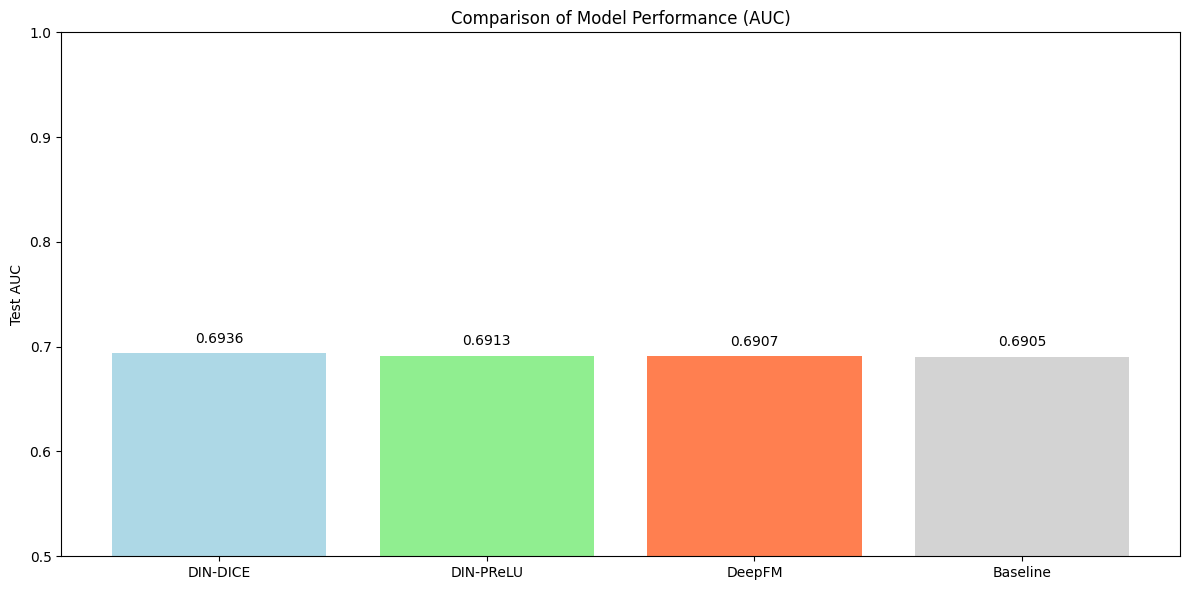

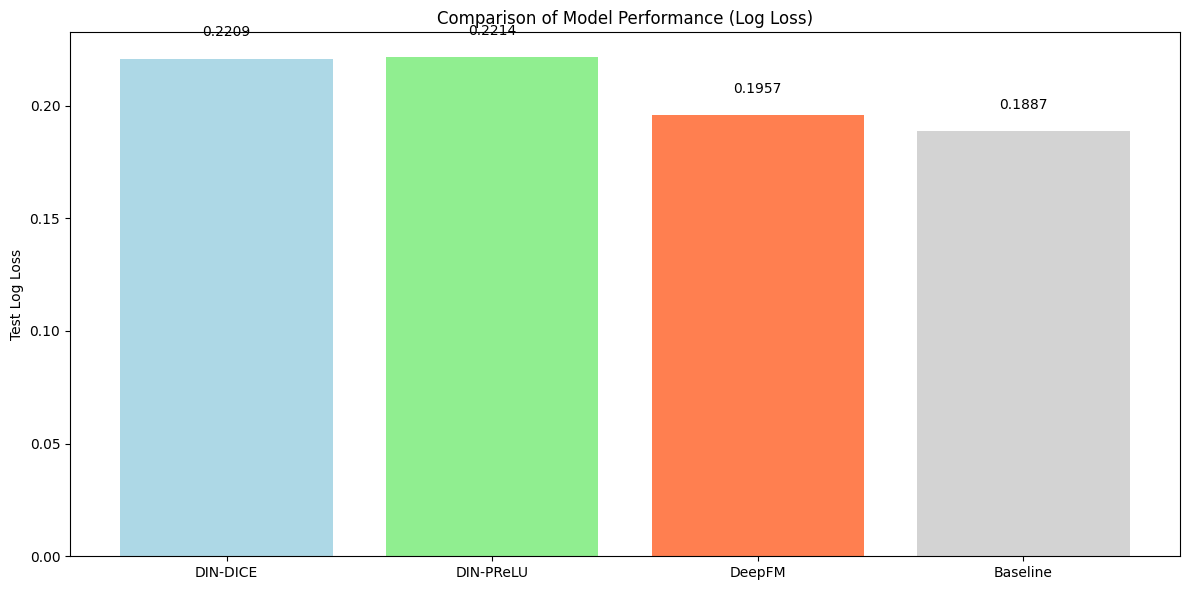

Performance comparison plots saved!
Hyperparameter tuning complete for all models!


In [ ]:
# =====================================================================
# Save All Best Parameters to One File
# =====================================================================
print("\n" + "="*60)
print("SAVING ALL BEST PARAMETERS")
print("="*60)

# Collect all best parameters
all_best_params = {
    'DIN-DICE': din_best_params,
    'DIN-PReLU': din_prelu_best_params,
    'DeepFM': deepfm_best_params,
    'Baseline': baseline_best_params
}

# Save to JSON file
with open('tuning_results/all_best_params.json', 'w') as f:
    json.dump(all_best_params, f, indent=4)

print(f"All best parameters saved to: tuning_results/all_best_params.json")

# =====================================================================
# Plot Comparison of Best Models
# =====================================================================
print("\n" + "="*60)
print("COMPARING MODEL PERFORMANCE")
print("="*60)

# Collect test metrics
models = ['DIN-DICE', 'DIN-PReLU', 'DeepFM', 'Baseline']
test_aucs = [
    din_tuning_results['best_test_auc'],
    din_prelu_tuning_results['best_test_auc'],
    deepfm_tuning_results['best_test_auc'],
    baseline_tuning_results['best_test_auc']
]
test_loglosses = [
    din_tuning_results['best_test_logloss'],
    din_prelu_tuning_results['best_test_logloss'],
    deepfm_tuning_results['best_test_logloss'],
    baseline_tuning_results['best_test_logloss']
]

# Plot AUC comparison
plt.figure(figsize=(12, 6))
plt.bar(models, test_aucs, color=['lightblue', 'lightgreen', 'coral', 'lightgray'])
plt.ylabel('Test AUC')
plt.title('Comparison of Model Performance (AUC)')
plt.ylim(0.5, 1.0)  # AUC range

# Add values above bars
for i, v in enumerate(test_aucs):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.savefig('tuning_results/model_auc_comparison.png', dpi=300)
plt.show()

# Plot Log Loss comparison
plt.figure(figsize=(12, 6))
plt.bar(models, test_loglosses, color=['lightblue', 'lightgreen', 'coral', 'lightgray'])
plt.ylabel('Test Log Loss')
plt.title('Comparison of Model Performance (Log Loss)')

# Add values above bars
for i, v in enumerate(test_loglosses):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.savefig('tuning_results/model_logloss_comparison.png', dpi=300)
plt.show()

print(f"Performance comparison plots saved!")
print(f"Hyperparameter tuning complete for all models!")

In [ ]:
# =====================================================================
# CELL 7: TRAIN ALL MODELS WITH BEST PARAMETERS
# =====================================================================

print("\n" + "="*60)
print("TRAIN ALL MODELS WITH BEST PARAMETERS")
print("="*60)

# Create best_hyperparameters.json from tuning results
import json
import os

# Option 1: If all_best_params.json exists from previous cell
if os.path.exists('tuning_results/all_best_params.json'):
    print("Loading parameters from combined results file...")
    with open('tuning_results/all_best_params.json', 'r') as f:
        best_params = json.load(f)

# Option 2: Load individual parameter files
else:
    print("Loading parameters from individual model files...")
    best_params = {}

    # DIN-DICE best parameters
    din_files = [f for f in os.listdir('tuning_results/din_dice') if f.endswith('_best_params.json')]
    if din_files:
        with open(f'tuning_results/din_dice/{din_files[0]}', 'r') as f:
            best_params['DIN-DICE'] = json.load(f)

    # DIN-PReLU best parameters
    prelu_files = [f for f in os.listdir('tuning_results/din_prelu') if f.endswith('_best_params.json')]
    if prelu_files:
        with open(f'tuning_results/din_prelu/{prelu_files[0]}', 'r') as f:
            best_params['DIN-PReLU'] = json.load(f)

    # DeepFM best parameters
    deepfm_files = [f for f in os.listdir('tuning_results/deepfm') if f.endswith('_best_params.json')]
    if deepfm_files:
        with open(f'tuning_results/deepfm/{deepfm_files[0]}', 'r') as f:
            best_params['DeepFM'] = json.load(f)

    # Baseline best parameters
    baseline_files = [f for f in os.listdir('tuning_results/baseline') if f.endswith('_best_params.json')]
    if baseline_files:
        with open(f'tuning_results/baseline/{baseline_files[0]}', 'r') as f:
            best_params['Baseline'] = json.load(f)

    # Save all parameters to a single file for future use
    with open('best_hyperparameters.json', 'w') as f:
        json.dump(best_params, f, indent=4)

    print("Combined parameters saved to 'best_hyperparameters.json'")

# Display the loaded parameters
print("\nLoaded best parameters:")
for model, params in best_params.items():
    print(f"\n{model} best parameters:")
    for param, value in params.items():
        print(f"    {param}: {value}")



TRAIN ALL MODELS WITH BEST PARAMETERS
Loading parameters from combined results file...

Loaded best parameters:

DIN-DICE best parameters:
    learning_rate: 0.0001
    batch_size: 2048
    dropout_rate: 0.4
    l2_reg: 1e-05
    l2_dense: 0.0001
    dice_alpha_init: 0.35
    dice_beta_init: 1.0
    dice_epsilon: 1e-09
    attention_hidden: 16
    label_smoothing: 0.15
    hidden_units: [128, 64]

DIN-PReLU best parameters:
    learning_rate: 0.0001
    batch_size: 2048
    dropout_rate: 0.3
    l2_reg: 5e-05
    l2_dense: 5e-05
    prelu_alpha_init: 0.35
    attention_hidden: 8
    label_smoothing: 0.15
    hidden_units: [128, 64]

DeepFM best parameters:
    learning_rate: 0.0005
    batch_size: 2048
    dropout_rate: 0.3
    l2_reg: 0.001
    l2_dense: 0.0001
    label_smoothing: 0.05
    hidden_units: [64, 32, 16]

Baseline best parameters:
    learning_rate: 0.0005
    batch_size: 2048
    dropout_rate: 0.7
    l2_reg: 1e-05
    l2_dense: 0.0001
    label_smoothing: 0.0
    hidde


TRAIN DIN-DICE WITH BEST PARAMETERS
Best Parameters for DIN-DICE:
    learning_rate: 0.0001
    batch_size: 2048
    dropout_rate: 0.4
    l2_reg: 1e-05
    l2_dense: 0.0001
    dice_alpha_init: 0.35
    dice_beta_init: 1.0
    dice_epsilon: 1e-09
    attention_hidden: 16
    label_smoothing: 0.15
    hidden_units: [128, 64]
Creating DIN-DICE model with best parameters...
Building DIN-DICE with optimal parameters:
    Attention hidden: 16
    Dropout rate: 0.4
    L2 reg: 1e-05
    L2 dense: 0.0001
    DICE α_init: 0.35
    DICE β_init: 1.0
    DICE ε: 1e-09
DIN-DICE model created successfully with optimal parameters!
Model summary:
    Total parameters: 63,660,002
    Trainable parameters: 63,659,618

Starting DIN-DICE training with best parameters...
STARTING DIN-DICE TRAINING:
  Batch size: 4096
  Epochs: 15
  Early stopping patience: 4
Epoch 1/15
  Batch 100/5188
  Batch 200/5188
  Batch 300/5188
  Batch 400/5188
  Batch 500/5188
  Batch 600/5188
  Batch 700/5188
  Batch 800/5188


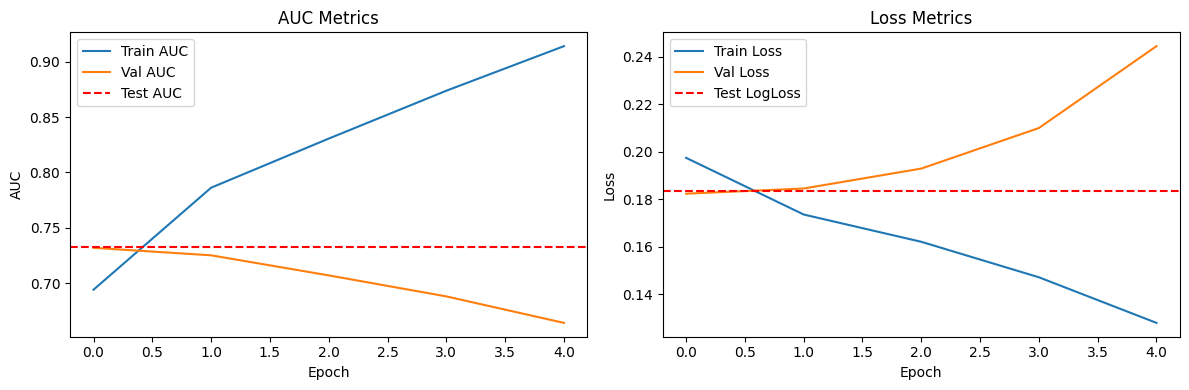

Training results saved to din_dice_training_results.csv


In [ ]:
from sklearn.metrics import log_loss

# =====================================================================
# 1. TRAIN DIN-DICE WITH BEST PARAMETERS
# =====================================================================
print("\n" + "="*60)
print("TRAIN DIN-DICE WITH BEST PARAMETERS")
print("="*60)

# Get best parameters
din_best_params = best_params['DIN-DICE']

print("Best Parameters for DIN-DICE:")
for param, value in din_best_params.items():
    print(f"    {param}: {value}")

# Create new DIN-DICE model with best parameters
def create_optimized_din_dice_model():
    """Create DIN-DICE model dengan best parameters dari tuning"""
    # Model parameters
    n_users = model_data['model_params']['n_users']
    n_items = model_data['model_params']['n_items']
    embedding_dim = 32
    hidden_units = din_best_params['hidden_units']
    attention_hidden = din_best_params['attention_hidden']
    max_seq_len = 8
    dense_feature_dim = model_data['model_params']['dense_feature_dim']
    dropout_rate = din_best_params['dropout_rate']
    l2_reg = din_best_params['l2_reg']
    l2_dense = din_best_params['l2_dense']

    print(f"Building DIN-DICE with optimal parameters:")
    print(f"    Attention hidden: {attention_hidden}")
    print(f"    Dropout rate: {dropout_rate}")
    print(f"    L2 reg: {l2_reg}")
    print(f"    L2 dense: {l2_dense}")
    print(f"    DICE α_init: {din_best_params['dice_alpha_init']}")
    print(f"    DICE β_init: {din_best_params['dice_beta_init']}")
    print(f"    DICE ε: {din_best_params['dice_epsilon']}")

    # Input layers
    user_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='user_id')
    item_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='item_id')
    sequence_input = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name='sequence')
    seq_length_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='seq_length')
    dense_input = tf.keras.layers.Input(shape=(dense_feature_dim,), dtype=tf.float32, name='dense_features')

    # EMBEDDING LAYERS
    user_embedding_layer = tf.keras.layers.Embedding(
        n_users, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
        name='user_embedding'
    )
    item_embedding_layer = tf.keras.layers.Embedding(
        n_items, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
        name='item_embedding'
    )

    # Apply embeddings
    user_emb = user_embedding_layer(user_input)
    target_item_emb = item_embedding_layer(item_input)
    sequence_emb = item_embedding_layer(sequence_input)

    # DIN Attention mechanism
    attention_scores, attended_emb = DINAttention(
        hidden_units=attention_hidden,
        max_seq_len=max_seq_len,
        activation_type='dice',  # Tambahkan parameter ini
        dice_alpha_init=din_best_params['dice_alpha_init'],  # Tambahkan parameter ini
        dice_beta_init=din_best_params['dice_beta_init'],    # Tambahkan parameter ini
        dice_epsilon=din_best_params['dice_epsilon'],        # Tambahkan parameter ini
        name='din_attention'
    )([sequence_emb, target_item_emb])

    # Sequence pooling
    pooled_sequence = SequencePooling(name='sequence_pooling')(
        [attention_scores, attended_emb, seq_length_input]
    )

    # Feature concatenation
    all_features = tf.keras.layers.Concatenate(name='feature_concat')([
        user_emb,
        target_item_emb,
        pooled_sequence,
        dense_input
    ])

    # DEEP NETWORK dengan DICE activation
    x = all_features
    for i, units in enumerate(hidden_units):
        x = tf.keras.layers.Dense(
            units,
            name=f'dense_{i+1}',
            kernel_regularizer=tf.keras.regularizers.l2(l2_dense)
        )(x)

        # DICE activation dengan parameter optimal
        dice = DiceActivation(
            name=f'dice_{i+1}',
            alpha_init=din_best_params['dice_alpha_init'],
            beta_init=din_best_params['dice_beta_init'],
            epsilon=din_best_params['dice_epsilon']
        )
        x = dice(x)

        x = tf.keras.layers.Dropout(dropout_rate, name=f'dropout_{i+1}')(x)
        x = tf.keras.layers.BatchNormalization(name=f'bn_{i+1}')(x)

    # OUTPUT LAYER
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output',
                                 kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)

    # Create model
    model = tf.keras.Model(
        inputs=[user_input, item_input, sequence_input, seq_length_input, dense_input],
        outputs=output,
        name='din_dice_optimized'
    )

    return model

# Create DIN-DICE model with best parameters
print(f"Creating DIN-DICE model with best parameters...")
din_dice_model = create_optimized_din_dice_model()

# Compile DIN-DICE model with best parameters
optimizer = tf.keras.optimizers.Adam(
    learning_rate=din_best_params['learning_rate'],
    beta_1=0.9, beta_2=0.999, epsilon=1e-8,
    clipnorm=0.5
)
metrics = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# LOSS dengan label smoothing optimal
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=din_best_params['label_smoothing'])

din_dice_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

print(f"DIN-DICE model created successfully with optimal parameters!")
print(f"Model summary:")
print(f"    Total parameters: {din_dice_model.count_params():,}")
print(f"    Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in din_dice_model.trainable_weights]):,}")

# Run manual training with best parameters
print(f"\nStarting DIN-DICE training with best parameters...")
din_dice_results = manual_training_loop_din_dice(
    model=din_dice_model,
    batch_size=4096,
    save_csv=True
)


TRAIN DIN-PRELU WITH BEST PARAMETERS
Best Parameters for DIN-PReLU:
    learning_rate: 0.0001
    batch_size: 2048
    dropout_rate: 0.3
    l2_reg: 5e-05
    l2_dense: 5e-05
    prelu_alpha_init: 0.35
    attention_hidden: 8
    label_smoothing: 0.15
    hidden_units: [128, 64]
Creating DIN-PReLU model with best parameters...
Building DIN-PReLU with optimal parameters:
    Attention hidden: 8
    Dropout rate: 0.3
    L2 reg: 5e-05
    L2 dense: 5e-05
    PReLU α_init: 0.35
DIN-PReLU model created successfully with optimal parameters!
Model summary:
    Total parameters: 63,658,578
    Trainable parameters: 63,658,194

Starting DIN-PReLU training with best parameters...
STARTING DIN-PReLU TRAINING:
  Batch size: 4096
  Epochs: 15
  Early stopping patience: 4
  Test set evaluation: Only at end of training
Epoch 1/15
  Batch 100/5188
  Batch 200/5188
  Batch 300/5188
  Batch 400/5188
  Batch 500/5188
  Batch 600/5188
  Batch 700/5188
  Batch 800/5188
  Batch 900/5188
  Batch 1000/5188


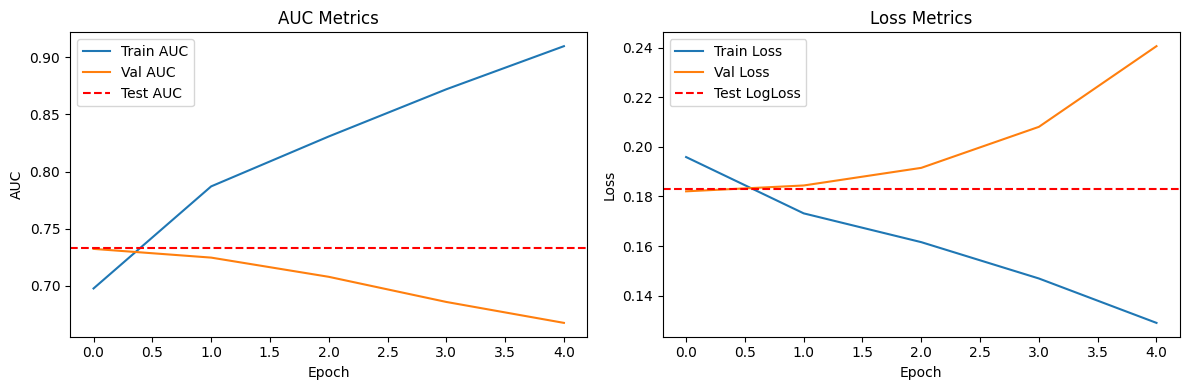

Training results saved to din_prelu_training_results.csv


In [ ]:
# =====================================================================
# 2. TRAIN DIN-PRELU WITH BEST PARAMETERS
# =====================================================================
print("\n" + "="*60)
print("TRAIN DIN-PRELU WITH BEST PARAMETERS")
print("="*60)

# Get best parameters
din_prelu_best_params = best_params['DIN-PReLU']

print("Best Parameters for DIN-PReLU:")
for param, value in din_prelu_best_params.items():
    print(f"    {param}: {value}")

# Create new DIN-PReLU model with best parameters
def create_optimized_din_prelu_model():
    """Create DIN-PReLU model dengan best parameters dari tuning"""
    # Model parameters
    n_users = model_data['model_params']['n_users']
    n_items = model_data['model_params']['n_items']
    embedding_dim = 32
    hidden_units = din_prelu_best_params['hidden_units']
    attention_hidden = din_prelu_best_params['attention_hidden']
    max_seq_len = 8
    dense_feature_dim = model_data['model_params']['dense_feature_dim']
    dropout_rate = din_prelu_best_params['dropout_rate']
    l2_reg = din_prelu_best_params['l2_reg']
    l2_dense = din_prelu_best_params['l2_dense']

    print(f"Building DIN-PReLU with optimal parameters:")
    print(f"    Attention hidden: {attention_hidden}")
    print(f"    Dropout rate: {dropout_rate}")
    print(f"    L2 reg: {l2_reg}")
    print(f"    L2 dense: {l2_dense}")
    print(f"    PReLU α_init: {din_prelu_best_params['prelu_alpha_init']}")

    # Input layers
    user_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='user_id')
    item_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='item_id')
    sequence_input = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name='sequence')
    seq_length_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='seq_length')
    dense_input = tf.keras.layers.Input(shape=(dense_feature_dim,), dtype=tf.float32, name='dense_features')

    # EMBEDDING LAYERS
    user_embedding_layer = tf.keras.layers.Embedding(
        n_users, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
        name='user_embedding'
    )
    item_embedding_layer = tf.keras.layers.Embedding(
        n_items, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
        name='item_embedding'
    )

    # Apply embeddings
    user_emb = user_embedding_layer(user_input)
    target_item_emb = item_embedding_layer(item_input)
    sequence_emb = item_embedding_layer(sequence_input)

    # DIN Attention mechanism
    attention_scores, attended_emb = DINAttention(
        hidden_units=attention_hidden,
        max_seq_len=max_seq_len,
        activation_type='prelu',  # Tambahkan parameter ini
        prelu_alpha_init=din_prelu_best_params['prelu_alpha_init'],  # Tambahkan parameter ini
        name='din_attention'
    )([sequence_emb, target_item_emb])

    # Sequence pooling
    pooled_sequence = SequencePooling(name='sequence_pooling')(
        [attention_scores, attended_emb, seq_length_input]
    )

    # Feature concatenation
    all_features = tf.keras.layers.Concatenate(name='feature_concat')([
        user_emb,
        target_item_emb,
        pooled_sequence,
        dense_input
    ])

    # DEEP NETWORK dengan PReLU activation
    x = all_features
    for i, units in enumerate(hidden_units):
        x = tf.keras.layers.Dense(
            units,
            name=f'dense_{i+1}',
            kernel_regularizer=tf.keras.regularizers.l2(l2_dense)
        )(x)

        # PReLU activation dengan parameter optimal
        x = tf.keras.layers.PReLU(
            alpha_initializer=tf.keras.initializers.Constant(din_prelu_best_params['prelu_alpha_init']),
            name=f'prelu_{i+1}'
        )(x)

        x = tf.keras.layers.Dropout(dropout_rate, name=f'dropout_{i+1}')(x)
        x = tf.keras.layers.BatchNormalization(name=f'bn_{i+1}')(x)

    # OUTPUT LAYER
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output',
                                 kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)

    # Create model
    model = tf.keras.Model(
        inputs=[user_input, item_input, sequence_input, seq_length_input, dense_input],
        outputs=output,
        name='din_prelu_optimized'
    )

    return model

# Create DIN-PReLU model with best parameters
print(f"Creating DIN-PReLU model with best parameters...")
din_prelu_model = create_optimized_din_prelu_model()

# Compile DIN-PReLU model with best parameters
optimizer = tf.keras.optimizers.Adam(
    learning_rate=din_prelu_best_params['learning_rate'],
    beta_1=0.9, beta_2=0.999, epsilon=1e-8,
    clipnorm=0.5
)
metrics = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# LOSS dengan label smoothing optimal
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=din_prelu_best_params['label_smoothing'])

din_prelu_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

print(f"DIN-PReLU model created successfully with optimal parameters!")
print(f"Model summary:")
print(f"    Total parameters: {din_prelu_model.count_params():,}")
print(f"    Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in din_prelu_model.trainable_weights]):,}")

# Run manual training with best parameters
print(f"\nStarting DIN-PReLU training with best parameters...")
din_prelu_results = manual_training_loop_din_prelu(
    model=din_prelu_model,
    batch_size=4096,
    save_csv=True
)




TRAIN DEEPFM WITH BEST PARAMETERS
Best Parameters for DeepFM:
    learning_rate: 0.0005
    batch_size: 2048
    dropout_rate: 0.3
    l2_reg: 0.001
    l2_dense: 0.0001
    label_smoothing: 0.05
    hidden_units: [64, 32, 16]
Creating DeepFM model with best parameters...
Building DeepFM with optimal parameters:
    Hidden units: [64, 32, 16]
    Dropout rate: 0.3
    L2 reg: 0.001
    L2 dense: 0.0001
Creating DeepFM dataset...
DeepFM model created successfully with optimal parameters!
Model summary:
    Total parameters: 63,643,189
    Trainable parameters: 63,642,965

Starting DeepFM training with best parameters...
STARTING DEEPFM TRAINING:
  Batch size: 2048
  Epochs: 15
  Early stopping patience: 4
  Test set evaluation: Only at end of training
Creating DeepFM dataset...
Epoch 1/15
10375/10375 ━━━━━━━━━━━━━━━━━━━━ 184s 17ms/step - auc: 0.6061 - loss: 1.2937 - precision: 0.0762 - recall: 0.0566 - val_auc: 0.6911 - val_loss: 0.2547 - val_precision: 0.6633 - val_recall: 0.0121
Epoc

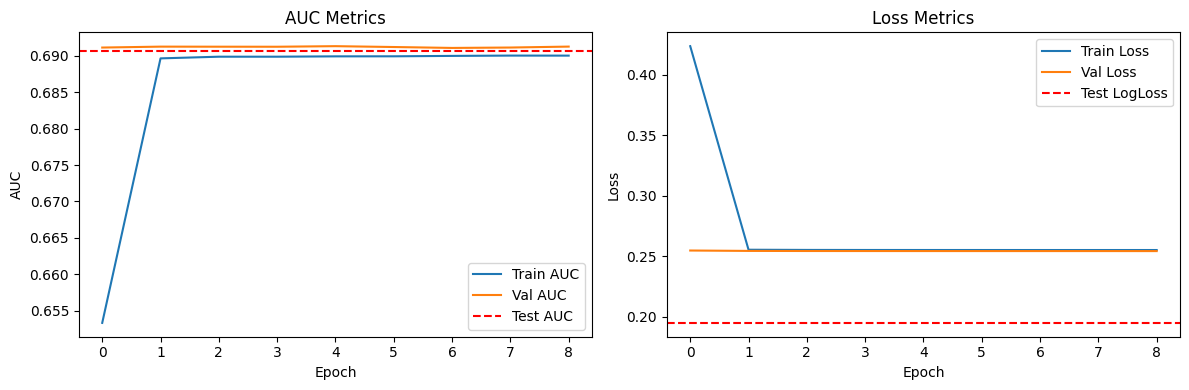

Training results saved to deepfm_training_results.csv


In [ ]:
# =====================================================================
# 3. TRAIN DEEPFM WITH BEST PARAMETERS
# =====================================================================
print("\n" + "="*60)
print("TRAIN DEEPFM WITH BEST PARAMETERS")
print("="*60)

# Get best parameters
deepfm_best_params = best_params['DeepFM']

print("Best Parameters for DeepFM:")
for param, value in deepfm_best_params.items():
    print(f"    {param}: {value}")

# Create new DeepFM model with best parameters
def create_optimized_deepfm_model():
    """Create DeepFM model with best parameters"""
    # Model parameters
    n_users = model_data['model_params']['n_users']
    n_items = model_data['model_params']['n_items']
    embedding_dim = 32
    hidden_units = deepfm_best_params['hidden_units']
    dense_feature_dim = model_data['model_params']['dense_feature_dim']
    dropout_rate = deepfm_best_params['dropout_rate']
    l2_reg = deepfm_best_params['l2_reg']
    l2_dense = deepfm_best_params['l2_dense']

    print(f"Building DeepFM with optimal parameters:")
    print(f"    Hidden units: {hidden_units}")
    print(f"    Dropout rate: {dropout_rate}")
    print(f"    L2 reg: {l2_reg}")
    print(f"    L2 dense: {l2_dense}")

    # Input layers
    user_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='user_id')
    item_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='item_id')
    dense_input = tf.keras.layers.Input(shape=(dense_feature_dim,), dtype=tf.float32, name='dense_features')

    # EMBEDDING LAYERS
    user_embedding_layer = tf.keras.layers.Embedding(
        n_users, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
        name='user_embedding'
    )
    item_embedding_layer = tf.keras.layers.Embedding(
        n_items, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
        name='item_embedding'
    )

    # Apply embeddings
    user_emb = user_embedding_layer(user_input)
    item_emb = item_embedding_layer(item_input)

    # FM PART: Factorization Machine component

    # LINEAR PART
    user_linear = tf.keras.layers.Dense(1, use_bias=False, name='user_linear',
                                      kernel_regularizer=tf.keras.regularizers.l2(l2_dense))(user_emb)
    item_linear = tf.keras.layers.Dense(1, use_bias=False, name='item_linear',
                                      kernel_regularizer=tf.keras.regularizers.l2(l2_dense))(item_emb)
    dense_linear = tf.keras.layers.Dense(1, use_bias=False, name='dense_linear',
                                       kernel_regularizer=tf.keras.regularizers.l2(l2_dense))(dense_input)

    # INTERACTION PART
    # User-Item interaction
    user_item_interaction = tf.keras.layers.Multiply(name='user_item_mult')([user_emb, item_emb])

    # User-Dense interaction
    user_dense_proj = tf.keras.layers.Dense(embedding_dim, name='user_dense_proj',
                                          kernel_regularizer=tf.keras.regularizers.l2(l2_dense))(dense_input)
    user_dense_interaction = tf.keras.layers.Multiply(name='user_dense_mult')([user_emb, user_dense_proj])

    # Item-Dense interaction
    item_dense_proj = tf.keras.layers.Dense(embedding_dim, name='item_dense_proj',
                                          kernel_regularizer=tf.keras.regularizers.l2(l2_dense))(dense_input)
    item_dense_interaction = tf.keras.layers.Multiply(name='item_dense_mult')([item_emb, item_dense_proj])

    # Sum all interactions
    fm_interactions = tf.keras.layers.Add(name='fm_interactions')([
        user_item_interaction,
        user_dense_interaction,
        item_dense_interaction
    ])
    fm_interaction_sum = tf.keras.layers.Dense(1, name='fm_interaction_sum',
                                             kernel_regularizer=tf.keras.regularizers.l2(l2_dense))(fm_interactions)

    # FM output
    fm_output = tf.keras.layers.Add(name='fm_output')([
        user_linear,
        item_linear,
        dense_linear,
        fm_interaction_sum
    ])

    # DEEP PART: Deep Neural Network component

    # Concatenate all features untuk deep part
    deep_features = tf.keras.layers.Concatenate(name='deep_features')([
        user_emb,
        item_emb,
        dense_input
    ])

    # DEEP NETWORK
    x = deep_features
    for i, units in enumerate(hidden_units):
        x = tf.keras.layers.Dense(
            units,
            activation='relu',
            name=f'deep_dense_{i+1}',
            kernel_regularizer=tf.keras.regularizers.l2(l2_dense)
        )(x)
        x = tf.keras.layers.Dropout(dropout_rate, name=f'deep_dropout_{i+1}')(x)
        x = tf.keras.layers.BatchNormalization(name=f'deep_bn_{i+1}')(x)

    # DEEP OUTPUT
    deep_output = tf.keras.layers.Dense(1, name='deep_output',
                                      kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)

    # COMBINE FM + DEEP
    combined_output = tf.keras.layers.Add(name='fm_deep_combine')([fm_output, deep_output])

    # Final activation
    final_output = tf.keras.layers.Activation('sigmoid', name='final_output')(combined_output)

    # Create model
    model = tf.keras.Model(
        inputs=[user_input, item_input, dense_input],
        outputs=final_output,
        name='deepfm_optimized'
    )

    return model

# Create DeepFM model with best parameters
print(f"Creating DeepFM model with best parameters...")
deepfm_model = create_optimized_deepfm_model()

# Create DeepFM dataset
deepfm_data = create_deepfm_dataset()

# Compile DeepFM model with best parameters
optimizer = tf.keras.optimizers.Adam(
    learning_rate=deepfm_best_params['learning_rate'],
    beta_1=0.9, beta_2=0.999, epsilon=1e-8,
    clipnorm=0.5
)
metrics = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# LOSS dengan label smoothing optimal
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=deepfm_best_params['label_smoothing'])

deepfm_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

print(f"DeepFM model created successfully with optimal parameters!")
print(f"Model summary:")
print(f"    Total parameters: {deepfm_model.count_params():,}")
print(f"    Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in deepfm_model.trainable_weights]):,}")

# Train DeepFM with best parameters
print(f"\nStarting DeepFM training with best parameters...")
deepfm_results = train_deepfm_model(
    model=deepfm_model,
    batch_size=deepfm_best_params['batch_size'],
    save_csv=True
)


TRAIN BASELINE WITH BEST PARAMETERS
Best Parameters for Baseline:
    learning_rate: 0.0005
    batch_size: 2048
    dropout_rate: 0.7
    l2_reg: 1e-05
    l2_dense: 0.0001
    label_smoothing: 0.0
    hidden_units: [64, 32]
Creating Baseline model with best parameters...
Building Baseline with optimal parameters:
    Hidden units: [64, 32]
    Dropout rate: 0.7
    L2 reg: 1e-05
    L2 dense: 0.0001
Creating Baseline dataset...
Baseline model created successfully with optimal parameters!
Model summary:
    Total parameters: 63,641,217
    Trainable parameters: 63,641,025

Starting Baseline training with best parameters...
STARTING BASELINE TRAINING:
  Batch size: 2048
  Epochs: 15
  Early stopping patience: 4
  Test set evaluation: Only at end of training
Creating Baseline dataset...
Epoch 1/15
10375/10375 ━━━━━━━━━━━━━━━━━━━━ 171s 16ms/step - auc: 0.6044 - loss: 0.2757 - precision: 0.0756 - recall: 0.0483 - val_auc: 0.6913 - val_loss: 0.1879 - val_precision: 0.9474 - val_recall: 0.

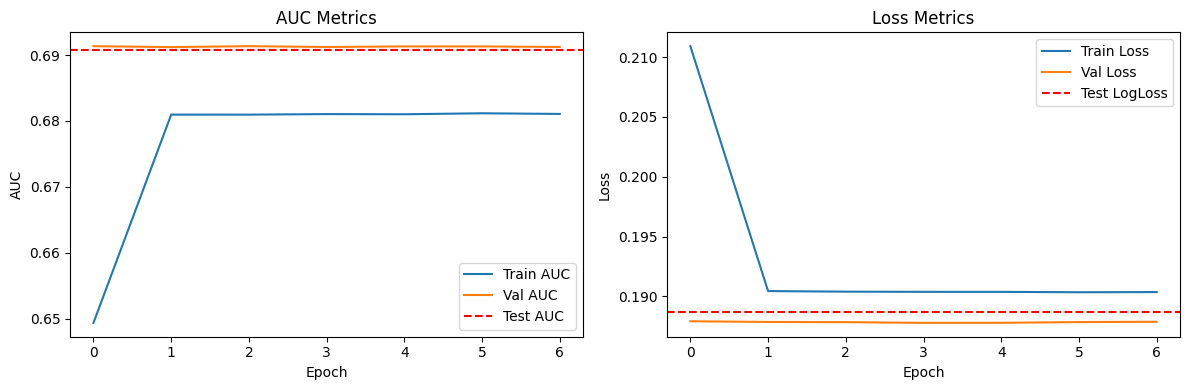

Training results saved to baseline_training_results.csv


In [ ]:
# =====================================================================
# 4. TRAIN BASELINE WITH BEST PARAMETERS
# =====================================================================
print("\n" + "="*60)
print("TRAIN BASELINE WITH BEST PARAMETERS")
print("="*60)

# Get best parameters
baseline_best_params = best_params['Baseline']

print("Best Parameters for Baseline:")
for param, value in baseline_best_params.items():
    print(f"    {param}: {value}")

# Create new Baseline model with best parameters
def create_optimized_baseline_model():
    """Create Baseline model with best parameters"""
    # Model parameters
    n_users = model_data['model_params']['n_users']
    n_items = model_data['model_params']['n_items']
    embedding_dim = 32
    hidden_units = baseline_best_params['hidden_units']
    dense_feature_dim = model_data['model_params']['dense_feature_dim']
    dropout_rate = baseline_best_params['dropout_rate']
    l2_reg = baseline_best_params['l2_reg']
    l2_dense = baseline_best_params['l2_dense']

    print(f"Building Baseline with optimal parameters:")
    print(f"    Hidden units: {hidden_units}")
    print(f"    Dropout rate: {dropout_rate}")
    print(f"    L2 reg: {l2_reg}")
    print(f"    L2 dense: {l2_dense}")

    # Input layers
    user_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='user_id')
    item_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='item_id')
    dense_input = tf.keras.layers.Input(shape=(dense_feature_dim,), dtype=tf.float32, name='dense_features')

    # EMBEDDING LAYERS
    user_embedding_layer = tf.keras.layers.Embedding(
        n_users, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
        name='user_embedding'
    )
    item_embedding_layer = tf.keras.layers.Embedding(
        n_items, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
        name='item_embedding'
    )

    # Apply embeddings
    user_emb = user_embedding_layer(user_input)
    item_emb = item_embedding_layer(item_input)

    # Simple feature concatenation
    all_features = tf.keras.layers.Concatenate(name='feature_concat')([
        user_emb,
        item_emb,
        dense_input
    ])

    # FEEDFORWARD NETWORK
    x = all_features
    for i, units in enumerate(hidden_units):
        x = tf.keras.layers.Dense(
            units,
            activation='relu',
            name=f'dense_{i+1}',
            kernel_regularizer=tf.keras.regularizers.l2(l2_dense)
        )(x)
        x = tf.keras.layers.Dropout(dropout_rate, name=f'dropout_{i+1}')(x)
        x = tf.keras.layers.BatchNormalization(name=f'bn_{i+1}')(x)

    # OUTPUT LAYER
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output',
                                 kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)

    # Create model
    model = tf.keras.Model(
        inputs=[user_input, item_input, dense_input],
        outputs=output,
        name='baseline_optimized'
    )

    return model

# Create Baseline model with best parameters
print(f"Creating Baseline model with best parameters...")
baseline_model = create_optimized_baseline_model()

# Create Baseline dataset
baseline_data = create_baseline_dataset()

# Compile Baseline model with best parameters
optimizer = tf.keras.optimizers.Adam(
    learning_rate=baseline_best_params['learning_rate'],
    beta_1=0.9, beta_2=0.999, epsilon=1e-8,
    clipnorm=0.5
)
metrics = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# LOSS dengan label smoothing optimal
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=baseline_best_params['label_smoothing'])

baseline_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

print(f"Baseline model created successfully with optimal parameters!")
print(f"Model summary:")
print(f"    Total parameters: {baseline_model.count_params():,}")
print(f"    Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in baseline_model.trainable_weights]):,}")

# Train Baseline with best parameters
print(f"\nStarting Baseline training with best parameters...")
baseline_results = train_baseline_model(
    model=baseline_model,
    batch_size=baseline_best_params['batch_size'],
    save_csv=True
)


OVERALL TRAINING SUMMARY WITH BEST PARAMETERS

OPTIMIZED MODELS PERFORMANCE SUMMARY:
       Model Val AUC Test AUC Test LogLoss Training Time  Parameters
0   DIN-DICE  0.7321   0.7325       0.1834       6738.3s  63,660,002
1  DIN-PReLU  0.7324   0.7328       0.1831       5890.4s  63,658,578
2     DeepFM  0.6913   0.6907       0.1949       1527.5s  63,643,189
3   Baseline  0.6913   0.6908       0.1887       1141.2s  63,641,217

Summary saved to training_summary_optimized.csv


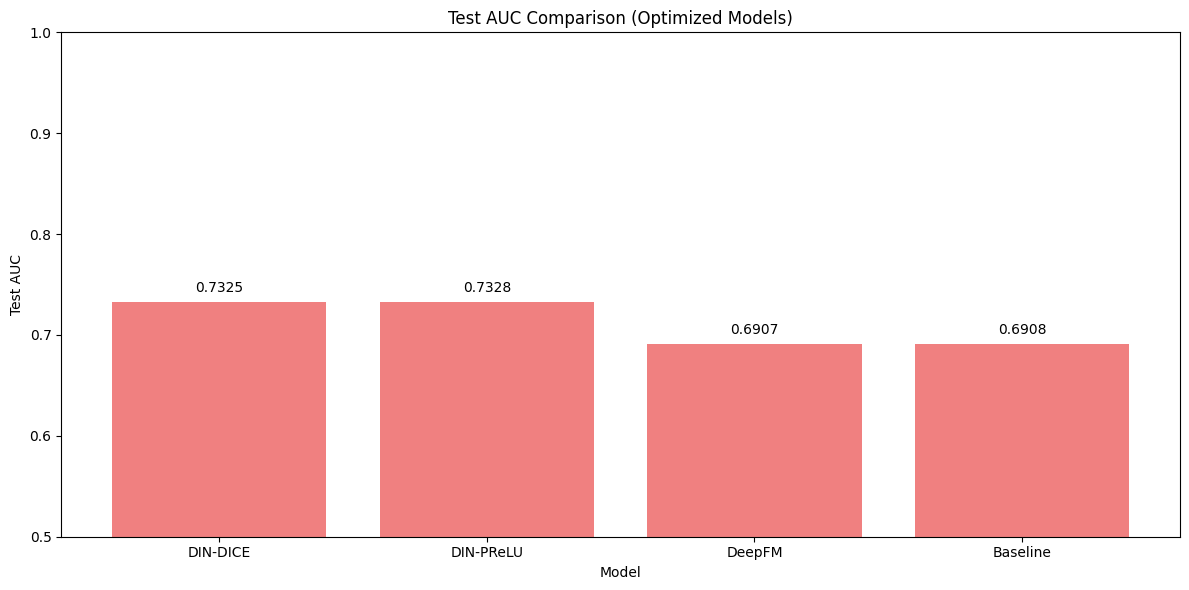

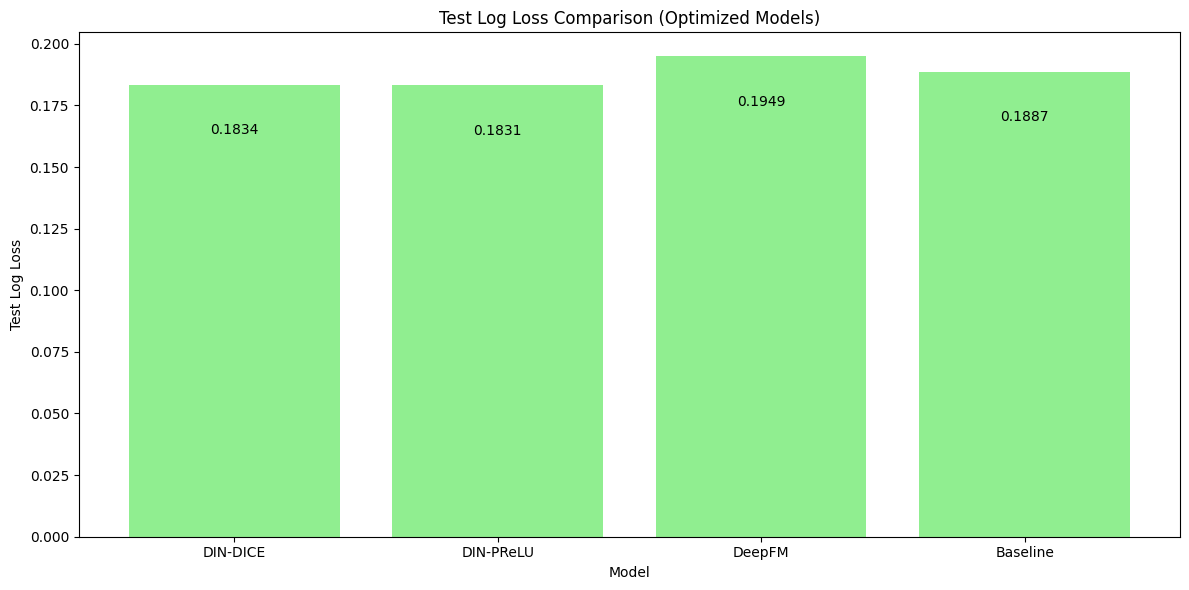


TRAINING COMPLETED FOR ALL OPTIMIZED MODELS!

The hyperparameter tuning and optimized training process has been completed.
All models have been trained with their best parameters from hyperparameter tuning.
The results show both validation and test performance metrics.
The best model based on test AUC is: DIN-PReLU
The best model based on test LogLoss is: DIN-PReLU


In [ ]:
# =====================================================================
# OVERALL TRAINING SUMMARY
# =====================================================================
print("\n" + "="*60)
print("OVERALL TRAINING SUMMARY WITH BEST PARAMETERS")
print("="*60)

# Create a comparison table of results
training_summary = {
    'Model': [],
    'Val AUC': [],
    'Test AUC': [],
    'Test LogLoss': [],
    'Training Time': [],
    'Parameters': []
}

if 'din_dice_results' in locals() and din_dice_results.get('success'):
    training_summary['Model'].append('DIN-DICE')
    training_summary['Val AUC'].append(f"{din_dice_results['best_val_auc']:.4f}")
    training_summary['Test AUC'].append(f"{din_dice_results['best_test_auc']:.4f}")
    training_summary['Test LogLoss'].append(f"{din_dice_results['best_test_logloss']:.4f}")
    training_summary['Training Time'].append(f"{din_dice_results['training_time']:.1f}s")
    training_summary['Parameters'].append(f"{din_dice_model.count_params():,}")

if 'din_prelu_results' in locals() and din_prelu_results.get('success'):
    training_summary['Model'].append('DIN-PReLU')
    training_summary['Val AUC'].append(f"{din_prelu_results['best_val_auc']:.4f}")
    training_summary['Test AUC'].append(f"{din_prelu_results['best_test_auc']:.4f}")
    training_summary['Test LogLoss'].append(f"{din_prelu_results['best_test_logloss']:.4f}")
    training_summary['Training Time'].append(f"{din_prelu_results['training_time']:.1f}s")
    training_summary['Parameters'].append(f"{din_prelu_model.count_params():,}")

if 'deepfm_results' in locals() and deepfm_results.get('success'):
    training_summary['Model'].append('DeepFM')
    training_summary['Val AUC'].append(f"{deepfm_results['best_val_auc']:.4f}")
    training_summary['Test AUC'].append(f"{deepfm_results['best_test_auc']:.4f}")
    training_summary['Test LogLoss'].append(f"{deepfm_results['best_test_logloss']:.4f}")
    training_summary['Training Time'].append(f"{deepfm_results['training_time']:.1f}s")
    training_summary['Parameters'].append(f"{deepfm_model.count_params():,}")

if 'baseline_results' in locals() and baseline_results.get('success'):
    training_summary['Model'].append('Baseline')
    training_summary['Val AUC'].append(f"{baseline_results['best_val_auc']:.4f}")
    training_summary['Test AUC'].append(f"{baseline_results['best_test_auc']:.4f}")
    training_summary['Test LogLoss'].append(f"{baseline_results['best_test_logloss']:.4f}")
    training_summary['Training Time'].append(f"{baseline_results['training_time']:.1f}s")
    training_summary['Parameters'].append(f"{baseline_model.count_params():,}")

# Display summary table
training_df = pd.DataFrame(training_summary)
print("\nOPTIMIZED MODELS PERFORMANCE SUMMARY:")
print(training_df)

# Save summary to CSV
summary_path = "training_summary_optimized.csv"
training_df.to_csv(summary_path, index=False)
print(f"\nSummary saved to {summary_path}")

# Create a comparison plot for Test AUC
plt.figure(figsize=(12, 6))
models = training_summary['Model']
test_aucs = [float(auc) for auc in training_summary['Test AUC']]
plt.bar(models, test_aucs, color='lightcoral')
plt.title('Test AUC Comparison (Optimized Models)')
plt.xlabel('Model')
plt.ylabel('Test AUC')
plt.ylim(0.5, 1.0)

# Add value labels
for i, v in enumerate(test_aucs):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.savefig('test_auc_comparison_optimized.png', dpi=300)
plt.show()

# Create a comparison plot for Test LogLoss
plt.figure(figsize=(12, 6))
test_logloss = [float(loss) for loss in training_summary['Test LogLoss']]
plt.bar(models, test_logloss, color='lightgreen')
plt.title('Test Log Loss Comparison (Optimized Models)')
plt.xlabel('Model')
plt.ylabel('Test Log Loss')

# Add value labels
for i, v in enumerate(test_logloss):
    plt.text(i, v - 0.02, f'{v:.4f}', ha='center', color='black')

plt.tight_layout()
plt.savefig('test_logloss_comparison_optimized.png', dpi=300)
plt.show()

# Final Output
print("\n" + "="*60)
print("TRAINING COMPLETED FOR ALL OPTIMIZED MODELS!")
print("="*60)

print("\nThe hyperparameter tuning and optimized training process has been completed.")
print("All models have been trained with their best parameters from hyperparameter tuning.")
print("The results show both validation and test performance metrics.")
print("The best model based on test AUC is:", training_summary['Model'][np.argmax(test_aucs)])
print("The best model based on test LogLoss is:", training_summary['Model'][np.argmin(test_logloss)])

In [ ]:
# =====================================================================
# CELL 8: MODEL EVALUATION & TESTING (SIMPLIFIED METRICS)
# =====================================================================

print("\n" + "="*60)
print("CELL 8: MODEL EVALUATION & TESTING (SIMPLIFIED METRICS)")
print("="*60)

# Import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from datetime import datetime

# Add required sklearn imports
from sklearn.metrics import roc_auc_score, log_loss

def comprehensive_model_evaluation():
    """Comprehensive evaluation of all trained models focusing on AUC, Log Loss, and AUC-based RelaImpr"""

    # Current timestamp and user information
    current_timestamp = "-"
    current_user = "Muhammad Sultan Nurrochman"

    print("📊 Starting simplified model evaluation...")

    # Collect all trained models
    trained_models = {}

    # Check DIN-DICE
    if 'din_dice_model' in globals() and 'din_dice_results' in globals():
        trained_models['DIN-DICE (Optimized)'] = {
            'model': din_dice_model,
            'results': din_dice_results,
            'data_format': 'sequences'
        }
        print("DIN-DICE model found")

    # Check DIN-PReLU
    if 'din_prelu_model' in globals() and 'din_prelu_results' in globals():
        trained_models['DIN-PReLU (Optimized)'] = {
            'model': din_prelu_model,
            'results': din_prelu_results,
            'data_format': 'sequences'
        }
        print("DIN-PReLU model found")

    # Check DeepFM
    if 'deepfm_model' in globals() and 'deepfm_results' in globals():
        trained_models['DeepFM'] = {
            'model': deepfm_model,
            'results': deepfm_results,
            'data_format': 'simple'
        }
        print("DeepFM model found")

    # Check Baseline
    if 'baseline_model' in globals() and 'baseline_results' in globals():
        trained_models['Baseline'] = {
            'model': baseline_model,
            'results': baseline_results,
            'data_format': 'simple'
        }
        print("Baseline model found")

    if not trained_models:
        print("❌ No trained models found! Please run training cells first.")
        return {'success': False, 'error': 'No trained models available'}

    print(f"Found {len(trained_models)} trained models: {list(trained_models.keys())}")

    # Prepare test data
    test_data = model_data['splits']['test']

    # Test data for sequence models (DIN variants)
    test_data_sequences = {
        'user_id': test_data['user_ids'],
        'item_id': test_data['item_ids'],
        'sequence': test_data['sequences'],
        'seq_length': test_data['seq_lengths'],
        'dense_features': test_data['dense_features']
    }

    # Test data for simple models (DeepFM, Baseline)
    test_data_simple = {
        'user_id': test_data['user_ids'],
        'item_id': test_data['item_ids'],
        'dense_features': test_data['dense_features']
    }

    test_labels = test_data['labels'].flatten()

    print(f"Test dataset info:")
    print(f"    Test samples: {len(test_labels):,}")
    print(f"    Test CTR: {test_labels.mean():.4f}")
    print(f"    Positive samples: {test_labels.sum():,}")
    print(f"    Negative samples: {len(test_labels) - test_labels.sum():,}")

    # Evaluation results storage
    evaluation_results = {}

    print(f"\n🔍 Starting model evaluations...")

    # Evaluate each model
    for model_name, model_info in trained_models.items():
        print(f"\n{'='*60}")
        print(f"🔍 Evaluating {model_name}")
        print(f"{'='*60}")

        model = model_info['model']
        data_format = model_info['data_format']

        try:
            # Select appropriate test data format
            if data_format == 'sequences':
                test_x = test_data_sequences
            else:
                test_x = test_data_simple

            print(f"Model info:")
            print(f"    Parameters: {model.count_params():,}")
            print(f"    Data format: {data_format}")

            # Make predictions
            print(f"Making predictions...")
            start_time = time.time()

            predictions = model.predict(test_x, batch_size=512, verbose=0)
            predictions = predictions.flatten()

            prediction_time = time.time() - start_time

            # Calculate key metrics
            print(f"Calculating key metrics: AUC and Log Loss...")

            # AUC
            auc_score = tf.keras.metrics.AUC()
            auc_score.update_state(test_labels, predictions)
            auc = auc_score.result().numpy()

            # ROC AUC (using sklearn for validation)
            roc_auc = roc_auc_score(test_labels, predictions)

            # Log Loss
            log_loss_val = tf.keras.losses.BinaryCrossentropy()(test_labels, predictions).numpy()

            # Store results
            evaluation_results[model_name] = {
                'auc': auc,
                'roc_auc': roc_auc,
                'log_loss': log_loss_val,
                'prediction_time': prediction_time,
                'model_params': model.count_params(),
                'validation_auc': model_info['results']['best_val_auc'],
                'training_time': model_info['results']['training_time'],
                'success': True
            }

            # Print results
            print(f"{model_name} Evaluation Results:")
            print(f"    AUC: {auc:.4f}")
            print(f"    ROC AUC (sklearn): {roc_auc:.4f}")
            print(f"    Log Loss: {log_loss_val:.4f}")
            print(f"    Prediction Time: {prediction_time:.2f}s")
            print(f"    Model Parameters: {model.count_params():,}")
            print(f"    Validation AUC: {model_info['results']['best_val_auc']:.4f}")

        except Exception as e:
            print(f"❌ Error evaluating {model_name}: {e}")
            evaluation_results[model_name] = {'success': False, 'error': str(e)}
            import traceback
            traceback.print_exc()

    # Calculate the relative improvement over baseline based on AUC
    if 'Baseline' in evaluation_results and evaluation_results['Baseline'].get('success'):
        baseline_auc = evaluation_results['Baseline']['auc']

        for model_name, results in evaluation_results.items():
            if results.get('success'):
                # Calculate RelaImpr as AUC improvement over baseline
                if model_name != 'Baseline':
                    model_auc = results['auc']
                    # RelaImpr as percentage improvement over baseline AUC
                    auc_relaimpr = ((model_auc / baseline_auc) - 1) * 100 if baseline_auc > 0 else 0
                else:
                    # Baseline has 0% improvement over itself
                    auc_relaimpr = 0.0

                evaluation_results[model_name]['relaimpr'] = auc_relaimpr

    # Create results directory
    os.makedirs('evaluation_results', exist_ok=True)

    # Prepare data for CSV export
    results_for_csv = []

    # Create comprehensive comparison
    print(f"\nSIMPLIFIED MODEL COMPARISON (Sorted by RelaImpr)")
    print(f"{'='*80}")

    # Filter successful evaluations
    successful_results = {k: v for k, v in evaluation_results.items() if v.get('success')}

    if not successful_results:
        print("❌ No successful evaluations found!")
        return {'success': False, 'error': 'No successful evaluations'}

    # MAIN COMPARISON TABLE WITH CORE METRICS - Diurutkan berdasarkan RelaImpr terendah
    print(f"{'Model':<20} {'AUC':<10} {'RelaImpr':<10} {'Log Loss':<10} {'Params':<12}")
    print(f"{'-'*20} {'-'*10} {'-'*10} {'-'*10} {'-'*12}")

    # Sorting model names by RelaImpr (ascending - lowest first)
    sorted_models = sorted(successful_results.keys(),
                        key=lambda x: successful_results[x].get('relaimpr', 0.0))

    for model_name in sorted_models:
        results = successful_results[model_name]
        # Add to CSV data
        results_for_csv.append({
            'model_name': model_name,
            'auc': results['auc'],
            'relaimpr': results.get('relaimpr', 0.0),
            'log_loss': results['log_loss'],
            'validation_auc': results['validation_auc'],
            'prediction_time': results['prediction_time'],
            'training_time': results['training_time'],
            'parameters': results['model_params']
        })

        # Print table row with key metrics
        print(f"{model_name:<20} {results['auc']:<10.4f} {results.get('relaimpr', 0.0):<10.2f} "
            f"{results['log_loss']:<10.4f} {results['model_params']:<12,}")

    # Find best model by different criteria
    best_auc_model = max(successful_results.keys(), key=lambda x: successful_results[x]['auc'])
    best_relaimpr_model = max(successful_results.keys(), key=lambda x: successful_results[x].get('relaimpr', 0.0))
    best_logloss_model = min(successful_results.keys(), key=lambda x: successful_results[x]['log_loss'])

    best_results = successful_results[best_auc_model]

    print(f"\nBEST MODELS BY CRITERIA:")
    print(f"    Best AUC: {best_auc_model} ({successful_results[best_auc_model]['auc']:.4f})")
    print(f"    Best RelaImpr: {best_relaimpr_model} ({successful_results[best_relaimpr_model].get('relaimpr', 0.0):.2f}%)")
    print(f"    Best Log Loss: {best_logloss_model} ({successful_results[best_logloss_model]['log_loss']:.4f})")

    # EXPORT RESULTS TO CSV
    results_df = pd.DataFrame(results_for_csv)
    csv_timestamp = current_timestamp.replace(' ', '_').replace(':', '-')
    csv_path = f'evaluation_results/model_evaluation_simplified_{csv_timestamp}.csv'
    results_df.to_csv(csv_path, index=False)
    print(f"\nEvaluation results exported to CSV: {csv_path}")

    # PLOTS - using same model order as the table (sorted by RelaImpr)
    models = sorted_models  # Using the same sorted order as the table

    # 1. AUC Comparison
    plt.figure(figsize=(10, 6))
    test_aucs = [successful_results[m]['auc'] for m in models]
    bars = plt.bar(models, test_aucs, color='skyblue', alpha=0.8)
    plt.title('Test AUC Comparison', fontsize=14, fontweight='bold')
    plt.ylabel('AUC Score')
    plt.ylim(0, 1)
    for bar, auc in zip(bars, test_aucs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{auc:.4f}', ha='center', va='bottom', fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('evaluation_results/auc_comparison.png', dpi=300)
    plt.close()

    # 2. RelaImpr Comparison
    plt.figure(figsize=(10, 6))
    relaimpr_scores = [successful_results[m].get('relaimpr', 0.0) for m in models]
    bars = plt.bar(models, relaimpr_scores, color='lightcoral', alpha=0.8)
    plt.title('AUC-Based RelaImpr Comparison', fontsize=14, fontweight='bold')
    plt.ylabel('Relative Improvement (%)')
    for bar, relaimpr in zip(bars, relaimpr_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{relaimpr:.1f}%', ha='center', va='bottom', fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('evaluation_results/relaimpr_comparison.png', dpi=300)
    plt.close()

    # 3. Log Loss Comparison
    plt.figure(figsize=(10, 6))
    log_losses = [successful_results[m]['log_loss'] for m in models]
    bars = plt.bar(models, log_losses, color='lightgreen', alpha=0.8)
    plt.title('Log Loss Comparison', fontsize=14, fontweight='bold')
    plt.ylabel('Log Loss')
    for bar, loss in zip(bars, log_losses):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{loss:.4f}', ha='center', va='bottom', fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('evaluation_results/logloss_comparison.png', dpi=300)
    plt.close()

    # Final summary section
    print(f"\nEVALUATION SUMMARY:")
    print(f"    Models evaluated: {len(successful_results)}")
    print(f"    Best overall model: {best_auc_model}")
    print(f"    Best test AUC: {best_results['auc']:.4f}")
    print(f"    Best RelaImpr: {successful_results[best_relaimpr_model].get('relaimpr', 0.0):.1f}%")
    print(f"    CSV Export: Results saved to {csv_path}")
    print(f"    Plots: Saved to evaluation_results/ directory")

    if 'Baseline' in successful_results:
        baseline_auc = successful_results['Baseline']['auc']
        improvement = best_results['auc'] - baseline_auc
        print(f"    📈 AUC improvement over baseline: {improvement:.4f} points ({improvement/baseline_auc*100:.1f}%)")

    print(f"\n🎉 EVALUATION COMPLETED SUCCESSFULLY!")
    print(f"📅 Evaluation completed on: {current_timestamp}")
    print(f"👤 Evaluated by: {current_user}")

    return {
        'success': True,
        'evaluation_results': evaluation_results,
        'best_model': best_auc_model,
        'best_results': best_results,
        'best_relaimpr_model': best_relaimpr_model,
        'best_logloss_model': best_logloss_model,
        'models_evaluated': len(successful_results),
        'timestamp': current_timestamp,
        'evaluator': current_user,
        'csv_path': csv_path
    }

# Execute comprehensive evaluation
print(f"Starting model evaluation with simplified metrics (AUC, Log Loss, RelaImpr)...")
try:
    final_evaluation = comprehensive_model_evaluation()

    if final_evaluation['success']:
        print(f"\nEVALUATION COMPLETED SUCCESSFULLY!")
        print(f"{final_evaluation['models_evaluated']} models evaluated with core metrics")
        print(f"Best performing model: {final_evaluation['best_model']}")
        print(f"Best test AUC: {final_evaluation['best_results']['auc']:.4f}")
        print(f"Best RelaImpr model: {final_evaluation['best_relaimpr_model']}")
        print(f"Results exported to: {final_evaluation['csv_path']}")

    else:
        print(f"❌ Evaluation failed: {final_evaluation.get('error', 'Unknown error')}")

except Exception as e:
    print(f"❌ Evaluation error: {e}")
    import traceback
    traceback.print_exc()

print("="*60)


CELL 8: MODEL EVALUATION & TESTING (SIMPLIFIED METRICS)
Starting model evaluation with simplified metrics (AUC, Log Loss, RelaImpr)...
📊 Starting simplified model evaluation...
DIN-DICE model found
DIN-PReLU model found
DeepFM model found
Baseline model found
Found 4 trained models: ['DIN-DICE (Optimized)', 'DIN-PReLU (Optimized)', 'DeepFM', 'Baseline']
Test dataset info:
    Test samples: 2,655,797
    Test CTR: 0.0516
    Positive samples: 136,973.0
    Negative samples: 2,518,824.0

🔍 Starting model evaluations...

🔍 Evaluating DIN-DICE (Optimized)
Model info:
    Parameters: 63,660,002
    Data format: sequences
Making predictions...
Calculating key metrics: AUC and Log Loss...
DIN-DICE (Optimized) Evaluation Results:
    AUC: 0.7324
    ROC AUC (sklearn): 0.7328
    Log Loss: 0.1834
    Prediction Time: 14.42s
    Model Parameters: 63,660,002
    Validation AUC: 0.7321

🔍 Evaluating DIN-PReLU (Optimized)
Model info:
    Parameters: 63,658,578
    Data format: sequences
Making pre

In [ ]:
# =====================================================================
# CELL 9: ENHANCED MODEL VISUALIZATIONS
# =====================================================================

print("\n" + "="*60)
print("CELL 9: ENHANCED MODEL VISUALIZATIONS")
print("="*60)

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime

# Current timestamp and user information
current_timestamp = "-"
current_user = "Muhammad Sultan Nurrochman"

def create_enhanced_visualizations():
    """Create enhanced visualizations for model comparison with professional styling"""

    print("📊 Creating enhanced visualizations...")

    # Check if evaluation results exist
    if 'final_evaluation' not in globals() or not final_evaluation.get('success', False):
        print("❌ No evaluation results found! Please run evaluation cell first.")
        return {'success': False, 'error': 'No evaluation results available'}

    # Create directories for saving visualizations
    os.makedirs('evaluation_results/visualizations', exist_ok=True)

    # Get evaluation results
    evaluation_results = final_evaluation['evaluation_results']
    successful_results = {k: v for k, v in evaluation_results.items() if v.get('success')}

    # Sort models by RelaImpr (ascending)
    sorted_models = sorted(successful_results.keys(),
                        key=lambda x: successful_results[x].get('relaimpr', 0.0))

    # Extract metrics for visualization
    metrics = {
        'model_names': sorted_models,
        'auc': [successful_results[m]['auc'] for m in sorted_models],
        'relaimpr': [successful_results[m].get('relaimpr', 0.0) for m in sorted_models],
        'log_loss': [successful_results[m]['log_loss'] for m in sorted_models],
        'params': [successful_results[m]['model_params'] for m in sorted_models]
    }

    # Color palette
    colors = {
        'primary': '#4287f5',
        'secondary': '#f54242',
        'tertiary': '#42f59e',
        'background': '#f7f9fc',
        'grid': '#e0e0e0',
        'text': '#333333'
    }

    # Set plotting style
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("talk")

    # 1. ENHANCED AUC COMPARISON
    plt.figure(figsize=(12, 7))
    ax = plt.gca()
    bars = plt.bar(metrics['model_names'], metrics['auc'], color=colors['primary'], alpha=0.8, width=0.6)

    # Add value labels on top of bars
    for bar, auc in zip(bars, metrics['auc']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{auc:.4f}', ha='center', va='bottom', fontweight='bold', color=colors['text'])

    # Add styling
    plt.title('Model Performance: AUC Comparison', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('AUC Score', fontsize=12, labelpad=10)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=15, ha='right')

    # Add metadata
    plt.figtext(0.02, 0.02, f"Created: {current_timestamp} | User: {current_user}",
               fontsize=8, color='gray')

    # Save figure
    plt.tight_layout()
    plt.savefig('evaluation_results/visualizations/enhanced_auc_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 2. ENHANCED RELAIMPR COMPARISON
    plt.figure(figsize=(12, 7))

    # Create gradient colors based on RelaImpr values
    norm = plt.Normalize(min(metrics['relaimpr']), max(metrics['relaimpr']))
    colors_gradient = plt.cm.RdYlGn(norm(metrics['relaimpr']))

    bars = plt.bar(metrics['model_names'], metrics['relaimpr'], color=colors_gradient, alpha=0.9, width=0.6)

    # Add value labels on top of bars
    for bar, relaimpr in zip(bars, metrics['relaimpr']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5 if relaimpr >= 0 else bar.get_height() - 1.5,
                f'{relaimpr:.2f}%', ha='center', va='bottom' if relaimpr >= 0 else 'top',
                fontweight='bold', color='black')

    # Add styling
    plt.title('AUC-Based Relative Improvement (RelaImpr)', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Improvement Over Baseline (%)', fontsize=12, labelpad=10)
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.6)
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=15, ha='right')

    # Add metadata
    plt.figtext(0.02, 0.02, f"Created: {current_timestamp} | User: {current_user}",
               fontsize=8, color='gray')

    # Save figure
    plt.tight_layout()
    plt.savefig('evaluation_results/visualizations/enhanced_relaimpr_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 3. ENHANCED LOG LOSS COMPARISON - FIXED VERSION
    plt.figure(figsize=(12, 7))

    # Lower log loss is better, so we use a different approach:
    # 1. Use the correct order in Normalize
    norm = plt.Normalize(min(metrics['log_loss']), max(metrics['log_loss']))
    # 2. Use a reversed colormap instead
    colors_gradient = plt.cm.RdYlGn_r(norm(metrics['log_loss']))

    bars = plt.bar(metrics['model_names'], metrics['log_loss'], color=colors_gradient, alpha=0.9, width=0.6)

    # Add value labels on top of bars
    for bar, loss in zip(bars, metrics['log_loss']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{loss:.4f}', ha='center', va='bottom', fontweight='bold', color='black')

    # Add styling
    plt.title('Model Error: Log Loss Comparison', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Log Loss (Lower is Better)', fontsize=12, labelpad=10)
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=15, ha='right')

    # Add metadata
    plt.figtext(0.02, 0.02, f"Created: {current_timestamp} | User: {current_user}",
               fontsize=8, color='gray')

    # Save figure
    plt.tight_layout()
    plt.savefig('evaluation_results/visualizations/enhanced_logloss_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 4. MODEL SIZE VS PERFORMANCE
    plt.figure(figsize=(12, 8))

    # Create scatter plot with size based on parameters
    sizes = np.array(metrics['params']) / 10000  # Scale down for better visualization

    scatter = plt.scatter(metrics['auc'], metrics['relaimpr'], s=sizes,
                         c=metrics['log_loss'], cmap='coolwarm_r', alpha=0.7)

    # Add model names as annotations
    for i, model in enumerate(metrics['model_names']):
        plt.annotate(model, (metrics['auc'][i], metrics['relaimpr'][i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=10)

    # Add styling
    plt.title('Model Performance Analysis: AUC vs RelaImpr', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('AUC Score', fontsize=12, labelpad=10)
    plt.ylabel('RelaImpr (%)', fontsize=12, labelpad=10)
    plt.grid(True, alpha=0.3)

    # Add colorbar for log loss
    cbar = plt.colorbar(scatter)
    cbar.set_label('Log Loss (Lower is Better)', rotation=270, labelpad=20)

    # Add size legend
    sizes_legend = [100000, 150000, 200000]
    labels = [f'{s:,} params' for s in sizes_legend]

    # Create dummy scatter points for the legend
    legend_elements = []
    for size, label in zip(sizes_legend, labels):
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                              label=label, markerfacecolor='gray',
                              markersize=np.sqrt(size/10000)))

    plt.legend(handles=legend_elements, title="Model Size", loc="upper left")

    # Add reference lines
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

    # Add metadata
    plt.figtext(0.02, 0.02, f"Created: {current_timestamp} | User: {current_user}",
               fontsize=8, color='gray')

    # Save figure
    plt.tight_layout()
    plt.savefig('evaluation_results/visualizations/model_performance_analysis.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 5. COMBINED METRICS RADAR CHART
    plt.figure(figsize=(12, 10))

    # Prepare metrics for radar chart
    # We need to normalize all metrics to 0-1 scale
    model_count = len(metrics['model_names'])
    metrics_for_radar = [
        'AUC',
        'Inv. Log Loss',  # Inverse of log loss so higher is better
        'RelaImpr',
        'Inv. Model Size'  # Inverse of model size so smaller is better
    ]

    # Normalize metrics
    max_log_loss = max(metrics['log_loss'])
    min_log_loss = min(metrics['log_loss'])
    max_relaimpr = max(metrics['relaimpr'])
    min_relaimpr = min(metrics['relaimpr'])
    max_params = max(metrics['params'])
    min_params = min(metrics['params'])

    # Create radar chart data
    radar_data = []
    for i, model in enumerate(metrics['model_names']):
        # Normalize all values to 0-1 range where 1 is best
        auc_norm = metrics['auc'][i]

        # For log loss (lower is better), so invert the normalization
        log_loss_norm = 1 - ((metrics['log_loss'][i] - min_log_loss) / (max_log_loss - min_log_loss)
                             if max_log_loss != min_log_loss else 0)

        # For RelaImpr, handle special case where all values might be negative
        if max_relaimpr <= 0:
            # All negative, so higher (less negative) is better
            relaimpr_norm = (metrics['relaimpr'][i] - min_relaimpr) / (max_relaimpr - min_relaimpr) if max_relaimpr != min_relaimpr else 0
        else:
            # Some positive values exist
            if min_relaimpr < 0:
                # Map from min_relaimpr to max_relaimpr to 0-1 range
                relaimpr_range = max_relaimpr - min_relaimpr
                relaimpr_norm = (metrics['relaimpr'][i] - min_relaimpr) / relaimpr_range if relaimpr_range != 0 else 0
            else:
                # All positive, simply normalize
                relaimpr_norm = (metrics['relaimpr'][i] - min_relaimpr) / (max_relaimpr - min_relaimpr) if max_relaimpr != min_relaimpr else 0

        # For model size (lower is better), so invert the normalization
        params_norm = 1 - ((metrics['params'][i] - min_params) / (max_params - min_params) if max_params != min_params else 0)

        radar_data.append([auc_norm, log_loss_norm, relaimpr_norm, params_norm])

    # Radar chart angles
    angles = np.linspace(0, 2*np.pi, len(metrics_for_radar), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    # Set up radar chart
    ax = plt.subplot(111, polar=True)

    # Draw radar chart for each model
    colormap = plt.cm.get_cmap('tab10', len(metrics['model_names']))

    for i, model in enumerate(metrics['model_names']):
        values = radar_data[i]
        values += values[:1]  # Close the loop
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model, color=colormap(i))
        ax.fill(angles, values, alpha=0.1, color=colormap(i))

    # Set radar chart labels
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics_for_radar)
    ax.set_ylim(0, 1)
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=8)
    plt.ylim(0, 1)

    # Add styling
    plt.title('Model Comparison: Multi-Metric Radar Analysis', fontsize=16, fontweight='bold', pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    # Add metadata
    plt.figtext(0.02, 0.02, f"Created: {current_timestamp} | User: {current_user}",
               fontsize=8, color='gray')

    # Save figure
    plt.tight_layout()
    plt.savefig('evaluation_results/visualizations/radar_metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()

    print(f"✅ Enhanced visualizations created successfully!")
    print(f"📂 Saved to: evaluation_results/visualizations/")
    print(f"📊 Visualizations include:")
    print(f"    - Enhanced AUC comparison")
    print(f"    - Enhanced RelaImpr comparison")
    print(f"    - Enhanced Log Loss comparison")
    print(f"    - Model performance analysis (AUC vs RelaImpr)")
    print(f"    - Multi-metric radar analysis")

    return {
        'success': True,
        'visualization_path': 'evaluation_results/visualizations/',
        'plots_created': 5
    }

# Execute enhanced visualizations
print(f"Creating enhanced visualizations for model comparison...")
try:
    visualization_results = create_enhanced_visualizations()

    if visualization_results['success']:
        print(f"\n🎨 VISUALIZATION COMPLETED SUCCESSFULLY!")
        print(f"📈 {visualization_results['plots_created']} high-quality plots created")
        print(f"📁 Results saved to: {visualization_results['visualization_path']}")
    else:
        print(f"❌ Visualization failed: {visualization_results.get('error', 'Unknown error')}")

except Exception as e:
    print(f"❌ Visualization error: {e}")
    import traceback
    traceback.print_exc()

print("="*60)


CELL 9: ENHANCED MODEL VISUALIZATIONS
Creating enhanced visualizations for model comparison...
📊 Creating enhanced visualizations...
✅ Enhanced visualizations created successfully!
📂 Saved to: evaluation_results/visualizations/
📊 Visualizations include:
    - Enhanced AUC comparison
    - Enhanced RelaImpr comparison
    - Enhanced Log Loss comparison
    - Model performance analysis (AUC vs RelaImpr)
    - Multi-metric radar analysis

🎨 VISUALIZATION COMPLETED SUCCESSFULLY!
📈 5 high-quality plots created
📁 Results saved to: evaluation_results/visualizations/



DIN SCENARIO IMPLEMENTATION (BASELINE, HISTORICAL)

TRAINING baseline_din
Fitur: ['user_id', 'item_id']
Menggunakan parameter dari hasil tuning (best_params) untuk menimpa default.
Membuat Baseline DIN (Hanya User ID, Item ID)
Model din_baseline berhasil dibuat!
Total parameter: 63,651,137

Memulai training untuk baseline_din...
Training dengan parameter: {
    "attention_hidden": 16,
    "dropout_rate": 0.4,
    "l2_reg": 1e-05,
    "l2_dense": 0.0001,
    "dice_alpha_init": 0.35,
    "dice_beta_init": 1.0,
    "dice_epsilon": 1e-09,
    "learning_rate": 0.0001,
    "batch_size": 4096,
    "label_smoothing": 0.15,
    "hidden_units": [
        128,
        64
    ]
}
Epoch 1/15
5188/5188 ━━━━━━━━━━━━━━━━━━━━ 100s 17ms/step - auc: 0.5022 - loss: 0.7156 - val_auc: 0.5719 - val_loss: 0.4026 - learning_rate: 1.0000e-04
Epoch 2/15
5188/5188 ━━━━━━━━━━━━━━━━━━━━ 86s 16ms/step - auc: 0.5308 - loss: 0.3973 - val_auc: 0.6443 - val_loss: 0.3713 - learning_rate: 1.0000e-04
Epoch 3/15
5188/5188 

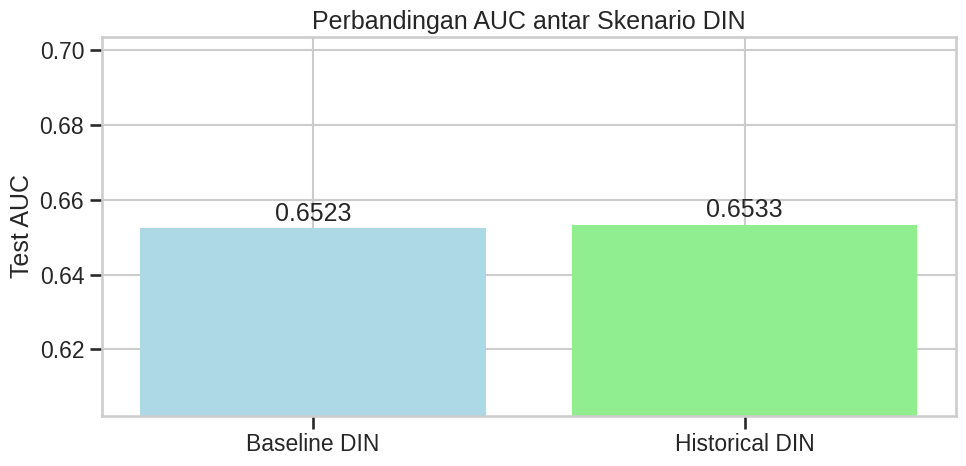


Perbandingan Metrik antar Skenario:
      Scenario  Test AUC  Test Log Loss
  Baseline DIN  0.652334       0.227606
Historical DIN  0.653310       0.225878

Hasil perbandingan disimpan di: results/din_scenarios_comparison.csv

EKSPERIMEN SKENARIO DIN SELESAI


In [ ]:
0# =====================================================================
# CELL: DIN SCENARIO IMPLEMENTATION (BASELINE, HISTORICAL)
# =====================================================================

# Impor library yang mungkin belum ada (asumsi)
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from sklearn.metrics import log_loss

# Asumsi variabel-variabel ini sudah ada dari sel sebelumnya
# model_data = ...

print("\n" + "="*60)
print("DIN SCENARIO IMPLEMENTATION (BASELINE, HISTORICAL)")
print("="*60)

# 1. Definisikan fungsi untuk membuat model DIN dengan variasi fitur
def create_din_model_with_features(features_to_use, best_params=None):
    """
    Membuat model DIN dengan kombinasi fitur yang berbeda.

    Args:
        features_to_use: List fitur yang digunakan ['user_id', 'item_id', 'sequence']
        best_params: Dictionary berisi parameter hasil tuning untuk menimpa default.

    Returns:
        Model DIN yang telah dikonfigurasi dan parameter yang digunakan.
    """
    # 1. Mulai dengan parameter default.
    params = {
        'attention_hidden': 16,
        'dropout_rate': 0.5,
        'l2_reg': 1e-5,
        'l2_dense': 1e-5,
        'dice_alpha_init': 0.4,
        'dice_beta_init': 1.5,
        'dice_epsilon': 1e-9,
        'learning_rate': 1e-4,
        'batch_size': 4096,
        'label_smoothing': 0.1,
        'hidden_units': [64, 32]
    }

    # 2. Jika best_params diberikan, timpa default dengan SEMUA nilai dari best_params.
    if best_params:
        print("Menggunakan parameter dari hasil tuning (best_params) untuk menimpa default.")
        params.update(best_params)
    else:
        print("Menggunakan parameter default karena tidak ada best_params yang diberikan.")

    # Parameter Model
    n_users = model_data['model_params']['n_users']
    n_items = model_data['model_params']['n_items']
    embedding_dim = 32
    hidden_units = params['hidden_units']
    attention_hidden = params['attention_hidden']
    max_seq_len = 8
    dense_feature_dim = model_data['model_params']['dense_feature_dim']
    dropout_rate = params['dropout_rate']
    l2_reg = params['l2_reg']
    l2_dense = params['l2_dense']

    # Parameter untuk aktivasi DICE
    dice_params = {
        'alpha_init': params['dice_alpha_init'],
        'beta_init': params['dice_beta_init'],
        'epsilon': params['dice_epsilon']
    }

    # Definisikan nama model berdasarkan fitur yang digunakan
    if set(features_to_use) == set(['user_id', 'item_id']):
        model_name = 'din_baseline'
        print(f"Membuat Baseline DIN (Hanya User ID, Item ID)")
    elif set(features_to_use) == set(['user_id', 'item_id', 'sequence']):
        model_name = 'din_historical'
        print(f"Membuat Historical DIN (User ID, Item ID, Sequence)")
    else:
        model_name = 'din_custom'
        print(f"Membuat Custom DIN dengan fitur: {features_to_use}")

    # Siapkan input layers
    inputs = {}
    inputs['user_id'] = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='user_id')
    inputs['item_id'] = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='item_id')

    if 'sequence' in features_to_use:
        inputs['sequence'] = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name='sequence')
        inputs['seq_length'] = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='seq_length')

    # EMBEDDING LAYERS
    user_embedding_layer = tf.keras.layers.Embedding(
        n_users, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
        name='user_embedding'
    )
    item_embedding_layer = tf.keras.layers.Embedding(
        n_items, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
        name='item_embedding'
    )

    user_emb = user_embedding_layer(inputs['user_id'])
    target_item_emb = item_embedding_layer(inputs['item_id'])
    feature_list = [user_emb, target_item_emb]

    if 'sequence' in features_to_use:
        sequence_emb = item_embedding_layer(inputs['sequence'])

        # Asumsi DINAttention dan SequencePooling sudah didefinisikan di tempat lain
        attention_scores, attended_emb = DINAttention(
            hidden_units=attention_hidden, max_seq_len=max_seq_len, activation_type='dice',
            dice_alpha_init=dice_params['alpha_init'], dice_beta_init=dice_params['beta_init'],
            dice_epsilon=dice_params['epsilon'], name='din_attention'
        )([sequence_emb, target_item_emb])

        pooled_sequence = SequencePooling(name='sequence_pooling')(
            [attention_scores, attended_emb, inputs['seq_length']]
        )
        feature_list.append(pooled_sequence)

    all_features = tf.keras.layers.Concatenate(name='feature_concat')(feature_list)
    x = all_features
    for i, units in enumerate(hidden_units):
        x = tf.keras.layers.Dense(
            units, name=f'dense_{i+1}',
            kernel_regularizer=tf.keras.regularizers.l2(l2_dense)
        )(x)
        # Asumsi DiceActivation sudah didefinisikan di tempat lain
        x = DiceActivation(
            name=f'dice_{i+1}', alpha_init=dice_params['alpha_init'],
            beta_init=dice_params['beta_init'], epsilon=dice_params['epsilon']
        )(x)
        x = tf.keras.layers.Dropout(dropout_rate, name=f'dropout_{i+1}')(x)
        x = tf.keras.layers.BatchNormalization(name=f'bn_{i+1}')(x)

    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output',
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    model = tf.keras.Model(inputs=list(inputs.values()), outputs=output, name=model_name)

    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'], clipnorm=0.5)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=params['label_smoothing'])
    metrics = [
        tf.keras.metrics.AUC(name='auc'),
    ]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    print(f"Model {model_name} berhasil dibuat!")
    print(f"Total parameter: {model.count_params():,}")

    return model, params

# 2. Fungsi untuk melatih model dengan skenario fitur tertentu
def train_din_scenario(scenario_name, features_to_use, best_params=None, epochs=15):
    """
    Melatih model DIN dengan skenario fitur spesifik.
    """
    print(f"\n{'='*60}")
    print(f"TRAINING {scenario_name}")
    print(f"Fitur: {features_to_use}")
    print(f"{'='*60}")

    model, params = create_din_model_with_features(features_to_use, best_params)

    train_x, val_x, test_x = {}, {}, {}
    train_x['user_id'] = model_data['splits']['train']['user_ids']
    train_x['item_id'] = model_data['splits']['train']['item_ids']
    val_x['user_id'] = model_data['splits']['val']['user_ids']
    val_x['item_id'] = model_data['splits']['val']['item_ids']
    test_x['user_id'] = model_data['splits']['test']['user_ids']
    test_x['item_id'] = model_data['splits']['test']['item_ids']

    if 'sequence' in features_to_use:
        train_x['sequence'] = model_data['splits']['train']['sequences']
        train_x['seq_length'] = model_data['splits']['train']['seq_lengths']
        val_x['sequence'] = model_data['splits']['val']['sequences']
        val_x['seq_length'] = model_data['splits']['val']['seq_lengths']
        test_x['sequence'] = model_data['splits']['test']['sequences']
        test_x['seq_length'] = model_data['splits']['test']['seq_lengths']

    train_y = model_data['splits']['train']['labels']
    val_y = model_data['splits']['val']['labels']
    test_y = model_data['splits']['test']['labels']

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True, mode='max'),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, min_lr=1e-6, mode='max')
    ]

    os.makedirs(f'results/{scenario_name}', exist_ok=True)
    checkpoint_path = f'results/{scenario_name}/model_checkpoint.weights.h5'
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_auc', mode='max', save_best_only=True, save_weights_only=True)
    callbacks.append(model_checkpoint)

    csv_path = f'results/{scenario_name}/training_history.csv'
    csv_logger = tf.keras.callbacks.CSVLogger(csv_path)
    callbacks.append(csv_logger)

    batch_size = params['batch_size']
    print(f"\nMemulai training untuk {scenario_name}...")
    print(f"Training dengan parameter: {json.dumps(params, indent=4)}")

    history = model.fit(
        x=train_x, y=train_y,
        validation_data=(val_x, val_y),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    print(f"\nEvaluasi {scenario_name} pada test set...")
    test_results = model.evaluate(test_x, test_y, verbose=1)
    test_metrics = {
        'test_loss': test_results[0], 'test_auc': test_results[1],
    }

    test_preds = model.predict(test_x, batch_size=batch_size)
    test_metrics['test_logloss'] = log_loss(test_y, test_preds)

    metrics_path = f'results/{scenario_name}/test_metrics.json'
    with open(metrics_path, 'w') as f:
        json.dump(test_metrics, f, indent=4)

    print(f"\nMetrik tes untuk {scenario_name}:")
    for metric, value in test_metrics.items():
        print(f"  {metric}: {value:.4f}")

    return model, history, test_metrics

# 3. Jalankan eksperimen untuk setiap skenario
# Gunakan parameter terbaik dari hasil tuning yang Anda berikan
din_best_params = {
    "learning_rate": 0.0001,
    "batch_size": 4096,
    "dropout_rate": 0.4,
    "l2_reg": 1e-05,
    "l2_dense": 0.0001,
    "dice_alpha_init": 0.35,
    "dice_beta_init": 1.0,
    "dice_epsilon": 1e-09,
    "attention_hidden": 16,
    "label_smoothing": 0.15,
    "hidden_units": [128, 64]
}

# 3.1 Baseline DIN
baseline_model, baseline_history, baseline_metrics = train_din_scenario(
    scenario_name="baseline_din",
    features_to_use=['user_id', 'item_id'],
    best_params=din_best_params,
    epochs=15
)

# 3.2 Historical DIN
historical_model, historical_history, historical_metrics = train_din_scenario(
    scenario_name="historical_din",
    features_to_use=['user_id', 'item_id', 'sequence'],
    best_params=din_best_params,
    epochs=15
)

# 4. Visualisasikan dan analisis hasil (kode ini tetap sama seperti sebelumnya)

print("\n" + "="*60)
print("HASIL PERBANDINGAN SKENARIO DIN")
print("="*60)

scenarios = ['Baseline DIN', 'Historical DIN']
test_aucs = [baseline_metrics['test_auc'], historical_metrics['test_auc']]
test_loglosses = [baseline_metrics['test_logloss'], historical_metrics['test_logloss']]

plt.figure(figsize=(10, 5))
plt.bar(scenarios, test_aucs, color=['lightblue', 'lightgreen'])
plt.ylabel('Test AUC')
plt.title('Perbandingan AUC antar Skenario DIN')
plt.ylim(bottom=max(0, min(test_aucs) - 0.05), top=min(1.0, max(test_aucs) + 0.05))
for i, v in enumerate(test_aucs):
    plt.text(i, v + 0.002, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.savefig('results/din_scenarios_auc_comparison.png', dpi=300)
plt.show()

results_summary = pd.DataFrame({
    'Scenario': scenarios,
    'Test AUC': test_aucs,
    'Test Log Loss': test_loglosses,
})

print("\nPerbandingan Metrik antar Skenario:")
print(results_summary.to_string(index=False))
results_summary.to_csv('results/din_scenarios_comparison.csv', index=False)
print("\nHasil perbandingan disimpan di: results/din_scenarios_comparison.csv")

print("\n" + "="*60)
print("EKSPERIMEN SKENARIO DIN SELESAI")
print("="*60)